In [1]:
# Parameters
var_list = ["default1", "default2"]
plevel_list = [False, 300]
aew_subset = "default_subset"
model_save_name = "default_model.keras"
tuner_project_name = "default_tuner_run"






In [2]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "q",
    "r",
    "r",
    "sp",
    "sstk",
    "tcw",
    "tcwv",
    "t",
    "t",
    "ttr",
    "u",
    "u",
    "v",
    "v",
    "vo",
    "w",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    900,
    300,
    900,
    False,
    False,
    False,
    False,
    300,
    900,
    False,
    300,
    900,
    300,
    900,
    300,
    300,
    900,
]
aew_subset = "12hr_before"
model_save_name = "best_model_var0.keras"
tuner_project_name = "tuner_run_0"


In [3]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner

import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-03-27 14:24:36.479176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 14:24:36.491511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743107076.503214  120322 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743107076.506791  120322 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 14:24:36.520757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
def add_dim(ds):

    """

    Preprocessing help when opening netcdf files

    """

    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars(

    'utc_date').drop_vars("latitude").drop_vars('longitude')

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):

   """

   Eagerly load the training labels and data, reshaping data to (samples, y, x, features).

   """

   thedatas = {}


   for key, value in data_dictionary.items():


       if '_' not in key:


          thedatas[key] = value[key.upper()].expand_dims('features').transpose(

                           'sample', 'latitude', 'longitude', 'features').values


       if '_' in key:


          thedatas[key] = value[key.split('_')[0].upper()].expand_dims('features').transpose(

                          'sample', 'latitude', 'longitude', 'features').values


       label = value['label'].values


   if len(data_dictionary) > 1:

       data = np.concatenate(list(thedatas.values()), axis=3)
   if len(data_dictionary) == 1:

       data = np.squeeze(np.asarray(list(thedatas.values())), axis=0)
   return data, label

In [9]:
def omit_nans(data, label):

   """

   Remove any ``nans`` from the data.

   Args:

   data (numpy array): Training data.

   label (numpy array): Labels for supervised learning.

   Returns:

   data (numpy array): Training data with ``nans`` removed.

   label (numpy array): Corresponding labels of data.
 
   """

   maskarray = np.full(data.shape[0], True)

   masker = np.unique(np.argwhere(np.isnan(data))[:, 0])

   maskarray[masker] = False

   traindata = data[maskarray, :, :, :]

   trainlabel = label[maskarray]

   return traindata, trainlabel

In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):

   """

   Help selecting the activation functions

   """

   lossdict = {

           "relu": keras.activations.relu,

           "tanh": keras.activations.tanh,

           "selu": keras.activations.selu,

           "sigmoid": keras.activations.sigmoid,

           "relu6": keras.activations.relu6,

           "silu": keras.activations.silu,

           "gelu": keras.activations.gelu,

           "lrelu": keras.activations.leaky_relu,

   }

   return lossdict[loss_string]

In [14]:
number_of_features = len(var_list)

In [15]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/project/zarr"
)




Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading q_300 from Zarr store.
Loading q_900 from Zarr store.
Loading r_300 from Zarr store.
Loading r_900 from Zarr store.
Loading sp from Zarr store.
Loading sstk from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading t_900 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading u_900 from Zarr store.
Loading v_300 from Zarr store.
Loading v_900 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.
Loading w_900 from Zarr store.


In [16]:
print(data['u_300'])

<xarray.Dataset> Size: 11MB
Dimensions:  (sample: 2750, latitude: 32, longitude: 32)
Coordinates:
    level    float64 8B ...
  * sample   (sample) int64 22kB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    time     (sample) datetime64[ns] 22kB dask.array<chunksize=(2750,), meta=np.ndarray>
Dimensions without coordinates: latitude, longitude
Data variables:
    U        (sample, latitude, longitude) float32 11MB dask.array<chunksize=(1, 32, 32), meta=np.ndarray>
    label    (sample) float64 22kB dask.array<chunksize=(2750,), meta=np.ndarray>
Attributes:
    CONVERSION_DATE:      Thu May 16 09:57:32 MDT 2019
    CONVERSION_PLATFORM:  Linux r1i5n5 3.12.62-60.64.8-default #1 SMP Tue Oct...
    Conventions:          CF-1.6
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    NETCDF_CONVERSION:    C

In [16]:
# transpose the data and concat variables

data_, labels_ = transpose_load_concat(data)

print (np.shape(data_))

(2750, 32, 32, 25)


In [17]:
# check / remove nans

data_, labels_ = omit_nans(data_, labels_)

In [18]:
#split train and test sets

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(

data_, labels_, test_size=0.2, random_state=42)


print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(560, 32, 32, 25) (140, 32, 32, 25) (560,) (140,)


In [19]:
# now rescale using sklearn object

# create our scaler object

# scaler_input = sklearn.preprocessing.MinMaxScaler()

#Zscore scaling

scaler_input = sklearn.preprocessing.StandardScaler()


# now fit and transform our input data and labels

# training data

# inputs

X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

input_train_scaled = scaler_input.fit_transform(X_train_tmp)

input_train_scaled = np.reshape(input_train_scaled, X_train.shape)

# labels

label_train_scaled = y_train


# testing data

# inputs

X_test_tmp = np.reshape(X_test, (-1, len(var_list)))

input_test_scaled = scaler_input.fit_transform(X_test_tmp)

input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# labels

label_test_scaled = y_test

In [20]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(560, 32, 32, 25) (560, 1) (140, 32, 32, 25) (140, 1)


In [21]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 91 (16.25% of total)


In [22]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.1625, 1: 0.8375}


In [23]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

W0000 00:00:1740856990.897342    7734 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
# Build CNN using keras-tuner

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # start building model
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # things to tune
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice(
            "activation",
            ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"]
        )

        # hidden layers
        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=f1_loss_sigmoid,
            metrics=METRICS
        )
        return model


In [25]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [26]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_mean_squared_error", direction="min"),
    max_trials=100,
    project_name=tuner_project_name,    # Use the passed parameter
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [27]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 100 Complete [00h 01m 20s]
val_mean_squared_error: 0.1071428582072258

Best val_mean_squared_error So Far: 0.06525017321109772
Total elapsed time: 03h 56m 55s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 25)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 25)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 12)          │           2,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 62)          │           6,758 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 62)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 62)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 117)           │          65,403 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 117)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 117)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 117)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,824 (315.72 KB)

 Trainable params: 80,824 (315.72 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - auc: 0.5773 - binary_accuracy: 0.8295 - cross entropy: 7.2680 - f1_score: 0.2105 - fn: 9.0000 - fp: 6.0000 - loss: 0.1981 - mean_squared_error: 0.1434 - prc: 0.2453 - precision: 0.2500 - recall: 0.1818 - root_mean_squared_error: 0.3787 - tn: 71.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.6378 - binary_accuracy: 0.7369 - cross entropy: 5.8094 - f1_score: 0.3316 - fn: 9.0000 - fp: 24.3333 - loss: 0.1991 - mean_squared_error: 0.1852 - prc: 0.2831 - precision: 0.2786 - recall: 0.4583 - root_mean_squared_error: 0.4287 - tn: 76.6667 - tp: 10.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.6587 - binary_accuracy: 0.6886 - cross entropy: 5.0229 - f1_score: 0.3709 - fn: 9.2000 - fp: 41.6000 - loss: 0.1972 - mean_squared_error: 0.2188 - prc: 0.2966 - precision: 0.2876 - recall: 0.5759 - root_mean_squared_error: 0.4647 - tn: 83.6000 - tp: 17.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6651 - binary_accuracy: 0.6534 - cross entropy: 4.5297 - f1_score: 0.3789 - fn: 9.4286 - fp: 59.7143 - loss: 0.1948 - mean_squared_error: 0.2449 - prc: 0.2928 - precision: 0.2817 - recall: 0.6375 - root_mean_squared_error: 0.4910 - tn: 91.4286 - tp: 23.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6690 - binary_accuracy: 0.6302 - cross entropy: 4.1855 - f1_score: 0.3781 - fn: 9.5556 - fp: 77.1111 - loss: 0.1922 - mean_squared_error: 0.2639 - prc: 0.2865 - precision: 0.2732 - recall: 0.6771 - root_mean_squared_error: 0.5096 - tn: 101.2222 - tp: 28.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.6746 - binary_accuracy: 0.6178 - cross entropy: 3.9194 - f1_score: 0.3804 - fn: 9.8182 - fp: 92.2727 - loss: 0.1898 - mean_squared_error: 0.2761 - prc: 0.2872 - precision: 0.2699 - recall: 0.7055 - root_mean_squared_error: 0.5216 - tn: 112.9091 - tp: 33.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.6830 - binary_accuracy: 0.6116 - cross entropy: 3.6978 - f1_score: 0.3833 - fn: 10.0000 - fp: 106.0000 - loss: 0.1871 - mean_squared_error: 0.2831 - prc: 0.2913 - precision: 0.2685 - recall: 0.7282 - root_mean_squared_error: 0.5286 - tn: 126.2308 - tp: 37.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.6901 - binary_accuracy: 0.6085 - cross entropy: 3.5098 - f1_score: 0.3860 - fn: 10.4667 - fp: 118.6000 - loss: 0.1848 - mean_squared_error: 0.2871 - prc: 0.2952 - precision: 0.2681 - recall: 0.7435 - root_mean_squared_error: 0.5327 - tn: 140.5333 - tp: 42.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.6962 - binary_accuracy: 0.6065 - cross entropy: 3.3546 - f1_score: 0.3879 - fn: 10.8824 - fp: 129.9412 - loss: 0.1828 - mean_squared_error: 0.2897 - prc: 0.2981 - precision: 0.2676 - recall: 0.7556 - root_mean_squared_error: 0.5354 - tn: 153.8824 - tp: 46.4706 - val_auc: 0.7400 - val_binary_accuracy: 0.7143 - val_cross entropy: 0.6431 - val_f1_score: 0.3846 - val_fn: 1.0000 - val_fp: 15.0000 - val_loss: 0.6865 - val_mean_squared_error: 0.2043 - val_prc: 0.3554 - val_precision: 0.2500 - val_recall: 0.8333 - val_root_mean_squared_error: 0.4520 - val_tn: 35.0000 - val_tp: 5.0000


Epoch 2/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.6926 - binary_accuracy: 0.6250 - cross entropy: 1.2240 - f1_score: 0.2500 - fn: 3.0000 - fp: 9.0000 - loss: 0.1804 - mean_squared_error: 0.2493 - prc: 0.4553 - precision: 0.1818 - recall: 0.4000 - root_mean_squared_error: 0.4993 - tn: 18.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.7527 - binary_accuracy: 0.6736 - cross entropy: 1.0492 - f1_score: 0.4039 - fn: 4.6667 - fp: 15.3333 - loss: 0.1661 - mean_squared_error: 0.2331 - prc: 0.4400 - precision: 0.3117 - recall: 0.5766 - root_mean_squared_error: 0.4826 - tn: 35.6667 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7660 - binary_accuracy: 0.6870 - cross entropy: 0.9837 - f1_score: 0.4421 - fn: 7.4000 - fp: 21.4000 - loss: 0.1610 - mean_squared_error: 0.2237 - prc: 0.4689 - precision: 0.3498 - recall: 0.6047 - root_mean_squared_error: 0.4726 - tn: 53.8000 - tp: 13.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7775 - binary_accuracy: 0.7030 - cross entropy: 0.9232 - f1_score: 0.4633 - fn: 9.1429 - fp: 26.7143 - loss: 0.1557 - mean_squared_error: 0.2130 - prc: 0.4823 - precision: 0.3690 - recall: 0.6258 - root_mean_squared_error: 0.4610 - tn: 74.4286 - tp: 17.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7862 - binary_accuracy: 0.7150 - cross entropy: 0.8846 - f1_score: 0.4737 - fn: 10.2222 - fp: 32.3333 - loss: 0.1521 - mean_squared_error: 0.2064 - prc: 0.4823 - precision: 0.3755 - recall: 0.6445 - root_mean_squared_error: 0.4537 - tn: 96.0000 - tp: 21.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7929 - binary_accuracy: 0.7221 - cross entropy: 0.8666 - f1_score: 0.4799 - fn: 11.5455 - fp: 38.2727 - loss: 0.1496 - mean_squared_error: 0.2024 - prc: 0.4877 - precision: 0.3791 - recall: 0.6561 - root_mean_squared_error: 0.4493 - tn: 116.9091 - tp: 25.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7995 - binary_accuracy: 0.7289 - cross entropy: 0.8467 - f1_score: 0.4848 - fn: 12.8462 - fp: 43.6923 - loss: 0.1472 - mean_squared_error: 0.1981 - prc: 0.4937 - precision: 0.3823 - recall: 0.6644 - root_mean_squared_error: 0.4444 - tn: 138.5385 - tp: 28.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8030 - binary_accuracy: 0.7339 - cross entropy: 0.8388 - f1_score: 0.4882 - fn: 14.2667 - fp: 49.2000 - loss: 0.1456 - mean_squared_error: 0.1957 - prc: 0.4953 - precision: 0.3846 - recall: 0.6700 - root_mean_squared_error: 0.4417 - tn: 159.9333 - tp: 32.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8056 - binary_accuracy: 0.7379 - cross entropy: 0.8355 - f1_score: 0.4908 - fn: 15.4118 - fp: 54.3529 - loss: 0.1443 - mean_squared_error: 0.1940 - prc: 0.4944 - precision: 0.3859 - recall: 0.6756 - root_mean_squared_error: 0.4398 - tn: 179.4706 - tp: 35.9412 - val_auc: 0.7667 - val_binary_accuracy: 0.7500 - val_cross entropy: 0.8806 - val_f1_score: 0.3636 - val_fn: 2.0000 - val_fp: 12.0000 - val_loss: 0.6443 - val_mean_squared_error: 0.2090 - val_prc: 0.3926 - val_precision: 0.2500 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4572 - val_tn: 38.0000 - val_tp: 4.0000


Epoch 3/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6667 - binary_accuracy: 0.6875 - cross entropy: 2.0743 - f1_score: 0.3750 - fn: 2.0000 - fp: 8.0000 - loss: 0.1657 - mean_squared_error: 0.2585 - prc: 0.3374 - precision: 0.2727 - recall: 0.6000 - root_mean_squared_error: 0.5084 - tn: 19.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7183 - binary_accuracy: 0.7066 - cross entropy: 1.8088 - f1_score: 0.4560 - fn: 4.3333 - fp: 14.0000 - loss: 0.1567 - mean_squared_error: 0.2504 - prc: 0.3718 - precision: 0.3550 - recall: 0.6432 - root_mean_squared_error: 0.5003 - tn: 37.0000 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7425 - binary_accuracy: 0.7165 - cross entropy: 1.6748 - f1_score: 0.4887 - fn: 6.6000 - fp: 19.8000 - loss: 0.1524 - mean_squared_error: 0.2459 - prc: 0.4149 - precision: 0.3890 - recall: 0.6628 - root_mean_squared_error: 0.4958 - tn: 55.4000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7608 - binary_accuracy: 0.7282 - cross entropy: 1.5672 - f1_score: 0.5056 - fn: 8.0000 - fp: 25.2857 - loss: 0.1468 - mean_squared_error: 0.2358 - prc: 0.4395 - precision: 0.4035 - recall: 0.6809 - root_mean_squared_error: 0.4852 - tn: 75.8571 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7751 - binary_accuracy: 0.7387 - cross entropy: 1.4820 - f1_score: 0.5141 - fn: 8.8889 - fp: 30.5556 - loss: 0.1431 - mean_squared_error: 0.2273 - prc: 0.4516 - precision: 0.4086 - recall: 0.6965 - root_mean_squared_error: 0.4761 - tn: 97.7778 - tp: 22.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7857 - binary_accuracy: 0.7456 - cross entropy: 1.4230 - f1_score: 0.5198 - fn: 10.0000 - fp: 35.9091 - loss: 0.1406 - mean_squared_error: 0.2212 - prc: 0.4635 - precision: 0.4122 - recall: 0.7062 - root_mean_squared_error: 0.4697 - tn: 119.2727 - tp: 26.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7949 - binary_accuracy: 0.7528 - cross entropy: 1.3630 - f1_score: 0.5258 - fn: 11.0000 - fp: 40.6154 - loss: 0.1381 - mean_squared_error: 0.2147 - prc: 0.4744 - precision: 0.4167 - recall: 0.7147 - root_mean_squared_error: 0.4625 - tn: 141.6154 - tp: 30.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7997 - binary_accuracy: 0.7576 - cross entropy: 1.3196 - f1_score: 0.5280 - fn: 12.4667 - fp: 45.3333 - loss: 0.1370 - mean_squared_error: 0.2102 - prc: 0.4804 - precision: 0.4189 - recall: 0.7161 - root_mean_squared_error: 0.4575 - tn: 163.8000 - tp: 34.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8033 - binary_accuracy: 0.7614 - cross entropy: 1.2834 - f1_score: 0.5288 - fn: 13.8235 - fp: 49.6471 - loss: 0.1362 - mean_squared_error: 0.2066 - prc: 0.4834 - precision: 0.4198 - recall: 0.7162 - root_mean_squared_error: 0.4535 - tn: 184.1765 - tp: 37.5294 - val_auc: 0.7817 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.7951 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.6370 - val_mean_squared_error: 0.1797 - val_prc: 0.4829 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4239 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 4/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.6704 - binary_accuracy: 0.7188 - cross entropy: 2.0318 - f1_score: 0.3077 - fn: 3.0000 - fp: 6.0000 - loss: 0.1716 - mean_squared_error: 0.2015 - prc: 0.3189 - precision: 0.2500 - recall: 0.4000 - root_mean_squared_error: 0.4489 - tn: 21.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7126 - binary_accuracy: 0.7257 - cross entropy: 1.7193 - f1_score: 0.4058 - fn: 6.0000 - fp: 11.3333 - loss: 0.1651 - mean_squared_error: 0.2119 - prc: 0.4351 - precision: 0.3454 - recall: 0.4935 - root_mean_squared_error: 0.4602 - tn: 39.6667 - tp: 7.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7321 - binary_accuracy: 0.7335 - cross entropy: 1.6012 - f1_score: 0.4546 - fn: 8.4000 - fp: 16.6000 - loss: 0.1581 - mean_squared_error: 0.2104 - prc: 0.4762 - precision: 0.3889 - recall: 0.5480 - root_mean_squared_error: 0.4586 - tn: 58.6000 - tp: 12.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7484 - binary_accuracy: 0.7445 - cross entropy: 1.5168 - f1_score: 0.4819 - fn: 9.7143 - fp: 21.7143 - loss: 0.1511 - mean_squared_error: 0.2050 - prc: 0.4879 - precision: 0.4087 - recall: 0.5885 - root_mean_squared_error: 0.4526 - tn: 79.4286 - tp: 17.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7600 - binary_accuracy: 0.7498 - cross entropy: 1.4678 - f1_score: 0.4924 - fn: 10.4444 - fp: 28.0000 - loss: 0.1471 - mean_squared_error: 0.2029 - prc: 0.4845 - precision: 0.4101 - recall: 0.6201 - root_mean_squared_error: 0.4503 - tn: 100.3333 - tp: 21.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7685 - binary_accuracy: 0.7525 - cross entropy: 1.4495 - f1_score: 0.5007 - fn: 11.0909 - fp: 34.7273 - loss: 0.1444 - mean_squared_error: 0.2029 - prc: 0.4812 - precision: 0.4109 - recall: 0.6467 - root_mean_squared_error: 0.4503 - tn: 120.4545 - tp: 25.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7765 - binary_accuracy: 0.7552 - cross entropy: 1.4308 - f1_score: 0.5071 - fn: 11.6154 - fp: 41.3077 - loss: 0.1421 - mean_squared_error: 0.2025 - prc: 0.4793 - precision: 0.4112 - recall: 0.6687 - root_mean_squared_error: 0.4499 - tn: 140.9231 - tp: 30.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7818 - binary_accuracy: 0.7571 - cross entropy: 1.4236 - f1_score: 0.5119 - fn: 12.2667 - fp: 47.8667 - loss: 0.1404 - mean_squared_error: 0.2026 - prc: 0.4756 - precision: 0.4114 - recall: 0.6854 - root_mean_squared_error: 0.4500 - tn: 161.2667 - tp: 34.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7859 - binary_accuracy: 0.7586 - cross entropy: 1.4240 - f1_score: 0.5151 - fn: 12.8235 - fp: 53.8824 - loss: 0.1391 - mean_squared_error: 0.2029 - prc: 0.4719 - precision: 0.4109 - recall: 0.6989 - root_mean_squared_error: 0.4503 - tn: 179.9412 - tp: 38.5294 - val_auc: 0.7567 - val_binary_accuracy: 0.7679 - val_cross entropy: 1.1783 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.6447 - val_mean_squared_error: 0.2272 - val_prc: 0.3190 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4766 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 5/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.6889 - binary_accuracy: 0.7188 - cross entropy: 2.2737 - f1_score: 0.4000 - fn: 2.0000 - fp: 7.0000 - loss: 0.1590 - mean_squared_error: 0.2302 - prc: 0.3817 - precision: 0.3000 - recall: 0.6000 - root_mean_squared_error: 0.4798 - tn: 20.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7553 - binary_accuracy: 0.7309 - cross entropy: 2.0605 - f1_score: 0.4919 - fn: 3.6667 - fp: 13.3333 - loss: 0.1493 - mean_squared_error: 0.2301 - prc: 0.4299 - precision: 0.3845 - recall: 0.6847 - root_mean_squared_error: 0.4797 - tn: 37.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7681 - binary_accuracy: 0.7451 - cross entropy: 1.9461 - f1_score: 0.5325 - fn: 5.4000 - fp: 18.2000 - loss: 0.1439 - mean_squared_error: 0.2232 - prc: 0.4543 - precision: 0.4264 - recall: 0.7126 - root_mean_squared_error: 0.4723 - tn: 57.0000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7811 - binary_accuracy: 0.7622 - cross entropy: 1.8142 - f1_score: 0.5564 - fn: 6.5714 - fp: 21.8571 - loss: 0.1377 - mean_squared_error: 0.2111 - prc: 0.4675 - precision: 0.4508 - recall: 0.7301 - root_mean_squared_error: 0.4589 - tn: 79.2857 - tp: 20.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7927 - binary_accuracy: 0.7754 - cross entropy: 1.6918 - f1_score: 0.5690 - fn: 7.3333 - fp: 25.5556 - loss: 0.1336 - mean_squared_error: 0.2007 - prc: 0.4747 - precision: 0.4617 - recall: 0.7440 - root_mean_squared_error: 0.4470 - tn: 102.7778 - tp: 24.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8007 - binary_accuracy: 0.7838 - cross entropy: 1.6101 - f1_score: 0.5760 - fn: 8.4545 - fp: 29.3636 - loss: 0.1314 - mean_squared_error: 0.1940 - prc: 0.4801 - precision: 0.4686 - recall: 0.7496 - root_mean_squared_error: 0.4394 - tn: 125.8182 - tp: 28.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8073 - binary_accuracy: 0.7913 - cross entropy: 1.5365 - f1_score: 0.5817 - fn: 9.6154 - fp: 32.6923 - loss: 0.1295 - mean_squared_error: 0.1879 - prc: 0.4855 - precision: 0.4749 - recall: 0.7525 - root_mean_squared_error: 0.4322 - tn: 149.5385 - tp: 32.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8108 - binary_accuracy: 0.7958 - cross entropy: 1.4834 - f1_score: 0.5832 - fn: 11.1333 - fp: 36.3333 - loss: 0.1286 - mean_squared_error: 0.1840 - prc: 0.4874 - precision: 0.4778 - recall: 0.7505 - root_mean_squared_error: 0.4277 - tn: 172.8000 - tp: 35.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8135 - binary_accuracy: 0.7988 - cross entropy: 1.4412 - f1_score: 0.5833 - fn: 12.4118 - fp: 40.0588 - loss: 0.1279 - mean_squared_error: 0.1813 - prc: 0.4875 - precision: 0.4782 - recall: 0.7494 - root_mean_squared_error: 0.4246 - tn: 193.7647 - tp: 38.9412 - val_auc: 0.7900 - val_binary_accuracy: 0.8036 - val_cross entropy: 0.9581 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.6050 - val_mean_squared_error: 0.1871 - val_prc: 0.4961 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4326 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 6/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.6963 - binary_accuracy: 0.8438 - cross entropy: 2.1774 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.1551 - mean_squared_error: 0.1547 - prc: 0.4109 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3933 - tn: 25.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7394 - binary_accuracy: 0.8194 - cross entropy: 1.8109 - f1_score: 0.5427 - fn: 4.6667 - fp: 7.3333 - loss: 0.1453 - mean_squared_error: 0.1768 - prc: 0.4578 - precision: 0.5230 - recall: 0.5766 - root_mean_squared_error: 0.4201 - tn: 43.6667 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7582 - binary_accuracy: 0.8151 - cross entropy: 1.6951 - f1_score: 0.5778 - fn: 6.4000 - fp: 11.8000 - loss: 0.1394 - mean_squared_error: 0.1793 - prc: 0.4876 - precision: 0.5374 - recall: 0.6352 - root_mean_squared_error: 0.4231 - tn: 63.4000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7749 - binary_accuracy: 0.8171 - cross entropy: 1.5954 - f1_score: 0.5939 - fn: 7.4286 - fp: 16.1429 - loss: 0.1339 - mean_squared_error: 0.1764 - prc: 0.5035 - precision: 0.5391 - recall: 0.6713 - root_mean_squared_error: 0.4198 - tn: 85.0000 - tp: 19.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7872 - binary_accuracy: 0.8194 - cross entropy: 1.5206 - f1_score: 0.5998 - fn: 8.0000 - fp: 20.7778 - loss: 0.1306 - mean_squared_error: 0.1738 - prc: 0.5072 - precision: 0.5326 - recall: 0.6982 - root_mean_squared_error: 0.4167 - tn: 107.5556 - tp: 23.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7943 - binary_accuracy: 0.8197 - cross entropy: 1.4812 - f1_score: 0.6017 - fn: 8.9091 - fp: 25.5455 - loss: 0.1289 - mean_squared_error: 0.1732 - prc: 0.5074 - precision: 0.5266 - recall: 0.7137 - root_mean_squared_error: 0.4160 - tn: 129.6364 - tp: 27.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8010 - binary_accuracy: 0.8211 - cross entropy: 1.4354 - f1_score: 0.6036 - fn: 9.7692 - fp: 29.9231 - loss: 0.1272 - mean_squared_error: 0.1715 - prc: 0.5095 - precision: 0.5229 - recall: 0.7255 - root_mean_squared_error: 0.4139 - tn: 152.3077 - tp: 32.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8040 - binary_accuracy: 0.8217 - cross entropy: 1.4018 - f1_score: 0.6030 - fn: 11.0667 - fp: 34.1333 - loss: 0.1266 - mean_squared_error: 0.1704 - prc: 0.5078 - precision: 0.5193 - recall: 0.7296 - root_mean_squared_error: 0.4126 - tn: 175.0000 - tp: 35.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8067 - binary_accuracy: 0.8224 - cross entropy: 1.3739 - f1_score: 0.6025 - fn: 12.1176 - fp: 38.0000 - loss: 0.1259 - mean_squared_error: 0.1693 - prc: 0.5058 - precision: 0.5162 - recall: 0.7337 - root_mean_squared_error: 0.4112 - tn: 195.8235 - tp: 39.2353 - val_auc: 0.7400 - val_binary_accuracy: 0.7857 - val_cross entropy: 1.0057 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.6080 - val_mean_squared_error: 0.1922 - val_prc: 0.3913 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4384 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 7/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.7333 - binary_accuracy: 0.8750 - cross entropy: 2.3047 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1072 - mean_squared_error: 0.1157 - prc: 0.4897 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3401 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7602 - binary_accuracy: 0.8368 - cross entropy: 2.0050 - f1_score: 0.6032 - fn: 4.3333 - fp: 6.6667 - loss: 0.1155 - mean_squared_error: 0.1493 - prc: 0.4916 - precision: 0.5701 - recall: 0.6432 - root_mean_squared_error: 0.3851 - tn: 44.3333 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7714 - binary_accuracy: 0.8311 - cross entropy: 1.8842 - f1_score: 0.6171 - fn: 6.6000 - fp: 10.2000 - loss: 0.1165 - mean_squared_error: 0.1548 - prc: 0.5088 - precision: 0.5787 - recall: 0.6628 - root_mean_squared_error: 0.3925 - tn: 65.0000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7833 - binary_accuracy: 0.8335 - cross entropy: 1.7550 - f1_score: 0.6255 - fn: 8.0000 - fp: 13.5714 - loss: 0.1141 - mean_squared_error: 0.1518 - prc: 0.5171 - precision: 0.5799 - recall: 0.6809 - root_mean_squared_error: 0.3890 - tn: 87.5714 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7936 - binary_accuracy: 0.8349 - cross entropy: 1.6432 - f1_score: 0.6256 - fn: 8.8889 - fp: 17.5556 - loss: 0.1131 - mean_squared_error: 0.1495 - prc: 0.5195 - precision: 0.5702 - recall: 0.6965 - root_mean_squared_error: 0.3861 - tn: 110.7778 - tp: 22.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8006 - binary_accuracy: 0.8344 - cross entropy: 1.5847 - f1_score: 0.6235 - fn: 10.0000 - fp: 21.9091 - loss: 0.1131 - mean_squared_error: 0.1499 - prc: 0.5187 - precision: 0.5612 - recall: 0.7062 - root_mean_squared_error: 0.3867 - tn: 133.2727 - tp: 26.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8072 - binary_accuracy: 0.8350 - cross entropy: 1.5280 - f1_score: 0.6233 - fn: 10.9231 - fp: 26.0000 - loss: 0.1125 - mean_squared_error: 0.1490 - prc: 0.5194 - precision: 0.5552 - recall: 0.7157 - root_mean_squared_error: 0.3856 - tn: 156.2308 - tp: 30.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8106 - binary_accuracy: 0.8343 - cross entropy: 1.4951 - f1_score: 0.6203 - fn: 12.2000 - fp: 30.3333 - loss: 0.1128 - mean_squared_error: 0.1496 - prc: 0.5184 - precision: 0.5484 - recall: 0.7195 - root_mean_squared_error: 0.3864 - tn: 178.8000 - tp: 34.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8133 - binary_accuracy: 0.8335 - cross entropy: 1.4741 - f1_score: 0.6174 - fn: 13.2353 - fp: 34.5294 - loss: 0.1130 - mean_squared_error: 0.1503 - prc: 0.5162 - precision: 0.5418 - recall: 0.7234 - root_mean_squared_error: 0.3874 - tn: 199.2941 - tp: 38.1176 - val_auc: 0.7367 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.2089 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5876 - val_mean_squared_error: 0.1855 - val_prc: 0.2867 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4307 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 8/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7296 - binary_accuracy: 0.8750 - cross entropy: 2.5447 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1082 - mean_squared_error: 0.1085 - prc: 0.4420 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3295 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7540 - binary_accuracy: 0.8403 - cross entropy: 2.1988 - f1_score: 0.5858 - fn: 5.3333 - fp: 5.3333 - loss: 0.1259 - mean_squared_error: 0.1461 - prc: 0.4669 - precision: 0.5858 - recall: 0.5858 - root_mean_squared_error: 0.3802 - tn: 45.6667 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7722 - binary_accuracy: 0.8376 - cross entropy: 2.0410 - f1_score: 0.6018 - fn: 8.2000 - fp: 7.8000 - loss: 0.1253 - mean_squared_error: 0.1474 - prc: 0.5059 - precision: 0.6058 - recall: 0.5979 - root_mean_squared_error: 0.3827 - tn: 67.4000 - tp: 12.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7860 - binary_accuracy: 0.8407 - cross entropy: 1.8779 - f1_score: 0.6079 - fn: 10.4286 - fp: 10.0000 - loss: 0.1225 - mean_squared_error: 0.1438 - prc: 0.5205 - precision: 0.6119 - recall: 0.6040 - root_mean_squared_error: 0.3783 - tn: 91.1429 - tp: 16.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7971 - binary_accuracy: 0.8443 - cross entropy: 1.7462 - f1_score: 0.6099 - fn: 11.8889 - fp: 12.6667 - loss: 0.1200 - mean_squared_error: 0.1401 - prc: 0.5222 - precision: 0.6070 - recall: 0.6137 - root_mean_squared_error: 0.3734 - tn: 115.6667 - tp: 19.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8044 - binary_accuracy: 0.8453 - cross entropy: 1.6782 - f1_score: 0.6126 - fn: 13.0000 - fp: 16.2727 - loss: 0.1184 - mean_squared_error: 0.1390 - prc: 0.5204 - precision: 0.5992 - recall: 0.6293 - root_mean_squared_error: 0.3722 - tn: 138.9091 - tp: 23.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8106 - binary_accuracy: 0.8449 - cross entropy: 1.6228 - f1_score: 0.6127 - fn: 13.9231 - fp: 20.5385 - loss: 0.1172 - mean_squared_error: 0.1386 - prc: 0.5200 - precision: 0.5889 - recall: 0.6440 - root_mean_squared_error: 0.3717 - tn: 161.6923 - tp: 27.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8139 - binary_accuracy: 0.8430 - cross entropy: 1.6006 - f1_score: 0.6109 - fn: 14.9333 - fp: 25.4000 - loss: 0.1168 - mean_squared_error: 0.1400 - prc: 0.5157 - precision: 0.5780 - recall: 0.6556 - root_mean_squared_error: 0.3736 - tn: 183.7333 - tp: 31.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8161 - binary_accuracy: 0.8412 - cross entropy: 1.6022 - f1_score: 0.6086 - fn: 15.7647 - fp: 30.0588 - loss: 0.1166 - mean_squared_error: 0.1417 - prc: 0.5104 - precision: 0.5679 - recall: 0.6657 - root_mean_squared_error: 0.3758 - tn: 203.7647 - tp: 35.5882 - val_auc: 0.7867 - val_binary_accuracy: 0.7679 - val_cross entropy: 1.8559 - val_f1_score: 0.3810 - val_fn: 2.0000 - val_fp: 11.0000 - val_loss: 0.6183 - val_mean_squared_error: 0.2216 - val_prc: 0.3050 - val_precision: 0.2667 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4707 - val_tn: 39.0000 - val_tp: 4.0000


Epoch 9/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7037 - binary_accuracy: 0.7812 - cross entropy: 3.1603 - f1_score: 0.4615 - fn: 2.0000 - fp: 5.0000 - loss: 0.1510 - mean_squared_error: 0.2175 - prc: 0.3861 - precision: 0.3750 - recall: 0.6000 - root_mean_squared_error: 0.4663 - tn: 22.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7570 - binary_accuracy: 0.7760 - cross entropy: 2.8521 - f1_score: 0.5317 - fn: 4.0000 - fp: 10.3333 - loss: 0.1417 - mean_squared_error: 0.2179 - prc: 0.4554 - precision: 0.4417 - recall: 0.6689 - root_mean_squared_error: 0.4667 - tn: 40.6667 - tp: 9.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7735 - binary_accuracy: 0.7834 - cross entropy: 2.6454 - f1_score: 0.5646 - fn: 6.0000 - fp: 14.4000 - loss: 0.1353 - mean_squared_error: 0.2096 - prc: 0.4906 - precision: 0.4783 - recall: 0.6906 - root_mean_squared_error: 0.4576 - tn: 60.8000 - tp: 14.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7875 - binary_accuracy: 0.7924 - cross entropy: 2.4759 - f1_score: 0.5807 - fn: 7.2857 - fp: 18.2857 - loss: 0.1297 - mean_squared_error: 0.2002 - prc: 0.5078 - precision: 0.4930 - recall: 0.7076 - root_mean_squared_error: 0.4469 - tn: 82.8571 - tp: 19.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7993 - binary_accuracy: 0.8017 - cross entropy: 2.3181 - f1_score: 0.5903 - fn: 8.1111 - fp: 21.7778 - loss: 0.1256 - mean_squared_error: 0.1908 - prc: 0.5150 - precision: 0.4999 - recall: 0.7219 - root_mean_squared_error: 0.4359 - tn: 106.5556 - tp: 23.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8077 - binary_accuracy: 0.8080 - cross entropy: 2.2070 - f1_score: 0.5968 - fn: 9.1818 - fp: 25.2727 - loss: 0.1229 - mean_squared_error: 0.1842 - prc: 0.5185 - precision: 0.5051 - recall: 0.7300 - root_mean_squared_error: 0.4281 - tn: 129.9091 - tp: 27.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8146 - binary_accuracy: 0.8140 - cross entropy: 2.1060 - f1_score: 0.6019 - fn: 10.3846 - fp: 28.1538 - loss: 0.1205 - mean_squared_error: 0.1779 - prc: 0.5219 - precision: 0.5107 - recall: 0.7337 - root_mean_squared_error: 0.4205 - tn: 154.0769 - tp: 31.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8171 - binary_accuracy: 0.8179 - cross entropy: 2.0405 - f1_score: 0.6035 - fn: 11.9333 - fp: 31.2000 - loss: 0.1193 - mean_squared_error: 0.1741 - prc: 0.5220 - precision: 0.5136 - recall: 0.7325 - root_mean_squared_error: 0.4159 - tn: 177.9333 - tp: 34.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8190 - binary_accuracy: 0.8206 - cross entropy: 1.9951 - f1_score: 0.6036 - fn: 13.3529 - fp: 34.1176 - loss: 0.1186 - mean_squared_error: 0.1713 - prc: 0.5203 - precision: 0.5145 - recall: 0.7308 - root_mean_squared_error: 0.4126 - tn: 199.7059 - tp: 38.0000 - val_auc: 0.7300 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.4592 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.6004 - val_mean_squared_error: 0.1787 - val_prc: 0.2420 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4228 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 10/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.6185 - binary_accuracy: 0.8438 - cross entropy: 3.0964 - f1_score: 0.2857 - fn: 4.0000 - fp: 1.0000 - loss: 0.1859 - mean_squared_error: 0.1511 - prc: 0.2804 - precision: 0.5000 - recall: 0.2000 - root_mean_squared_error: 0.3887 - tn: 26.0000 - tp: 1.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.6885 - binary_accuracy: 0.8160 - cross entropy: 2.5593 - f1_score: 0.4222 - fn: 7.3333 - fp: 4.6667 - loss: 0.1719 - mean_squared_error: 0.1724 - prc: 0.3792 - precision: 0.5219 - recall: 0.3695 - root_mean_squared_error: 0.4145 - tn: 46.3333 - tp: 5.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7194 - binary_accuracy: 0.8215 - cross entropy: 2.4021 - f1_score: 0.4987 - fn: 9.6000 - fp: 7.4000 - loss: 0.1570 - mean_squared_error: 0.1679 - prc: 0.4335 - precision: 0.5648 - recall: 0.4611 - root_mean_squared_error: 0.4092 - tn: 67.8000 - tp: 11.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7419 - binary_accuracy: 0.8284 - cross entropy: 2.2484 - f1_score: 0.5379 - fn: 10.8571 - fp: 10.4286 - loss: 0.1458 - mean_squared_error: 0.1612 - prc: 0.4635 - precision: 0.5773 - recall: 0.5197 - root_mean_squared_error: 0.4009 - tn: 90.7143 - tp: 16.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7594 - binary_accuracy: 0.8359 - cross entropy: 2.1055 - f1_score: 0.5622 - fn: 11.5556 - fp: 13.3333 - loss: 0.1377 - mean_squared_error: 0.1543 - prc: 0.4799 - precision: 0.5812 - recall: 0.5619 - root_mean_squared_error: 0.3920 - tn: 115.0000 - tp: 20.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7728 - binary_accuracy: 0.8408 - cross entropy: 2.0070 - f1_score: 0.5793 - fn: 12.3636 - fp: 16.3636 - loss: 0.1320 - mean_squared_error: 0.1497 - prc: 0.4931 - precision: 0.5837 - recall: 0.5930 - root_mean_squared_error: 0.3860 - tn: 138.8182 - tp: 24.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7835 - binary_accuracy: 0.8453 - cross entropy: 1.9173 - f1_score: 0.5921 - fn: 13.2308 - fp: 19.0769 - loss: 0.1274 - mean_squared_error: 0.1454 - prc: 0.5031 - precision: 0.5862 - recall: 0.6155 - root_mean_squared_error: 0.3802 - tn: 163.1538 - tp: 28.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7906 - binary_accuracy: 0.8480 - cross entropy: 1.8576 - f1_score: 0.5996 - fn: 14.4667 - fp: 21.8667 - loss: 0.1244 - mean_squared_error: 0.1429 - prc: 0.5078 - precision: 0.5867 - recall: 0.6293 - root_mean_squared_error: 0.3770 - tn: 187.2667 - tp: 32.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7959 - binary_accuracy: 0.8495 - cross entropy: 1.8190 - f1_score: 0.6043 - fn: 15.4706 - fp: 24.8235 - loss: 0.1223 - mean_squared_error: 0.1416 - prc: 0.5093 - precision: 0.5846 - recall: 0.6411 - root_mean_squared_error: 0.3754 - tn: 209.0000 - tp: 35.8824 - val_auc: 0.7333 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.5355 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5766 - val_mean_squared_error: 0.1835 - val_prc: 0.2436 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4284 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 11/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7407 - binary_accuracy: 0.9062 - cross entropy: 2.3520 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.1300 - mean_squared_error: 0.1168 - prc: 0.6230 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3417 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7666 - binary_accuracy: 0.8594 - cross entropy: 2.1488 - f1_score: 0.6368 - fn: 4.6667 - fp: 5.0000 - loss: 0.1279 - mean_squared_error: 0.1463 - prc: 0.5537 - precision: 0.6526 - recall: 0.6274 - root_mean_squared_error: 0.3813 - tn: 46.0000 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7827 - binary_accuracy: 0.8531 - cross entropy: 2.0505 - f1_score: 0.6488 - fn: 6.8000 - fp: 8.0000 - loss: 0.1220 - mean_squared_error: 0.1485 - prc: 0.5713 - precision: 0.6488 - recall: 0.6532 - root_mean_squared_error: 0.3846 - tn: 67.2000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7958 - binary_accuracy: 0.8538 - cross entropy: 1.9298 - f1_score: 0.6559 - fn: 8.0000 - fp: 11.1429 - loss: 0.1165 - mean_squared_error: 0.1454 - prc: 0.5792 - precision: 0.6408 - recall: 0.6773 - root_mean_squared_error: 0.3808 - tn: 90.0000 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8078 - binary_accuracy: 0.8565 - cross entropy: 1.8011 - f1_score: 0.6596 - fn: 8.6667 - fp: 14.3333 - loss: 0.1126 - mean_squared_error: 0.1412 - prc: 0.5859 - precision: 0.6307 - recall: 0.6984 - root_mean_squared_error: 0.3751 - tn: 114.0000 - tp: 23.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8168 - binary_accuracy: 0.8580 - cross entropy: 1.7131 - f1_score: 0.6621 - fn: 9.4545 - fp: 17.6364 - loss: 0.1100 - mean_squared_error: 0.1385 - prc: 0.5905 - precision: 0.6235 - recall: 0.7138 - root_mean_squared_error: 0.3716 - tn: 137.5455 - tp: 27.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8241 - binary_accuracy: 0.8602 - cross entropy: 1.6319 - f1_score: 0.6648 - fn: 10.3077 - fp: 20.4615 - loss: 0.1078 - mean_squared_error: 0.1354 - prc: 0.5948 - precision: 0.6199 - recall: 0.7244 - root_mean_squared_error: 0.3674 - tn: 161.7692 - tp: 31.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8285 - binary_accuracy: 0.8608 - cross entropy: 1.5759 - f1_score: 0.6636 - fn: 11.6000 - fp: 23.4667 - loss: 0.1068 - mean_squared_error: 0.1341 - prc: 0.5957 - precision: 0.6150 - recall: 0.7278 - root_mean_squared_error: 0.3657 - tn: 185.6667 - tp: 35.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8317 - binary_accuracy: 0.8606 - cross entropy: 1.5448 - f1_score: 0.6612 - fn: 12.7059 - fp: 26.5882 - loss: 0.1064 - mean_squared_error: 0.1338 - prc: 0.5935 - precision: 0.6087 - recall: 0.7308 - root_mean_squared_error: 0.3652 - tn: 207.2353 - tp: 38.6471 - val_auc: 0.7483 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.4603 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5730 - val_mean_squared_error: 0.1787 - val_prc: 0.2989 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4227 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 12/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8593 - binary_accuracy: 0.9062 - cross entropy: 2.1284 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0933 - mean_squared_error: 0.0926 - prc: 0.7507 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3043 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8324 - binary_accuracy: 0.8611 - cross entropy: 1.8953 - f1_score: 0.6395 - fn: 4.6667 - fp: 5.0000 - loss: 0.1061 - mean_squared_error: 0.1290 - prc: 0.6266 - precision: 0.6580 - recall: 0.6274 - root_mean_squared_error: 0.3573 - tn: 46.0000 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8296 - binary_accuracy: 0.8485 - cross entropy: 1.8404 - f1_score: 0.6426 - fn: 6.8000 - fp: 8.8000 - loss: 0.1072 - mean_squared_error: 0.1374 - prc: 0.6213 - precision: 0.6380 - recall: 0.6532 - root_mean_squared_error: 0.3692 - tn: 66.4000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8338 - binary_accuracy: 0.8452 - cross entropy: 1.7837 - f1_score: 0.6436 - fn: 8.0000 - fp: 12.8571 - loss: 0.1064 - mean_squared_error: 0.1404 - prc: 0.6146 - precision: 0.6202 - recall: 0.6773 - root_mean_squared_error: 0.3736 - tn: 88.2857 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8392 - binary_accuracy: 0.8453 - cross entropy: 1.7151 - f1_score: 0.6430 - fn: 8.6667 - fp: 16.8889 - loss: 0.1061 - mean_squared_error: 0.1409 - prc: 0.6069 - precision: 0.6040 - recall: 0.6984 - root_mean_squared_error: 0.3745 - tn: 111.4444 - tp: 23.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8432 - binary_accuracy: 0.8455 - cross entropy: 1.6758 - f1_score: 0.6435 - fn: 9.4545 - fp: 20.8182 - loss: 0.1057 - mean_squared_error: 0.1415 - prc: 0.6009 - precision: 0.5941 - recall: 0.7138 - root_mean_squared_error: 0.3755 - tn: 134.3636 - tp: 27.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8473 - binary_accuracy: 0.8481 - cross entropy: 1.6249 - f1_score: 0.6471 - fn: 10.1538 - fp: 23.9231 - loss: 0.1043 - mean_squared_error: 0.1398 - prc: 0.5991 - precision: 0.5909 - recall: 0.7266 - root_mean_squared_error: 0.3732 - tn: 158.3077 - tp: 31.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8486 - binary_accuracy: 0.8489 - cross entropy: 1.5953 - f1_score: 0.6459 - fn: 11.4667 - fp: 27.1333 - loss: 0.1042 - mean_squared_error: 0.1393 - prc: 0.5949 - precision: 0.5862 - recall: 0.7298 - root_mean_squared_error: 0.3727 - tn: 182.0000 - tp: 35.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8492 - binary_accuracy: 0.8491 - cross entropy: 1.5775 - f1_score: 0.6441 - fn: 12.5882 - fp: 30.2941 - loss: 0.1044 - mean_squared_error: 0.1394 - prc: 0.5898 - precision: 0.5811 - recall: 0.7325 - root_mean_squared_error: 0.3728 - tn: 203.5294 - tp: 38.7647 - val_auc: 0.7483 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.4681 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5825 - val_mean_squared_error: 0.1696 - val_prc: 0.2907 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4118 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 13/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7778 - binary_accuracy: 0.9375 - cross entropy: 2.6354 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0774 - mean_squared_error: 0.0670 - prc: 0.6961 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2588 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7979 - binary_accuracy: 0.8906 - cross entropy: 2.1262 - f1_score: 0.6627 - fn: 6.0000 - fp: 1.6667 - loss: 0.1022 - mean_squared_error: 0.1050 - prc: 0.6727 - precision: 0.8500 - recall: 0.5443 - root_mean_squared_error: 0.3209 - tn: 49.3333 - tp: 7.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8084 - binary_accuracy: 0.8788 - cross entropy: 2.0074 - f1_score: 0.6569 - fn: 9.2000 - fp: 3.4000 - loss: 0.1058 - mean_squared_error: 0.1150 - prc: 0.6685 - precision: 0.8124 - recall: 0.5536 - root_mean_squared_error: 0.3368 - tn: 71.8000 - tp: 11.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8160 - binary_accuracy: 0.8763 - cross entropy: 1.8599 - f1_score: 0.6508 - fn: 11.8571 - fp: 4.8571 - loss: 0.1072 - mean_squared_error: 0.1163 - prc: 0.6622 - precision: 0.7902 - recall: 0.5555 - root_mean_squared_error: 0.3393 - tn: 96.2857 - tp: 15.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8227 - binary_accuracy: 0.8761 - cross entropy: 1.7226 - f1_score: 0.6444 - fn: 13.7778 - fp: 6.7778 - loss: 0.1075 - mean_squared_error: 0.1153 - prc: 0.6561 - precision: 0.7650 - recall: 0.5600 - root_mean_squared_error: 0.3382 - tn: 121.5556 - tp: 17.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8281 - binary_accuracy: 0.8753 - cross entropy: 1.6410 - f1_score: 0.6421 - fn: 15.4545 - fp: 9.1818 - loss: 0.1075 - mean_squared_error: 0.1152 - prc: 0.6482 - precision: 0.7439 - recall: 0.5702 - root_mean_squared_error: 0.3383 - tn: 146.0000 - tp: 21.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8333 - binary_accuracy: 0.8768 - cross entropy: 1.5647 - f1_score: 0.6452 - fn: 16.7692 - fp: 11.1538 - loss: 0.1061 - mean_squared_error: 0.1135 - prc: 0.6460 - precision: 0.7328 - recall: 0.5829 - root_mean_squared_error: 0.3360 - tn: 171.0769 - tp: 25.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8362 - binary_accuracy: 0.8766 - cross entropy: 1.5154 - f1_score: 0.6454 - fn: 18.1333 - fp: 13.8000 - loss: 0.1055 - mean_squared_error: 0.1135 - prc: 0.6414 - precision: 0.7194 - recall: 0.5935 - root_mean_squared_error: 0.3360 - tn: 195.3333 - tp: 28.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8381 - binary_accuracy: 0.8757 - cross entropy: 1.4946 - f1_score: 0.6440 - fn: 19.2941 - fp: 16.6471 - loss: 0.1052 - mean_squared_error: 0.1141 - prc: 0.6338 - precision: 0.7053 - recall: 0.6026 - root_mean_squared_error: 0.3370 - tn: 217.1765 - tp: 32.0588 - val_auc: 0.7433 - val_binary_accuracy: 0.8036 - val_cross entropy: 1.7838 - val_f1_score: 0.4211 - val_fn: 2.0000 - val_fp: 9.0000 - val_loss: 0.5748 - val_mean_squared_error: 0.1793 - val_prc: 0.2780 - val_precision: 0.3077 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4234 - val_tn: 41.0000 - val_tp: 4.0000


Epoch 14/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 2.2698 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1115 - mean_squared_error: 0.1175 - prc: 0.6872 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3428 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.8226 - binary_accuracy: 0.8455 - cross entropy: 1.8476 - f1_score: 0.6097 - fn: 4.6667 - fp: 5.6667 - loss: 0.1173 - mean_squared_error: 0.1445 - prc: 0.6554 - precision: 0.5934 - recall: 0.6274 - root_mean_squared_error: 0.3792 - tn: 45.3333 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8306 - binary_accuracy: 0.8420 - cross entropy: 1.7629 - f1_score: 0.6285 - fn: 6.8000 - fp: 8.8000 - loss: 0.1146 - mean_squared_error: 0.1480 - prc: 0.6433 - precision: 0.6060 - recall: 0.6532 - root_mean_squared_error: 0.3841 - tn: 66.4000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8392 - binary_accuracy: 0.8459 - cross entropy: 1.6570 - f1_score: 0.6415 - fn: 8.0000 - fp: 11.7143 - loss: 0.1110 - mean_squared_error: 0.1447 - prc: 0.6352 - precision: 0.6102 - recall: 0.6773 - root_mean_squared_error: 0.3800 - tn: 89.4286 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8464 - binary_accuracy: 0.8503 - cross entropy: 1.5577 - f1_score: 0.6477 - fn: 8.7778 - fp: 14.6667 - loss: 0.1083 - mean_squared_error: 0.1405 - prc: 0.6281 - precision: 0.6072 - recall: 0.6962 - root_mean_squared_error: 0.3743 - tn: 113.6667 - tp: 22.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8509 - binary_accuracy: 0.8537 - cross entropy: 1.5045 - f1_score: 0.6529 - fn: 9.7273 - fp: 17.4545 - loss: 0.1061 - mean_squared_error: 0.1374 - prc: 0.6222 - precision: 0.6069 - recall: 0.7090 - root_mean_squared_error: 0.3702 - tn: 137.7273 - tp: 27.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8551 - binary_accuracy: 0.8576 - cross entropy: 1.4490 - f1_score: 0.6574 - fn: 10.8462 - fp: 19.6154 - loss: 0.1041 - mean_squared_error: 0.1337 - prc: 0.6197 - precision: 0.6093 - recall: 0.7159 - root_mean_squared_error: 0.3650 - tn: 162.6154 - tp: 30.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8571 - binary_accuracy: 0.8597 - cross entropy: 1.4131 - f1_score: 0.6589 - fn: 12.2000 - fp: 22.0000 - loss: 0.1031 - mean_squared_error: 0.1317 - prc: 0.6165 - precision: 0.6096 - recall: 0.7188 - root_mean_squared_error: 0.3622 - tn: 187.1333 - tp: 34.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8582 - binary_accuracy: 0.8608 - cross entropy: 1.4046 - f1_score: 0.6586 - fn: 13.3529 - fp: 24.5882 - loss: 0.1026 - mean_squared_error: 0.1307 - prc: 0.6109 - precision: 0.6072 - recall: 0.7214 - root_mean_squared_error: 0.3609 - tn: 209.2353 - tp: 38.0000 - val_auc: 0.7400 - val_binary_accuracy: 0.8214 - val_cross entropy: 1.8813 - val_f1_score: 0.4444 - val_fn: 2.0000 - val_fp: 8.0000 - val_loss: 0.5655 - val_mean_squared_error: 0.1686 - val_prc: 0.2722 - val_precision: 0.3333 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4106 - val_tn: 42.0000 - val_tp: 4.0000


Epoch 15/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7630 - binary_accuracy: 0.8438 - cross entropy: 2.3443 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1118 - mean_squared_error: 0.1165 - prc: 0.6872 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3414 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8008 - binary_accuracy: 0.8299 - cross entropy: 2.0129 - f1_score: 0.5992 - fn: 4.0000 - fp: 7.0000 - loss: 0.1141 - mean_squared_error: 0.1417 - prc: 0.6072 - precision: 0.5431 - recall: 0.6689 - root_mean_squared_error: 0.3755 - tn: 44.0000 - tp: 9.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8117 - binary_accuracy: 0.8326 - cross entropy: 1.9388 - f1_score: 0.6262 - fn: 6.0000 - fp: 10.0000 - loss: 0.1104 - mean_squared_error: 0.1441 - prc: 0.6103 - precision: 0.5732 - recall: 0.6906 - root_mean_squared_error: 0.3790 - tn: 65.2000 - tp: 14.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8211 - binary_accuracy: 0.8378 - cross entropy: 1.8659 - f1_score: 0.6398 - fn: 7.1429 - fp: 13.1429 - loss: 0.1067 - mean_squared_error: 0.1420 - prc: 0.6105 - precision: 0.5821 - recall: 0.7108 - root_mean_squared_error: 0.3763 - tn: 88.0000 - tp: 19.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8280 - binary_accuracy: 0.8425 - cross entropy: 1.8007 - f1_score: 0.6451 - fn: 7.8889 - fp: 16.4444 - loss: 0.1044 - mean_squared_error: 0.1392 - prc: 0.6037 - precision: 0.5808 - recall: 0.7269 - root_mean_squared_error: 0.3726 - tn: 111.8889 - tp: 23.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8327 - binary_accuracy: 0.8448 - cross entropy: 1.7689 - f1_score: 0.6478 - fn: 8.8182 - fp: 19.9091 - loss: 0.1031 - mean_squared_error: 0.1379 - prc: 0.5986 - precision: 0.5788 - recall: 0.7371 - root_mean_squared_error: 0.3709 - tn: 135.2727 - tp: 28.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8370 - binary_accuracy: 0.8479 - cross entropy: 1.7290 - f1_score: 0.6513 - fn: 9.6154 - fp: 23.0000 - loss: 0.1018 - mean_squared_error: 0.1359 - prc: 0.5963 - precision: 0.5788 - recall: 0.7464 - root_mean_squared_error: 0.3683 - tn: 159.2308 - tp: 32.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8392 - binary_accuracy: 0.8495 - cross entropy: 1.7137 - f1_score: 0.6527 - fn: 10.5333 - fp: 26.4000 - loss: 0.1012 - mean_squared_error: 0.1352 - prc: 0.5921 - precision: 0.5773 - recall: 0.7527 - root_mean_squared_error: 0.3674 - tn: 182.7333 - tp: 36.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8408 - binary_accuracy: 0.8504 - cross entropy: 1.7234 - f1_score: 0.6528 - fn: 11.2941 - fp: 29.7647 - loss: 0.1009 - mean_squared_error: 0.1350 - prc: 0.5869 - precision: 0.5744 - recall: 0.7583 - root_mean_squared_error: 0.3672 - tn: 204.0588 - tp: 40.0588 - val_auc: 0.7467 - val_binary_accuracy: 0.8214 - val_cross entropy: 1.7799 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.5810 - val_mean_squared_error: 0.1573 - val_prc: 0.2747 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3966 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 16/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 2.8715 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0805 - mean_squared_error: 0.0708 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2661 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8067 - binary_accuracy: 0.8715 - cross entropy: 2.3239 - f1_score: 0.6203 - fn: 6.0000 - fp: 2.6667 - loss: 0.1037 - mean_squared_error: 0.1101 - prc: 0.6474 - precision: 0.7222 - recall: 0.5443 - root_mean_squared_error: 0.3288 - tn: 48.3333 - tp: 7.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8137 - binary_accuracy: 0.8673 - cross entropy: 2.1987 - f1_score: 0.6363 - fn: 8.8000 - fp: 4.4000 - loss: 0.1036 - mean_squared_error: 0.1158 - prc: 0.6492 - precision: 0.7278 - recall: 0.5661 - root_mean_squared_error: 0.3383 - tn: 70.8000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8221 - binary_accuracy: 0.8715 - cross entropy: 2.0600 - f1_score: 0.6522 - fn: 10.4286 - fp: 6.0000 - loss: 0.0995 - mean_squared_error: 0.1129 - prc: 0.6526 - precision: 0.7296 - recall: 0.5913 - root_mean_squared_error: 0.3345 - tn: 95.1429 - tp: 16.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8289 - binary_accuracy: 0.8752 - cross entropy: 1.9311 - f1_score: 0.6592 - fn: 11.5556 - fp: 8.0000 - loss: 0.0969 - mean_squared_error: 0.1100 - prc: 0.6495 - precision: 0.7204 - recall: 0.6109 - root_mean_squared_error: 0.3304 - tn: 120.3333 - tp: 20.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8328 - binary_accuracy: 0.8768 - cross entropy: 1.8494 - f1_score: 0.6625 - fn: 12.9091 - fp: 10.1818 - loss: 0.0957 - mean_squared_error: 0.1088 - prc: 0.6460 - precision: 0.7117 - recall: 0.6240 - root_mean_squared_error: 0.3288 - tn: 145.0000 - tp: 23.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8372 - binary_accuracy: 0.8796 - cross entropy: 1.7712 - f1_score: 0.6683 - fn: 14.0000 - fp: 12.0000 - loss: 0.0938 - mean_squared_error: 0.1065 - prc: 0.6457 - precision: 0.7084 - recall: 0.6373 - root_mean_squared_error: 0.3253 - tn: 170.2308 - tp: 27.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8397 - binary_accuracy: 0.8807 - cross entropy: 1.7206 - f1_score: 0.6710 - fn: 15.1333 - fp: 14.3333 - loss: 0.0929 - mean_squared_error: 0.1057 - prc: 0.6429 - precision: 0.7021 - recall: 0.6482 - root_mean_squared_error: 0.3242 - tn: 194.8000 - tp: 31.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8414 - binary_accuracy: 0.8810 - cross entropy: 1.6925 - f1_score: 0.6718 - fn: 16.0588 - fp: 16.8824 - loss: 0.0924 - mean_squared_error: 0.1058 - prc: 0.6376 - precision: 0.6939 - recall: 0.6577 - root_mean_squared_error: 0.3245 - tn: 216.9412 - tp: 35.2941 - val_auc: 0.7533 - val_binary_accuracy: 0.8393 - val_cross entropy: 1.6371 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5963 - val_mean_squared_error: 0.1582 - val_prc: 0.3148 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3977 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 17/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 3.1193 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7758 - binary_accuracy: 0.8906 - cross entropy: 2.5723 - f1_score: 0.6627 - fn: 6.0000 - fp: 1.6667 - loss: 0.0986 - mean_squared_error: 0.1074 - prc: 0.6322 - precision: 0.8500 - recall: 0.5443 - root_mean_squared_error: 0.3235 - tn: 49.3333 - tp: 7.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7860 - binary_accuracy: 0.8828 - cross entropy: 2.4310 - f1_score: 0.6685 - fn: 8.8000 - fp: 3.2000 - loss: 0.1010 - mean_squared_error: 0.1154 - prc: 0.6421 - precision: 0.8217 - recall: 0.5661 - root_mean_squared_error: 0.3369 - tn: 72.0000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7984 - binary_accuracy: 0.8854 - cross entropy: 2.2463 - f1_score: 0.6803 - fn: 10.4286 - fp: 4.5714 - loss: 0.0979 - mean_squared_error: 0.1131 - prc: 0.6535 - precision: 0.8085 - recall: 0.5913 - root_mean_squared_error: 0.3342 - tn: 96.5714 - tp: 16.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8082 - binary_accuracy: 0.8876 - cross entropy: 2.0829 - f1_score: 0.6843 - fn: 11.5556 - fp: 6.4444 - loss: 0.0961 - mean_squared_error: 0.1107 - prc: 0.6584 - precision: 0.7886 - recall: 0.6109 - root_mean_squared_error: 0.3309 - tn: 121.8889 - tp: 20.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8161 - binary_accuracy: 0.8885 - cross entropy: 1.9770 - f1_score: 0.6871 - fn: 12.7273 - fp: 8.5455 - loss: 0.0946 - mean_squared_error: 0.1093 - prc: 0.6612 - precision: 0.7725 - recall: 0.6271 - root_mean_squared_error: 0.3291 - tn: 146.6364 - tp: 24.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8230 - binary_accuracy: 0.8903 - cross entropy: 1.8843 - f1_score: 0.6907 - fn: 13.8462 - fp: 10.3077 - loss: 0.0930 - mean_squared_error: 0.1072 - prc: 0.6648 - precision: 0.7629 - recall: 0.6399 - root_mean_squared_error: 0.3261 - tn: 171.9231 - tp: 27.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8271 - binary_accuracy: 0.8900 - cross entropy: 1.8344 - f1_score: 0.6905 - fn: 15.0000 - fp: 12.8667 - loss: 0.0924 - mean_squared_error: 0.1071 - prc: 0.6617 - precision: 0.7495 - recall: 0.6504 - root_mean_squared_error: 0.3262 - tn: 196.2667 - tp: 31.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8299 - binary_accuracy: 0.8889 - cross entropy: 1.8145 - f1_score: 0.6885 - fn: 15.9412 - fp: 15.7059 - loss: 0.0923 - mean_squared_error: 0.1080 - prc: 0.6554 - precision: 0.7350 - recall: 0.6597 - root_mean_squared_error: 0.3276 - tn: 218.1176 - tp: 35.4118 - val_auc: 0.8017 - val_binary_accuracy: 0.8036 - val_cross entropy: 2.1417 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6374 - val_mean_squared_error: 0.1909 - val_prc: 0.2898 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4370 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 18/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7778 - binary_accuracy: 0.9062 - cross entropy: 2.7633 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0844 - mean_squared_error: 0.0755 - prc: 0.6961 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2748 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7906 - binary_accuracy: 0.8628 - cross entropy: 2.2868 - f1_score: 0.6256 - fn: 5.3333 - fp: 4.0000 - loss: 0.1037 - mean_squared_error: 0.1161 - prc: 0.6322 - precision: 0.6725 - recall: 0.5858 - root_mean_squared_error: 0.3377 - tn: 47.0000 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7977 - binary_accuracy: 0.8593 - cross entropy: 2.2154 - f1_score: 0.6439 - fn: 7.6000 - fp: 6.4000 - loss: 0.1032 - mean_squared_error: 0.1230 - prc: 0.6305 - precision: 0.6764 - recall: 0.6159 - root_mean_squared_error: 0.3486 - tn: 68.8000 - tp: 13.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8070 - binary_accuracy: 0.8630 - cross entropy: 2.1053 - f1_score: 0.6581 - fn: 8.8571 - fp: 8.7143 - loss: 0.1000 - mean_squared_error: 0.1218 - prc: 0.6292 - precision: 0.6759 - recall: 0.6438 - root_mean_squared_error: 0.3475 - tn: 92.4286 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8151 - binary_accuracy: 0.8677 - cross entropy: 1.9888 - f1_score: 0.6663 - fn: 9.6667 - fp: 11.0000 - loss: 0.0978 - mean_squared_error: 0.1190 - prc: 0.6250 - precision: 0.6711 - recall: 0.6656 - root_mean_squared_error: 0.3437 - tn: 117.3333 - tp: 22.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8217 - binary_accuracy: 0.8717 - cross entropy: 1.9109 - f1_score: 0.6744 - fn: 10.5455 - fp: 13.0909 - loss: 0.0957 - mean_squared_error: 0.1165 - prc: 0.6228 - precision: 0.6707 - recall: 0.6824 - root_mean_squared_error: 0.3402 - tn: 142.0909 - tp: 26.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8277 - binary_accuracy: 0.8755 - cross entropy: 1.8348 - f1_score: 0.6806 - fn: 11.5385 - fp: 14.8462 - loss: 0.0940 - mean_squared_error: 0.1138 - prc: 0.6229 - precision: 0.6721 - recall: 0.6934 - root_mean_squared_error: 0.3362 - tn: 167.3846 - tp: 30.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8316 - binary_accuracy: 0.8780 - cross entropy: 1.7864 - f1_score: 0.6848 - fn: 12.6000 - fp: 16.8000 - loss: 0.0929 - mean_squared_error: 0.1121 - prc: 0.6215 - precision: 0.6722 - recall: 0.7018 - root_mean_squared_error: 0.3339 - tn: 192.3333 - tp: 34.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8342 - binary_accuracy: 0.8791 - cross entropy: 1.7638 - f1_score: 0.6856 - fn: 13.5882 - fp: 19.0588 - loss: 0.0926 - mean_squared_error: 0.1118 - prc: 0.6172 - precision: 0.6684 - recall: 0.7078 - root_mean_squared_error: 0.3334 - tn: 214.7647 - tp: 37.7647 - val_auc: 0.7400 - val_binary_accuracy: 0.8214 - val_cross entropy: 1.9087 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6311 - val_mean_squared_error: 0.1754 - val_prc: 0.2658 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4188 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 19/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 2.8592 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0720 - mean_squared_error: 0.0629 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2508 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8143 - binary_accuracy: 0.8819 - cross entropy: 2.3436 - f1_score: 0.6480 - fn: 6.0000 - fp: 2.3333 - loss: 0.0982 - mean_squared_error: 0.1090 - prc: 0.6535 - precision: 0.8056 - recall: 0.5443 - root_mean_squared_error: 0.3257 - tn: 48.6667 - tp: 7.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8238 - binary_accuracy: 0.8735 - cross entropy: 2.2220 - f1_score: 0.6529 - fn: 8.8000 - fp: 4.2000 - loss: 0.1007 - mean_squared_error: 0.1176 - prc: 0.6593 - precision: 0.7778 - recall: 0.5661 - root_mean_squared_error: 0.3399 - tn: 71.0000 - tp: 12.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8283 - binary_accuracy: 0.8752 - cross entropy: 2.0923 - f1_score: 0.6615 - fn: 10.5714 - fp: 5.8571 - loss: 0.0991 - mean_squared_error: 0.1169 - prc: 0.6558 - precision: 0.7642 - recall: 0.5878 - root_mean_squared_error: 0.3398 - tn: 95.2857 - tp: 16.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8327 - binary_accuracy: 0.8781 - cross entropy: 1.9678 - f1_score: 0.6665 - fn: 11.6667 - fp: 7.8889 - loss: 0.0975 - mean_squared_error: 0.1147 - prc: 0.6474 - precision: 0.7474 - recall: 0.6082 - root_mean_squared_error: 0.3369 - tn: 120.4444 - tp: 20.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8366 - binary_accuracy: 0.8797 - cross entropy: 1.8913 - f1_score: 0.6705 - fn: 12.8182 - fp: 10.0909 - loss: 0.0963 - mean_squared_error: 0.1133 - prc: 0.6424 - precision: 0.7347 - recall: 0.6248 - root_mean_squared_error: 0.3352 - tn: 145.0909 - tp: 24.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8408 - binary_accuracy: 0.8820 - cross entropy: 1.8187 - f1_score: 0.6750 - fn: 13.9231 - fp: 11.9231 - loss: 0.0946 - mean_squared_error: 0.1111 - prc: 0.6414 - precision: 0.7278 - recall: 0.6379 - root_mean_squared_error: 0.3320 - tn: 170.3077 - tp: 27.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8430 - binary_accuracy: 0.8831 - cross entropy: 1.7785 - f1_score: 0.6769 - fn: 15.2000 - fp: 14.0000 - loss: 0.0939 - mean_squared_error: 0.1103 - prc: 0.6376 - precision: 0.7206 - recall: 0.6471 - root_mean_squared_error: 0.3309 - tn: 195.1333 - tp: 31.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8445 - binary_accuracy: 0.8833 - cross entropy: 1.7526 - f1_score: 0.6770 - fn: 16.2353 - fp: 16.3529 - loss: 0.0935 - mean_squared_error: 0.1103 - prc: 0.6313 - precision: 0.7113 - recall: 0.6554 - root_mean_squared_error: 0.3311 - tn: 217.4706 - tp: 35.1176 - val_auc: 0.6650 - val_binary_accuracy: 0.8393 - val_cross entropy: 1.9576 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6070 - val_mean_squared_error: 0.1626 - val_prc: 0.2045 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4033 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 20/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 3.2544 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0675 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7737 - binary_accuracy: 0.8872 - cross entropy: 2.7902 - f1_score: 0.6500 - fn: 6.3333 - fp: 1.6667 - loss: 0.0995 - mean_squared_error: 0.1096 - prc: 0.6127 - precision: 0.8452 - recall: 0.5284 - root_mean_squared_error: 0.3265 - tn: 49.3333 - tp: 6.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7839 - binary_accuracy: 0.8739 - cross entropy: 2.6661 - f1_score: 0.6394 - fn: 9.8000 - fp: 3.4000 - loss: 0.1044 - mean_squared_error: 0.1199 - prc: 0.6193 - precision: 0.8053 - recall: 0.5316 - root_mean_squared_error: 0.3430 - tn: 71.8000 - tp: 11.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7952 - binary_accuracy: 0.8713 - cross entropy: 2.4985 - f1_score: 0.6327 - fn: 12.5714 - fp: 4.8571 - loss: 0.1066 - mean_squared_error: 0.1211 - prc: 0.6221 - precision: 0.7826 - recall: 0.5327 - root_mean_squared_error: 0.3456 - tn: 96.2857 - tp: 14.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8045 - binary_accuracy: 0.8730 - cross entropy: 2.3261 - f1_score: 0.6317 - fn: 14.3333 - fp: 6.5556 - loss: 0.1060 - mean_squared_error: 0.1186 - prc: 0.6231 - precision: 0.7624 - recall: 0.5423 - root_mean_squared_error: 0.3425 - tn: 121.7778 - tp: 17.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8121 - binary_accuracy: 0.8744 - cross entropy: 2.2167 - f1_score: 0.6349 - fn: 15.9091 - fp: 8.4545 - loss: 0.1049 - mean_squared_error: 0.1169 - prc: 0.6225 - precision: 0.7483 - recall: 0.5557 - root_mean_squared_error: 0.3403 - tn: 146.7273 - tp: 20.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8188 - binary_accuracy: 0.8764 - cross entropy: 2.1183 - f1_score: 0.6390 - fn: 17.3077 - fp: 10.2308 - loss: 0.1034 - mean_squared_error: 0.1148 - prc: 0.6238 - precision: 0.7390 - recall: 0.5683 - root_mean_squared_error: 0.3375 - tn: 172.0000 - tp: 24.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8230 - binary_accuracy: 0.8774 - cross entropy: 2.0519 - f1_score: 0.6419 - fn: 18.6667 - fp: 12.4000 - loss: 0.1025 - mean_squared_error: 0.1139 - prc: 0.6224 - precision: 0.7292 - recall: 0.5801 - root_mean_squared_error: 0.3363 - tn: 196.7333 - tp: 28.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8260 - binary_accuracy: 0.8776 - cross entropy: 2.0153 - f1_score: 0.6430 - fn: 19.7647 - fp: 14.8235 - loss: 0.1021 - mean_squared_error: 0.1139 - prc: 0.6172 - precision: 0.7179 - recall: 0.5907 - root_mean_squared_error: 0.3364 - tn: 219.0000 - tp: 31.5882 - val_auc: 0.7467 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.0473 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6080 - val_mean_squared_error: 0.1663 - val_prc: 0.2747 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4078 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 21/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7852 - binary_accuracy: 0.9062 - cross entropy: 2.7940 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0849 - mean_squared_error: 0.0796 - prc: 0.7019 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2822 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.7854 - binary_accuracy: 0.8889 - cross entropy: 2.3012 - f1_score: 0.6838 - fn: 4.6667 - fp: 2.6667 - loss: 0.0982 - mean_squared_error: 0.1060 - prc: 0.6363 - precision: 0.7517 - recall: 0.6274 - root_mean_squared_error: 0.3242 - tn: 48.3333 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7935 - binary_accuracy: 0.8821 - cross entropy: 2.1444 - f1_score: 0.6901 - fn: 7.2000 - fp: 4.6000 - loss: 0.0986 - mean_squared_error: 0.1130 - prc: 0.6354 - precision: 0.7485 - recall: 0.6408 - root_mean_squared_error: 0.3350 - tn: 70.6000 - tp: 13.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8028 - binary_accuracy: 0.8807 - cross entropy: 2.0170 - f1_score: 0.6934 - fn: 8.5714 - fp: 7.1429 - loss: 0.0968 - mean_squared_error: 0.1136 - prc: 0.6339 - precision: 0.7319 - recall: 0.6616 - root_mean_squared_error: 0.3363 - tn: 94.0000 - tp: 18.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8106 - binary_accuracy: 0.8811 - cross entropy: 1.9091 - f1_score: 0.6932 - fn: 9.4444 - fp: 9.8889 - loss: 0.0955 - mean_squared_error: 0.1130 - prc: 0.6279 - precision: 0.7136 - recall: 0.6794 - root_mean_squared_error: 0.3356 - tn: 118.4444 - tp: 22.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8167 - binary_accuracy: 0.8813 - cross entropy: 1.8533 - f1_score: 0.6944 - fn: 10.2727 - fp: 12.7273 - loss: 0.0945 - mean_squared_error: 0.1129 - prc: 0.6231 - precision: 0.7009 - recall: 0.6952 - root_mean_squared_error: 0.3355 - tn: 142.4545 - tp: 26.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8225 - binary_accuracy: 0.8827 - cross entropy: 1.7945 - f1_score: 0.6969 - fn: 11.0000 - fp: 15.2308 - loss: 0.0931 - mean_squared_error: 0.1117 - prc: 0.6218 - precision: 0.6932 - recall: 0.7087 - root_mean_squared_error: 0.3337 - tn: 167.0000 - tp: 30.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8262 - binary_accuracy: 0.8831 - cross entropy: 1.7607 - f1_score: 0.6976 - fn: 11.8667 - fp: 17.9333 - loss: 0.0925 - mean_squared_error: 0.1115 - prc: 0.6193 - precision: 0.6858 - recall: 0.7184 - root_mean_squared_error: 0.3336 - tn: 191.2000 - tp: 35.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8289 - binary_accuracy: 0.8829 - cross entropy: 1.7406 - f1_score: 0.6968 - fn: 12.5882 - fp: 20.7647 - loss: 0.0922 - mean_squared_error: 0.1120 - prc: 0.6150 - precision: 0.6775 - recall: 0.7266 - root_mean_squared_error: 0.3344 - tn: 213.0588 - tp: 38.7647 - val_auc: 0.6700 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.0417 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6122 - val_mean_squared_error: 0.1663 - val_prc: 0.2371 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4078 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 22/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7778 - binary_accuracy: 0.9375 - cross entropy: 2.8480 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0727 - mean_squared_error: 0.0639 - prc: 0.6961 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2527 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7656 - binary_accuracy: 0.8993 - cross entropy: 2.4018 - f1_score: 0.6964 - fn: 5.3333 - fp: 1.6667 - loss: 0.0962 - mean_squared_error: 0.1030 - prc: 0.6553 - precision: 0.8634 - recall: 0.5858 - root_mean_squared_error: 0.3176 - tn: 49.3333 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7790 - binary_accuracy: 0.8868 - cross entropy: 2.3363 - f1_score: 0.6845 - fn: 8.6000 - fp: 3.2000 - loss: 0.1020 - mean_squared_error: 0.1131 - prc: 0.6589 - precision: 0.8282 - recall: 0.5854 - root_mean_squared_error: 0.3338 - tn: 72.0000 - tp: 12.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7928 - binary_accuracy: 0.8874 - cross entropy: 2.1713 - f1_score: 0.6892 - fn: 10.4286 - fp: 4.5714 - loss: 0.0996 - mean_squared_error: 0.1107 - prc: 0.6676 - precision: 0.8122 - recall: 0.6016 - root_mean_squared_error: 0.3309 - tn: 96.5714 - tp: 16.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8037 - binary_accuracy: 0.8900 - cross entropy: 2.0146 - f1_score: 0.6927 - fn: 11.5556 - fp: 6.2222 - loss: 0.0972 - mean_squared_error: 0.1070 - prc: 0.6690 - precision: 0.7946 - recall: 0.6189 - root_mean_squared_error: 0.3255 - tn: 122.1111 - tp: 20.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8126 - binary_accuracy: 0.8918 - cross entropy: 1.9150 - f1_score: 0.6967 - fn: 12.7273 - fp: 7.9091 - loss: 0.0950 - mean_squared_error: 0.1046 - prc: 0.6700 - precision: 0.7829 - recall: 0.6336 - root_mean_squared_error: 0.3219 - tn: 147.2727 - tp: 24.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8205 - binary_accuracy: 0.8944 - cross entropy: 1.8261 - f1_score: 0.7016 - fn: 13.8462 - fp: 9.2308 - loss: 0.0925 - mean_squared_error: 0.1015 - prc: 0.6727 - precision: 0.7776 - recall: 0.6454 - root_mean_squared_error: 0.3171 - tn: 173.0000 - tp: 27.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8255 - binary_accuracy: 0.8956 - cross entropy: 1.7745 - f1_score: 0.7040 - fn: 15.0000 - fp: 11.0000 - loss: 0.0910 - mean_squared_error: 0.0999 - prc: 0.6707 - precision: 0.7698 - recall: 0.6552 - root_mean_squared_error: 0.3147 - tn: 198.1333 - tp: 31.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8288 - binary_accuracy: 0.8957 - cross entropy: 1.7457 - f1_score: 0.7040 - fn: 15.9412 - fp: 13.1176 - loss: 0.0901 - mean_squared_error: 0.0995 - prc: 0.6637 - precision: 0.7594 - recall: 0.6639 - root_mean_squared_error: 0.3143 - tn: 220.7059 - tp: 35.4118 - val_auc: 0.7900 - val_binary_accuracy: 0.8036 - val_cross entropy: 2.3795 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6499 - val_mean_squared_error: 0.1924 - val_prc: 0.2667 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4387 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 23/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7630 - binary_accuracy: 0.8750 - cross entropy: 3.0675 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1109 - mean_squared_error: 0.1247 - prc: 0.6872 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3531 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7935 - binary_accuracy: 0.8490 - cross entropy: 2.4986 - f1_score: 0.5980 - fn: 5.3333 - fp: 4.6667 - loss: 0.1151 - mean_squared_error: 0.1397 - prc: 0.6420 - precision: 0.6111 - recall: 0.5858 - root_mean_squared_error: 0.3734 - tn: 46.3333 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8127 - binary_accuracy: 0.8497 - cross entropy: 2.3435 - f1_score: 0.6255 - fn: 7.6000 - fp: 7.0000 - loss: 0.1109 - mean_squared_error: 0.1380 - prc: 0.6426 - precision: 0.6357 - recall: 0.6159 - root_mean_squared_error: 0.3713 - tn: 68.2000 - tp: 13.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8244 - binary_accuracy: 0.8487 - cross entropy: 2.2349 - f1_score: 0.6333 - fn: 8.8571 - fp: 10.7143 - loss: 0.1082 - mean_squared_error: 0.1371 - prc: 0.6342 - precision: 0.6261 - recall: 0.6438 - root_mean_squared_error: 0.3701 - tn: 90.4286 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8325 - binary_accuracy: 0.8477 - cross entropy: 2.1663 - f1_score: 0.6329 - fn: 9.5556 - fp: 15.1111 - loss: 0.1071 - mean_squared_error: 0.1370 - prc: 0.6206 - precision: 0.6081 - recall: 0.6677 - root_mean_squared_error: 0.3699 - tn: 113.2222 - tp: 22.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8381 - binary_accuracy: 0.8461 - cross entropy: 2.1439 - f1_score: 0.6333 - fn: 10.1818 - fp: 19.8182 - loss: 0.1064 - mean_squared_error: 0.1383 - prc: 0.6106 - precision: 0.5947 - recall: 0.6887 - root_mean_squared_error: 0.3717 - tn: 135.3636 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8433 - binary_accuracy: 0.8454 - cross entropy: 2.1038 - f1_score: 0.6334 - fn: 10.7692 - fp: 24.3846 - loss: 0.1058 - mean_squared_error: 0.1387 - prc: 0.6056 - precision: 0.5842 - recall: 0.7054 - root_mean_squared_error: 0.3723 - tn: 157.8462 - tp: 31.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8466 - binary_accuracy: 0.8450 - cross entropy: 2.0772 - f1_score: 0.6337 - fn: 11.5333 - fp: 28.6667 - loss: 0.1055 - mean_squared_error: 0.1391 - prc: 0.6010 - precision: 0.5769 - recall: 0.7172 - root_mean_squared_error: 0.3728 - tn: 180.4667 - tp: 35.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8488 - binary_accuracy: 0.8446 - cross entropy: 2.0587 - f1_score: 0.6332 - fn: 12.1765 - fp: 32.7059 - loss: 0.1053 - mean_squared_error: 0.1397 - prc: 0.5951 - precision: 0.5701 - recall: 0.7269 - root_mean_squared_error: 0.3737 - tn: 201.1176 - tp: 39.1765 - val_auc: 0.7450 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.1010 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6200 - val_mean_squared_error: 0.1727 - val_prc: 0.2867 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4155 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 24/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 2.9734 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0731 - mean_squared_error: 0.0638 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2525 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7867 - binary_accuracy: 0.9028 - cross entropy: 2.4481 - f1_score: 0.7029 - fn: 5.3333 - fp: 1.3333 - loss: 0.0934 - mean_squared_error: 0.0986 - prc: 0.6495 - precision: 0.8815 - recall: 0.5858 - root_mean_squared_error: 0.3110 - tn: 49.6667 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7974 - binary_accuracy: 0.8957 - cross entropy: 2.3463 - f1_score: 0.7066 - fn: 8.0000 - fp: 2.6000 - loss: 0.0948 - mean_squared_error: 0.1057 - prc: 0.6511 - precision: 0.8568 - recall: 0.6034 - root_mean_squared_error: 0.3231 - tn: 72.6000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8082 - binary_accuracy: 0.8980 - cross entropy: 2.1781 - f1_score: 0.7143 - fn: 9.8571 - fp: 3.4286 - loss: 0.0920 - mean_squared_error: 0.1033 - prc: 0.6590 - precision: 0.8502 - recall: 0.6180 - root_mean_squared_error: 0.3198 - tn: 97.7143 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8164 - binary_accuracy: 0.9023 - cross entropy: 2.0074 - f1_score: 0.7206 - fn: 11.2222 - fp: 4.1111 - loss: 0.0885 - mean_squared_error: 0.0987 - prc: 0.6638 - precision: 0.8464 - recall: 0.6295 - root_mean_squared_error: 0.3126 - tn: 124.2222 - tp: 20.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8223 - binary_accuracy: 0.9043 - cross entropy: 1.8990 - f1_score: 0.7226 - fn: 12.9091 - fp: 4.9091 - loss: 0.0871 - mean_squared_error: 0.0961 - prc: 0.6669 - precision: 0.8422 - recall: 0.6348 - root_mean_squared_error: 0.3086 - tn: 150.2727 - tp: 23.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8269 - binary_accuracy: 0.9062 - cross entropy: 1.8115 - f1_score: 0.7235 - fn: 14.6154 - fp: 5.6154 - loss: 0.0860 - mean_squared_error: 0.0939 - prc: 0.6687 - precision: 0.8397 - recall: 0.6375 - root_mean_squared_error: 0.3052 - tn: 176.6154 - tp: 27.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8281 - binary_accuracy: 0.9061 - cross entropy: 1.7666 - f1_score: 0.7197 - fn: 16.6667 - fp: 6.7333 - loss: 0.0863 - mean_squared_error: 0.0937 - prc: 0.6631 - precision: 0.8320 - recall: 0.6358 - root_mean_squared_error: 0.3049 - tn: 202.4000 - tp: 30.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8289 - binary_accuracy: 0.9054 - cross entropy: 1.7356 - f1_score: 0.7154 - fn: 18.3529 - fp: 8.1765 - loss: 0.0868 - mean_squared_error: 0.0940 - prc: 0.6551 - precision: 0.8212 - recall: 0.6357 - root_mean_squared_error: 0.3056 - tn: 225.6471 - tp: 33.0000 - val_auc: 0.6750 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.0188 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6048 - val_mean_squared_error: 0.1573 - val_prc: 0.2388 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3966 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 25/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8000 - binary_accuracy: 0.9062 - cross entropy: 3.3636 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0896 - mean_squared_error: 0.0705 - prc: 0.7188 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2655 - tn: 27.0000 - tp: 2.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8208 - binary_accuracy: 0.8854 - cross entropy: 2.6818 - f1_score: 0.6460 - fn: 5.0000 - fp: 2.6667 - loss: 0.0907 - mean_squared_error: 0.0967 - prc: 0.6756 - precision: 0.8214 - recall: 0.5607 - root_mean_squared_error: 0.3094 - tn: 48.3333 - tp: 8.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8286 - binary_accuracy: 0.8772 - cross entropy: 2.5081 - f1_score: 0.6629 - fn: 7.4000 - fp: 5.0000 - loss: 0.0922 - mean_squared_error: 0.1068 - prc: 0.6750 - precision: 0.7802 - recall: 0.6008 - root_mean_squared_error: 0.3253 - tn: 70.2000 - tp: 13.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8320 - binary_accuracy: 0.8732 - cross entropy: 2.3611 - f1_score: 0.6652 - fn: 9.0000 - fp: 8.0000 - loss: 0.0933 - mean_squared_error: 0.1124 - prc: 0.6675 - precision: 0.7441 - recall: 0.6262 - root_mean_squared_error: 0.3339 - tn: 93.1429 - tp: 17.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8370 - binary_accuracy: 0.8708 - cross entropy: 2.2119 - f1_score: 0.6621 - fn: 10.0000 - fp: 11.5556 - loss: 0.0942 - mean_squared_error: 0.1150 - prc: 0.6604 - precision: 0.7108 - recall: 0.6473 - root_mean_squared_error: 0.3380 - tn: 116.7778 - tp: 21.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8399 - binary_accuracy: 0.8677 - cross entropy: 2.1338 - f1_score: 0.6580 - fn: 11.1818 - fp: 15.3636 - loss: 0.0953 - mean_squared_error: 0.1180 - prc: 0.6534 - precision: 0.6856 - recall: 0.6614 - root_mean_squared_error: 0.3424 - tn: 139.8182 - tp: 25.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8434 - binary_accuracy: 0.8669 - cross entropy: 2.0571 - f1_score: 0.6568 - fn: 12.2308 - fp: 18.6923 - loss: 0.0954 - mean_squared_error: 0.1187 - prc: 0.6510 - precision: 0.6693 - recall: 0.6734 - root_mean_squared_error: 0.3437 - tn: 163.5385 - tp: 29.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8454 - binary_accuracy: 0.8663 - cross entropy: 2.0151 - f1_score: 0.6559 - fn: 13.3333 - fp: 22.0000 - loss: 0.0955 - mean_squared_error: 0.1194 - prc: 0.6470 - precision: 0.6571 - recall: 0.6828 - root_mean_squared_error: 0.3448 - tn: 187.1333 - tp: 33.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8470 - binary_accuracy: 0.8659 - cross entropy: 1.9835 - f1_score: 0.6552 - fn: 14.2353 - fp: 25.0588 - loss: 0.0955 - mean_squared_error: 0.1200 - prc: 0.6420 - precision: 0.6470 - recall: 0.6910 - root_mean_squared_error: 0.3457 - tn: 208.7647 - tp: 37.1176 - val_auc: 0.6783 - val_binary_accuracy: 0.7857 - val_cross entropy: 2.0898 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 9.0000 - val_loss: 0.6520 - val_mean_squared_error: 0.1905 - val_prc: 0.2473 - val_precision: 0.2500 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4364 - val_tn: 41.0000 - val_tp: 3.0000


Epoch 26/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7778 - binary_accuracy: 0.9375 - cross entropy: 3.3773 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0763 - mean_squared_error: 0.0660 - prc: 0.6961 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2569 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8120 - binary_accuracy: 0.9115 - cross entropy: 2.7054 - f1_score: 0.7464 - fn: 4.0000 - fp: 2.0000 - loss: 0.0815 - mean_squared_error: 0.0902 - prc: 0.6737 - precision: 0.8611 - recall: 0.6689 - root_mean_squared_error: 0.2987 - tn: 49.0000 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8117 - binary_accuracy: 0.8997 - cross entropy: 2.6091 - f1_score: 0.7345 - fn: 6.8000 - fp: 3.6000 - loss: 0.0868 - mean_squared_error: 0.1008 - prc: 0.6638 - precision: 0.8298 - recall: 0.6657 - root_mean_squared_error: 0.3159 - tn: 71.6000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8117 - binary_accuracy: 0.8967 - cross entropy: 2.4499 - f1_score: 0.7271 - fn: 8.8571 - fp: 5.1429 - loss: 0.0888 - mean_squared_error: 0.1029 - prc: 0.6557 - precision: 0.8091 - recall: 0.6658 - root_mean_squared_error: 0.3195 - tn: 96.0000 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8167 - binary_accuracy: 0.8968 - cross entropy: 2.2715 - f1_score: 0.7229 - fn: 10.1111 - fp: 7.0000 - loss: 0.0887 - mean_squared_error: 0.1016 - prc: 0.6544 - precision: 0.7885 - recall: 0.6734 - root_mean_squared_error: 0.3178 - tn: 121.3333 - tp: 21.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8204 - binary_accuracy: 0.8958 - cross entropy: 2.1617 - f1_score: 0.7186 - fn: 11.4545 - fp: 9.1818 - loss: 0.0888 - mean_squared_error: 0.1015 - prc: 0.6532 - precision: 0.7708 - recall: 0.6798 - root_mean_squared_error: 0.3178 - tn: 146.0000 - tp: 25.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8244 - binary_accuracy: 0.8964 - cross entropy: 2.0643 - f1_score: 0.7180 - fn: 12.6154 - fp: 11.0000 - loss: 0.0879 - mean_squared_error: 0.1001 - prc: 0.6546 - precision: 0.7606 - recall: 0.6867 - root_mean_squared_error: 0.3156 - tn: 171.2308 - tp: 29.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8271 - binary_accuracy: 0.8966 - cross entropy: 2.0091 - f1_score: 0.7171 - fn: 13.8000 - fp: 13.0000 - loss: 0.0875 - mean_squared_error: 0.0994 - prc: 0.6533 - precision: 0.7515 - recall: 0.6926 - root_mean_squared_error: 0.3147 - tn: 196.1333 - tp: 33.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8294 - binary_accuracy: 0.8964 - cross entropy: 1.9661 - f1_score: 0.7152 - fn: 14.8824 - fp: 15.0000 - loss: 0.0873 - mean_squared_error: 0.0992 - prc: 0.6504 - precision: 0.7424 - recall: 0.6970 - root_mean_squared_error: 0.3144 - tn: 218.8235 - tp: 36.4706 - val_auc: 0.6817 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.1308 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6055 - val_mean_squared_error: 0.1585 - val_prc: 0.2695 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3981 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 27/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 4.0545 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0680 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2501 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7970 - binary_accuracy: 0.9028 - cross entropy: 3.2265 - f1_score: 0.7029 - fn: 5.3333 - fp: 1.3333 - loss: 0.0864 - mean_squared_error: 0.0930 - prc: 0.6835 - precision: 0.8815 - recall: 0.5858 - root_mean_squared_error: 0.3025 - tn: 49.6667 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7987 - binary_accuracy: 0.8932 - cross entropy: 3.0295 - f1_score: 0.7023 - fn: 8.0000 - fp: 3.0000 - loss: 0.0893 - mean_squared_error: 0.1023 - prc: 0.6724 - precision: 0.8459 - recall: 0.6034 - root_mean_squared_error: 0.3179 - tn: 72.2000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8058 - binary_accuracy: 0.8913 - cross entropy: 2.8138 - f1_score: 0.7027 - fn: 9.7143 - fp: 4.8571 - loss: 0.0892 - mean_squared_error: 0.1036 - prc: 0.6662 - precision: 0.8174 - recall: 0.6213 - root_mean_squared_error: 0.3204 - tn: 96.2857 - tp: 17.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8144 - binary_accuracy: 0.8930 - cross entropy: 2.5947 - f1_score: 0.7047 - fn: 10.7778 - fp: 6.6667 - loss: 0.0881 - mean_squared_error: 0.1018 - prc: 0.6663 - precision: 0.7965 - recall: 0.6388 - root_mean_squared_error: 0.3180 - tn: 121.6667 - tp: 20.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8201 - binary_accuracy: 0.8940 - cross entropy: 2.4629 - f1_score: 0.7064 - fn: 12.0000 - fp: 8.4545 - loss: 0.0874 - mean_squared_error: 0.1010 - prc: 0.6637 - precision: 0.7827 - recall: 0.6514 - root_mean_squared_error: 0.3168 - tn: 146.7273 - tp: 24.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8242 - binary_accuracy: 0.8959 - cross entropy: 2.3493 - f1_score: 0.7090 - fn: 13.2308 - fp: 9.8462 - loss: 0.0863 - mean_squared_error: 0.0994 - prc: 0.6624 - precision: 0.7756 - recall: 0.6605 - root_mean_squared_error: 0.3143 - tn: 172.3846 - tp: 28.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8271 - binary_accuracy: 0.8967 - cross entropy: 2.2778 - f1_score: 0.7093 - fn: 14.6667 - fp: 11.4000 - loss: 0.0859 - mean_squared_error: 0.0987 - prc: 0.6598 - precision: 0.7686 - recall: 0.6658 - root_mean_squared_error: 0.3134 - tn: 197.7333 - tp: 32.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8294 - binary_accuracy: 0.8970 - cross entropy: 2.2184 - f1_score: 0.7080 - fn: 16.0000 - fp: 13.0000 - loss: 0.0859 - mean_squared_error: 0.0985 - prc: 0.6557 - precision: 0.7608 - recall: 0.6691 - root_mean_squared_error: 0.3131 - tn: 220.8235 - tp: 35.3529 - val_auc: 0.6850 - val_binary_accuracy: 0.8393 - val_cross entropy: 1.9538 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5924 - val_mean_squared_error: 0.1488 - val_prc: 0.2811 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3857 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 28/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 3.4206 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0671 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.8191 - binary_accuracy: 0.9028 - cross entropy: 2.7121 - f1_score: 0.7029 - fn: 5.3333 - fp: 1.3333 - loss: 0.0898 - mean_squared_error: 0.0964 - prc: 0.7038 - precision: 0.8815 - recall: 0.5858 - root_mean_squared_error: 0.3076 - tn: 49.6667 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8126 - binary_accuracy: 0.8929 - cross entropy: 2.6601 - f1_score: 0.6974 - fn: 8.4000 - fp: 2.6000 - loss: 0.0960 - mean_squared_error: 0.1070 - prc: 0.6836 - precision: 0.8538 - recall: 0.5910 - root_mean_squared_error: 0.3248 - tn: 72.6000 - tp: 12.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8170 - binary_accuracy: 0.8946 - cross entropy: 2.5036 - f1_score: 0.7058 - fn: 10.0000 - fp: 3.8571 - loss: 0.0940 - mean_squared_error: 0.1058 - prc: 0.6761 - precision: 0.8387 - recall: 0.6124 - root_mean_squared_error: 0.3235 - tn: 97.2857 - tp: 16.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8226 - binary_accuracy: 0.8964 - cross entropy: 2.3415 - f1_score: 0.7095 - fn: 10.8889 - fp: 5.7778 - loss: 0.0923 - mean_squared_error: 0.1036 - prc: 0.6679 - precision: 0.8160 - recall: 0.6340 - root_mean_squared_error: 0.3205 - tn: 122.5556 - tp: 20.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8263 - binary_accuracy: 0.8955 - cross entropy: 2.2616 - f1_score: 0.7090 - fn: 11.8182 - fp: 8.4545 - loss: 0.0916 - mean_squared_error: 0.1040 - prc: 0.6589 - precision: 0.7917 - recall: 0.6520 - root_mean_squared_error: 0.3214 - tn: 146.7273 - tp: 25.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8300 - binary_accuracy: 0.8947 - cross entropy: 2.1849 - f1_score: 0.7081 - fn: 12.6154 - fp: 11.3077 - loss: 0.0911 - mean_squared_error: 0.1042 - prc: 0.6526 - precision: 0.7712 - recall: 0.6677 - root_mean_squared_error: 0.3218 - tn: 170.9231 - tp: 29.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8324 - binary_accuracy: 0.8933 - cross entropy: 2.1430 - f1_score: 0.7062 - fn: 13.5333 - fp: 14.3333 - loss: 0.0909 - mean_squared_error: 0.1049 - prc: 0.6463 - precision: 0.7538 - recall: 0.6795 - root_mean_squared_error: 0.3231 - tn: 194.8000 - tp: 33.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8344 - binary_accuracy: 0.8921 - cross entropy: 2.1145 - f1_score: 0.7040 - fn: 14.2941 - fp: 17.2353 - loss: 0.0908 - mean_squared_error: 0.1057 - prc: 0.6401 - precision: 0.7387 - recall: 0.6895 - root_mean_squared_error: 0.3243 - tn: 216.5882 - tp: 37.0588 - val_auc: 0.6750 - val_binary_accuracy: 0.8036 - val_cross entropy: 2.3650 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6450 - val_mean_squared_error: 0.1869 - val_prc: 0.2390 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4323 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 29/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 3.7511 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0765 - mean_squared_error: 0.0674 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2596 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8128 - binary_accuracy: 0.9080 - cross entropy: 3.0601 - f1_score: 0.7400 - fn: 4.0000 - fp: 2.3333 - loss: 0.0858 - mean_squared_error: 0.0960 - prc: 0.6535 - precision: 0.8465 - recall: 0.6689 - root_mean_squared_error: 0.3079 - tn: 48.6667 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8159 - binary_accuracy: 0.8920 - cross entropy: 2.9364 - f1_score: 0.7172 - fn: 7.2000 - fp: 4.2000 - loss: 0.0932 - mean_squared_error: 0.1094 - prc: 0.6478 - precision: 0.8063 - recall: 0.6532 - root_mean_squared_error: 0.3286 - tn: 71.0000 - tp: 13.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8207 - binary_accuracy: 0.8890 - cross entropy: 2.7698 - f1_score: 0.7075 - fn: 9.5714 - fp: 5.5714 - loss: 0.0948 - mean_squared_error: 0.1113 - prc: 0.6462 - precision: 0.7891 - recall: 0.6468 - root_mean_squared_error: 0.3320 - tn: 95.5714 - tp: 17.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8268 - binary_accuracy: 0.8904 - cross entropy: 2.5791 - f1_score: 0.7039 - fn: 11.1111 - fp: 7.0000 - loss: 0.0941 - mean_squared_error: 0.1090 - prc: 0.6446 - precision: 0.7753 - recall: 0.6495 - root_mean_squared_error: 0.3289 - tn: 121.3333 - tp: 20.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8302 - binary_accuracy: 0.8917 - cross entropy: 2.4714 - f1_score: 0.7034 - fn: 12.6364 - fp: 8.4545 - loss: 0.0932 - mean_squared_error: 0.1074 - prc: 0.6428 - precision: 0.7671 - recall: 0.6541 - root_mean_squared_error: 0.3266 - tn: 146.7273 - tp: 24.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8328 - binary_accuracy: 0.8933 - cross entropy: 2.3760 - f1_score: 0.7040 - fn: 14.0769 - fp: 9.7692 - loss: 0.0920 - mean_squared_error: 0.1054 - prc: 0.6423 - precision: 0.7621 - recall: 0.6583 - root_mean_squared_error: 0.3236 - tn: 172.4615 - tp: 27.6923

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8344 - binary_accuracy: 0.8938 - cross entropy: 2.3248 - f1_score: 0.7027 - fn: 15.6000 - fp: 11.4667 - loss: 0.0915 - mean_squared_error: 0.1046 - prc: 0.6394 - precision: 0.7549 - recall: 0.6613 - root_mean_squared_error: 0.3226 - tn: 197.6667 - tp: 31.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8356 - binary_accuracy: 0.8934 - cross entropy: 2.2867 - f1_score: 0.7003 - fn: 16.8235 - fp: 13.5294 - loss: 0.0914 - mean_squared_error: 0.1047 - prc: 0.6344 - precision: 0.7450 - recall: 0.6652 - root_mean_squared_error: 0.3228 - tn: 220.2941 - tp: 34.5294 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.5236 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6181 - val_mean_squared_error: 0.1703 - val_prc: 0.2410 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4127 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 30/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 4.2483 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0673 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.8124 - binary_accuracy: 0.9167 - cross entropy: 3.3251 - f1_score: 0.7564 - fn: 4.0000 - fp: 1.6667 - loss: 0.0757 - mean_squared_error: 0.0848 - prc: 0.6648 - precision: 0.8838 - recall: 0.6689 - root_mean_squared_error: 0.2899 - tn: 49.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8176 - binary_accuracy: 0.9056 - cross entropy: 3.1447 - f1_score: 0.7491 - fn: 6.4000 - fp: 3.4000 - loss: 0.0798 - mean_squared_error: 0.0956 - prc: 0.6605 - precision: 0.8466 - recall: 0.6781 - root_mean_squared_error: 0.3077 - tn: 71.8000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8262 - binary_accuracy: 0.9043 - cross entropy: 2.9167 - f1_score: 0.7496 - fn: 7.7143 - fp: 5.1429 - loss: 0.0788 - mean_squared_error: 0.0965 - prc: 0.6640 - precision: 0.8233 - recall: 0.6951 - root_mean_squared_error: 0.3094 - tn: 96.0000 - tp: 19.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8334 - binary_accuracy: 0.9052 - cross entropy: 2.7037 - f1_score: 0.7492 - fn: 8.5556 - fp: 7.0000 - loss: 0.0780 - mean_squared_error: 0.0952 - prc: 0.6608 - precision: 0.8033 - recall: 0.7101 - root_mean_squared_error: 0.3077 - tn: 121.3333 - tp: 23.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8390 - binary_accuracy: 0.9051 - cross entropy: 2.5748 - f1_score: 0.7478 - fn: 9.5455 - fp: 9.0000 - loss: 0.0776 - mean_squared_error: 0.0950 - prc: 0.6578 - precision: 0.7880 - recall: 0.7203 - root_mean_squared_error: 0.3075 - tn: 146.1818 - tp: 27.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8441 - binary_accuracy: 0.9062 - cross entropy: 2.4564 - f1_score: 0.7490 - fn: 10.3846 - fp: 10.6923 - loss: 0.0766 - mean_squared_error: 0.0936 - prc: 0.6571 - precision: 0.7790 - recall: 0.7299 - root_mean_squared_error: 0.3052 - tn: 171.5385 - tp: 31.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8469 - binary_accuracy: 0.9064 - cross entropy: 2.3840 - f1_score: 0.7484 - fn: 11.3333 - fp: 12.6667 - loss: 0.0762 - mean_squared_error: 0.0933 - prc: 0.6541 - precision: 0.7699 - recall: 0.7368 - root_mean_squared_error: 0.3048 - tn: 196.4667 - tp: 35.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8489 - binary_accuracy: 0.9057 - cross entropy: 2.3383 - f1_score: 0.7460 - fn: 12.1176 - fp: 14.9412 - loss: 0.0763 - mean_squared_error: 0.0938 - prc: 0.6484 - precision: 0.7590 - recall: 0.7428 - root_mean_squared_error: 0.3057 - tn: 218.8824 - tp: 39.2353 - val_auc: 0.6800 - val_binary_accuracy: 0.8214 - val_cross entropy: 2.5904 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6206 - val_mean_squared_error: 0.1709 - val_prc: 0.2410 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4134 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 31/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 3.5789 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0673 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8114 - binary_accuracy: 0.9167 - cross entropy: 2.9339 - f1_score: 0.7564 - fn: 4.0000 - fp: 1.6667 - loss: 0.0762 - mean_squared_error: 0.0857 - prc: 0.6822 - precision: 0.8838 - recall: 0.6689 - root_mean_squared_error: 0.2913 - tn: 49.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8128 - binary_accuracy: 0.9069 - cross entropy: 2.8321 - f1_score: 0.7512 - fn: 6.4000 - fp: 3.2000 - loss: 0.0795 - mean_squared_error: 0.0953 - prc: 0.6731 - precision: 0.8516 - recall: 0.6781 - root_mean_squared_error: 0.3072 - tn: 72.0000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8179 - binary_accuracy: 0.9058 - cross entropy: 2.6517 - f1_score: 0.7507 - fn: 8.0000 - fp: 4.5714 - loss: 0.0787 - mean_squared_error: 0.0953 - prc: 0.6757 - precision: 0.8337 - recall: 0.6883 - root_mean_squared_error: 0.3077 - tn: 96.5714 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8247 - binary_accuracy: 0.9084 - cross entropy: 2.4542 - f1_score: 0.7522 - fn: 9.2222 - fp: 5.5556 - loss: 0.0760 - mean_squared_error: 0.0922 - prc: 0.6800 - precision: 0.8253 - recall: 0.6959 - root_mean_squared_error: 0.3025 - tn: 122.7778 - tp: 22.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8290 - binary_accuracy: 0.9088 - cross entropy: 2.3344 - f1_score: 0.7490 - fn: 10.9091 - fp: 6.6364 - loss: 0.0756 - mean_squared_error: 0.0911 - prc: 0.6824 - precision: 0.8176 - recall: 0.6951 - root_mean_squared_error: 0.3010 - tn: 148.5455 - tp: 25.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8319 - binary_accuracy: 0.9090 - cross entropy: 2.2316 - f1_score: 0.7440 - fn: 12.8462 - fp: 7.5385 - loss: 0.0760 - mean_squared_error: 0.0903 - prc: 0.6830 - precision: 0.8125 - recall: 0.6897 - root_mean_squared_error: 0.2997 - tn: 174.6923 - tp: 28.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8339 - binary_accuracy: 0.9082 - cross entropy: 2.1708 - f1_score: 0.7382 - fn: 14.8000 - fp: 8.8667 - loss: 0.0769 - mean_squared_error: 0.0902 - prc: 0.6809 - precision: 0.8044 - recall: 0.6852 - root_mean_squared_error: 0.2997 - tn: 200.2667 - tp: 32.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8354 - binary_accuracy: 0.9071 - cross entropy: 2.1246 - f1_score: 0.7326 - fn: 16.3529 - fp: 10.5294 - loss: 0.0778 - mean_squared_error: 0.0906 - prc: 0.6758 - precision: 0.7936 - recall: 0.6835 - root_mean_squared_error: 0.3004 - tn: 223.2941 - tp: 35.0000 - val_auc: 0.6750 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.4670 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5997 - val_mean_squared_error: 0.1614 - val_prc: 0.2390 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4017 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 32/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 3.4020 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0671 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8171 - binary_accuracy: 0.9045 - cross entropy: 2.7883 - f1_score: 0.7339 - fn: 4.0000 - fp: 2.6667 - loss: 0.0773 - mean_squared_error: 0.0947 - prc: 0.6629 - precision: 0.8333 - recall: 0.6689 - root_mean_squared_error: 0.3053 - tn: 48.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8334 - binary_accuracy: 0.8971 - cross entropy: 2.6470 - f1_score: 0.7400 - fn: 5.6000 - fp: 5.0000 - loss: 0.0780 - mean_squared_error: 0.1015 - prc: 0.6679 - precision: 0.7977 - recall: 0.7030 - root_mean_squared_error: 0.3168 - tn: 70.2000 - tp: 15.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8426 - binary_accuracy: 0.8895 - cross entropy: 2.5614 - f1_score: 0.7297 - fn: 6.8571 - fp: 8.4286 - loss: 0.0808 - mean_squared_error: 0.1086 - prc: 0.6577 - precision: 0.7571 - recall: 0.7197 - root_mean_squared_error: 0.3279 - tn: 92.7143 - tp: 20.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8485 - binary_accuracy: 0.8851 - cross entropy: 2.4827 - f1_score: 0.7196 - fn: 7.5556 - fp: 12.2222 - loss: 0.0832 - mean_squared_error: 0.1129 - prc: 0.6404 - precision: 0.7226 - recall: 0.7359 - root_mean_squared_error: 0.3345 - tn: 116.1111 - tp: 24.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8520 - binary_accuracy: 0.8808 - cross entropy: 2.4586 - f1_score: 0.7121 - fn: 8.1818 - fp: 16.4545 - loss: 0.0851 - mean_squared_error: 0.1171 - prc: 0.6262 - precision: 0.6967 - recall: 0.7506 - root_mean_squared_error: 0.3408 - tn: 138.7273 - tp: 28.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8547 - binary_accuracy: 0.8765 - cross entropy: 2.4339 - f1_score: 0.7042 - fn: 8.6923 - fp: 21.2308 - loss: 0.0868 - mean_squared_error: 0.1212 - prc: 0.6144 - precision: 0.6738 - recall: 0.7633 - root_mean_squared_error: 0.3466 - tn: 161.0000 - tp: 33.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8557 - binary_accuracy: 0.8722 - cross entropy: 2.4390 - f1_score: 0.6969 - fn: 9.3333 - fp: 26.2000 - loss: 0.0884 - mean_squared_error: 0.1250 - prc: 0.6040 - precision: 0.6549 - recall: 0.7724 - root_mean_squared_error: 0.3520 - tn: 182.9333 - tp: 37.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8561 - binary_accuracy: 0.8679 - cross entropy: 2.4872 - f1_score: 0.6891 - fn: 9.8824 - fp: 31.2353 - loss: 0.0901 - mean_squared_error: 0.1290 - prc: 0.5941 - precision: 0.6375 - recall: 0.7798 - root_mean_squared_error: 0.3574 - tn: 202.5882 - tp: 41.4706 - val_auc: 0.8033 - val_binary_accuracy: 0.7857 - val_cross entropy: 3.2706 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 10.0000 - val_loss: 0.5771 - val_mean_squared_error: 0.1963 - val_prc: 0.2992 - val_precision: 0.2857 - val_recall: 0.6667 - val_root_mean_squared_error: 0.4430 - val_tn: 40.0000 - val_tp: 4.0000


Epoch 33/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7926 - binary_accuracy: 0.8125 - cross entropy: 3.4264 - f1_score: 0.5000 - fn: 2.0000 - fp: 4.0000 - loss: 0.1341 - mean_squared_error: 0.1844 - prc: 0.4669 - precision: 0.4286 - recall: 0.6000 - root_mean_squared_error: 0.4294 - tn: 23.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8526 - binary_accuracy: 0.8212 - cross entropy: 3.2094 - f1_score: 0.6192 - fn: 2.0000 - fp: 9.3333 - loss: 0.1151 - mean_squared_error: 0.1773 - prc: 0.5564 - precision: 0.5125 - recall: 0.7836 - root_mean_squared_error: 0.4210 - tn: 41.6667 - tp: 11.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8666 - binary_accuracy: 0.8230 - cross entropy: 3.1364 - f1_score: 0.6508 - fn: 2.6000 - fp: 14.2000 - loss: 0.1089 - mean_squared_error: 0.1744 - prc: 0.5778 - precision: 0.5369 - recall: 0.8273 - root_mean_squared_error: 0.4176 - tn: 61.0000 - tp: 18.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8737 - binary_accuracy: 0.8269 - cross entropy: 3.0371 - f1_score: 0.6624 - fn: 3.0000 - fp: 18.7143 - loss: 0.1051 - mean_squared_error: 0.1699 - prc: 0.5801 - precision: 0.5434 - recall: 0.8493 - root_mean_squared_error: 0.4120 - tn: 82.4286 - tp: 23.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8790 - binary_accuracy: 0.8303 - cross entropy: 2.9168 - f1_score: 0.6650 - fn: 3.2222 - fp: 23.2222 - loss: 0.1035 - mean_squared_error: 0.1661 - prc: 0.5752 - precision: 0.5411 - recall: 0.8644 - root_mean_squared_error: 0.4074 - tn: 105.1111 - tp: 28.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8813 - binary_accuracy: 0.8314 - cross entropy: 2.8567 - f1_score: 0.6646 - fn: 3.7273 - fp: 27.9091 - loss: 0.1029 - mean_squared_error: 0.1648 - prc: 0.5710 - precision: 0.5380 - recall: 0.8709 - root_mean_squared_error: 0.4058 - tn: 127.2727 - tp: 33.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8832 - binary_accuracy: 0.8323 - cross entropy: 2.7890 - f1_score: 0.6636 - fn: 4.1538 - fp: 32.6154 - loss: 0.1022 - mean_squared_error: 0.1634 - prc: 0.5673 - precision: 0.5347 - recall: 0.8763 - root_mean_squared_error: 0.4041 - tn: 149.6154 - tp: 37.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8837 - binary_accuracy: 0.8330 - cross entropy: 2.7410 - f1_score: 0.6624 - fn: 4.7333 - fp: 37.2000 - loss: 0.1018 - mean_squared_error: 0.1621 - prc: 0.5643 - precision: 0.5323 - recall: 0.8786 - root_mean_squared_error: 0.4024 - tn: 171.9333 - tp: 42.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8840 - binary_accuracy: 0.8337 - cross entropy: 2.7065 - f1_score: 0.6612 - fn: 5.2353 - fp: 41.2941 - loss: 0.1014 - mean_squared_error: 0.1609 - prc: 0.5611 - precision: 0.5301 - recall: 0.8804 - root_mean_squared_error: 0.4010 - tn: 192.5294 - tp: 46.1176 - val_auc: 0.7667 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.1388 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5891 - val_mean_squared_error: 0.1573 - val_prc: 0.3311 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3966 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 34/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 3.1453 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0684 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8157 - binary_accuracy: 0.9167 - cross entropy: 2.5186 - f1_score: 0.7564 - fn: 4.0000 - fp: 1.6667 - loss: 0.0726 - mean_squared_error: 0.0832 - prc: 0.6966 - precision: 0.8838 - recall: 0.6689 - root_mean_squared_error: 0.2873 - tn: 49.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8236 - binary_accuracy: 0.9056 - cross entropy: 2.3819 - f1_score: 0.7491 - fn: 6.4000 - fp: 3.4000 - loss: 0.0764 - mean_squared_error: 0.0925 - prc: 0.7012 - precision: 0.8466 - recall: 0.6781 - root_mean_squared_error: 0.3029 - tn: 71.8000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8243 - binary_accuracy: 0.9023 - cross entropy: 2.2535 - f1_score: 0.7402 - fn: 8.5714 - fp: 4.7143 - loss: 0.0796 - mean_squared_error: 0.0951 - prc: 0.6931 - precision: 0.8269 - recall: 0.6750 - root_mean_squared_error: 0.3073 - tn: 96.4286 - tp: 18.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8275 - binary_accuracy: 0.9036 - cross entropy: 2.1043 - f1_score: 0.7368 - fn: 10.1111 - fp: 5.7778 - loss: 0.0789 - mean_squared_error: 0.0933 - prc: 0.6885 - precision: 0.8159 - recall: 0.6760 - root_mean_squared_error: 0.3046 - tn: 122.5556 - tp: 21.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8310 - binary_accuracy: 0.9038 - cross entropy: 2.0361 - f1_score: 0.7345 - fn: 11.5455 - fp: 7.2727 - loss: 0.0787 - mean_squared_error: 0.0930 - prc: 0.6829 - precision: 0.8040 - recall: 0.6803 - root_mean_squared_error: 0.3042 - tn: 147.9091 - tp: 25.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8347 - binary_accuracy: 0.9042 - cross entropy: 1.9707 - f1_score: 0.7334 - fn: 12.6923 - fp: 9.0000 - loss: 0.0785 - mean_squared_error: 0.0926 - prc: 0.6778 - precision: 0.7926 - recall: 0.6871 - root_mean_squared_error: 0.3036 - tn: 173.2308 - tp: 29.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8371 - binary_accuracy: 0.9035 - cross entropy: 1.9503 - f1_score: 0.7308 - fn: 13.8667 - fp: 11.2000 - loss: 0.0789 - mean_squared_error: 0.0933 - prc: 0.6698 - precision: 0.7799 - recall: 0.6930 - root_mean_squared_error: 0.3050 - tn: 197.9333 - tp: 33.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8386 - binary_accuracy: 0.9022 - cross entropy: 1.9684 - f1_score: 0.7272 - fn: 14.8235 - fp: 13.6471 - loss: 0.0794 - mean_squared_error: 0.0947 - prc: 0.6602 - precision: 0.7661 - recall: 0.6987 - root_mean_squared_error: 0.3072 - tn: 220.1765 - tp: 36.5294 - val_auc: 0.8217 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.0924 - val_f1_score: 0.4706 - val_fn: 2.0000 - val_fp: 7.0000 - val_loss: 0.5442 - val_mean_squared_error: 0.1572 - val_prc: 0.3117 - val_precision: 0.3636 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3965 - val_tn: 43.0000 - val_tp: 4.0000


Epoch 35/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7556 - binary_accuracy: 0.8438 - cross entropy: 3.8176 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1188 - mean_squared_error: 0.1435 - prc: 0.4561 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3788 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8255 - binary_accuracy: 0.8559 - cross entropy: 2.8511 - f1_score: 0.6487 - fn: 3.3333 - fp: 5.6667 - loss: 0.1009 - mean_squared_error: 0.1286 - prc: 0.5678 - precision: 0.5972 - recall: 0.7104 - root_mean_squared_error: 0.3583 - tn: 45.3333 - tp: 9.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8386 - binary_accuracy: 0.8607 - cross entropy: 2.6872 - f1_score: 0.6807 - fn: 4.8000 - fp: 8.2000 - loss: 0.0950 - mean_squared_error: 0.1248 - prc: 0.6022 - precision: 0.6302 - recall: 0.7404 - root_mean_squared_error: 0.3531 - tn: 67.0000 - tp: 16.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8465 - binary_accuracy: 0.8647 - cross entropy: 2.5690 - f1_score: 0.6929 - fn: 5.7143 - fp: 11.0000 - loss: 0.0918 - mean_squared_error: 0.1222 - prc: 0.6108 - precision: 0.6370 - recall: 0.7600 - root_mean_squared_error: 0.3493 - tn: 90.1429 - tp: 21.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8525 - binary_accuracy: 0.8695 - cross entropy: 2.4370 - f1_score: 0.6991 - fn: 6.3333 - fp: 13.5556 - loss: 0.0897 - mean_squared_error: 0.1188 - prc: 0.6106 - precision: 0.6378 - recall: 0.7744 - root_mean_squared_error: 0.3443 - tn: 114.7778 - tp: 25.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8563 - binary_accuracy: 0.8729 - cross entropy: 2.3769 - f1_score: 0.7042 - fn: 7.0000 - fp: 16.0909 - loss: 0.0880 - mean_squared_error: 0.1166 - prc: 0.6085 - precision: 0.6391 - recall: 0.7851 - root_mean_squared_error: 0.3411 - tn: 139.0909 - tp: 29.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8603 - binary_accuracy: 0.8769 - cross entropy: 2.3039 - f1_score: 0.7094 - fn: 7.7692 - fp: 18.0000 - loss: 0.0861 - mean_squared_error: 0.1135 - prc: 0.6098 - precision: 0.6433 - recall: 0.7914 - root_mean_squared_error: 0.3365 - tn: 164.2308 - tp: 34.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8620 - binary_accuracy: 0.8795 - cross entropy: 2.2621 - f1_score: 0.7121 - fn: 8.8000 - fp: 19.9333 - loss: 0.0851 - mean_squared_error: 0.1115 - prc: 0.6109 - precision: 0.6463 - recall: 0.7934 - root_mean_squared_error: 0.3335 - tn: 189.2000 - tp: 38.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8626 - binary_accuracy: 0.8809 - cross entropy: 2.2359 - f1_score: 0.7120 - fn: 9.7647 - fp: 22.0588 - loss: 0.0848 - mean_squared_error: 0.1107 - prc: 0.6097 - precision: 0.6457 - recall: 0.7942 - root_mean_squared_error: 0.3322 - tn: 211.7647 - tp: 41.5882 - val_auc: 0.7000 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.3908 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5830 - val_mean_squared_error: 0.1523 - val_prc: 0.2934 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3903 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 36/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 4.3661 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0883 - mean_squared_error: 0.0906 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3011 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7863 - binary_accuracy: 0.8889 - cross entropy: 3.6632 - f1_score: 0.6444 - fn: 6.3333 - fp: 1.0000 - loss: 0.0993 - mean_squared_error: 0.1026 - prc: 0.7140 - precision: 0.8413 - recall: 0.5284 - root_mean_squared_error: 0.3200 - tn: 50.0000 - tp: 6.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7714 - binary_accuracy: 0.8765 - cross entropy: 3.6330 - f1_score: 0.6212 - fn: 11.0000 - fp: 1.6000 - loss: 0.1106 - mean_squared_error: 0.1153 - prc: 0.6842 - precision: 0.8465 - recall: 0.4956 - root_mean_squared_error: 0.3386 - tn: 73.6000 - tp: 9.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7704 - binary_accuracy: 0.8766 - cross entropy: 3.4228 - f1_score: 0.6163 - fn: 14.2857 - fp: 2.0000 - loss: 0.1115 - mean_squared_error: 0.1156 - prc: 0.6738 - precision: 0.8521 - recall: 0.4865 - root_mean_squared_error: 0.3392 - tn: 99.1429 - tp: 12.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7723 - binary_accuracy: 0.8808 - cross entropy: 3.1784 - f1_score: 0.6177 - fn: 16.6667 - fp: 2.3333 - loss: 0.1081 - mean_squared_error: 0.1116 - prc: 0.6694 - precision: 0.8563 - recall: 0.4861 - root_mean_squared_error: 0.3334 - tn: 126.0000 - tp: 15.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7749 - binary_accuracy: 0.8832 - cross entropy: 3.0183 - f1_score: 0.6209 - fn: 18.9091 - fp: 3.0909 - loss: 0.1057 - mean_squared_error: 0.1094 - prc: 0.6640 - precision: 0.8509 - recall: 0.4916 - root_mean_squared_error: 0.3300 - tn: 152.0909 - tp: 17.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7786 - binary_accuracy: 0.8864 - cross entropy: 2.8753 - f1_score: 0.6275 - fn: 20.7692 - fp: 3.7692 - loss: 0.1030 - mean_squared_error: 0.1065 - prc: 0.6618 - precision: 0.8485 - recall: 0.5007 - root_mean_squared_error: 0.3256 - tn: 178.4615 - tp: 21.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7820 - binary_accuracy: 0.8882 - cross entropy: 2.7783 - f1_score: 0.6322 - fn: 22.6000 - fp: 4.8667 - loss: 0.1013 - mean_squared_error: 0.1050 - prc: 0.6588 - precision: 0.8411 - recall: 0.5098 - root_mean_squared_error: 0.3232 - tn: 204.2667 - tp: 24.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7847 - binary_accuracy: 0.8887 - cross entropy: 2.7270 - f1_score: 0.6337 - fn: 24.1765 - fp: 6.4118 - loss: 0.1005 - mean_squared_error: 0.1047 - prc: 0.6512 - precision: 0.8282 - recall: 0.5176 - root_mean_squared_error: 0.3229 - tn: 227.4118 - tp: 27.1765 - val_auc: 0.7650 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.6586 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5861 - val_mean_squared_error: 0.1580 - val_prc: 0.3059 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3975 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 37/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 3.6082 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3061 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8078 - binary_accuracy: 0.8976 - cross entropy: 2.8739 - f1_score: 0.7122 - fn: 4.0000 - fp: 2.6667 - loss: 0.0853 - mean_squared_error: 0.1024 - prc: 0.6083 - precision: 0.7632 - recall: 0.6689 - root_mean_squared_error: 0.3199 - tn: 48.3333 - tp: 9.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8218 - binary_accuracy: 0.8942 - cross entropy: 2.7727 - f1_score: 0.7259 - fn: 6.0000 - fp: 4.4000 - loss: 0.0837 - mean_squared_error: 0.1053 - prc: 0.6327 - precision: 0.7664 - recall: 0.6906 - root_mean_squared_error: 0.3244 - tn: 70.8000 - tp: 14.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8265 - binary_accuracy: 0.8901 - cross entropy: 2.6905 - f1_score: 0.7222 - fn: 7.4286 - fp: 7.1429 - loss: 0.0846 - mean_squared_error: 0.1092 - prc: 0.6280 - precision: 0.7447 - recall: 0.7040 - root_mean_squared_error: 0.3302 - tn: 94.0000 - tp: 19.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8313 - binary_accuracy: 0.8880 - cross entropy: 2.5822 - f1_score: 0.7162 - fn: 8.3333 - fp: 10.2222 - loss: 0.0856 - mean_squared_error: 0.1110 - prc: 0.6207 - precision: 0.7213 - recall: 0.7170 - root_mean_squared_error: 0.3329 - tn: 118.1111 - tp: 23.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8354 - binary_accuracy: 0.8870 - cross entropy: 2.5354 - f1_score: 0.7140 - fn: 9.1818 - fp: 13.1818 - loss: 0.0855 - mean_squared_error: 0.1119 - prc: 0.6166 - precision: 0.7064 - recall: 0.7290 - root_mean_squared_error: 0.3342 - tn: 142.0000 - tp: 27.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8399 - binary_accuracy: 0.8882 - cross entropy: 2.4642 - f1_score: 0.7155 - fn: 9.9231 - fp: 15.4615 - loss: 0.0845 - mean_squared_error: 0.1105 - prc: 0.6175 - precision: 0.6997 - recall: 0.7395 - root_mean_squared_error: 0.3322 - tn: 166.7692 - tp: 31.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8424 - binary_accuracy: 0.8885 - cross entropy: 2.4211 - f1_score: 0.7153 - fn: 10.8000 - fp: 18.0000 - loss: 0.0842 - mean_squared_error: 0.1101 - prc: 0.6159 - precision: 0.6928 - recall: 0.7467 - root_mean_squared_error: 0.3317 - tn: 191.1333 - tp: 36.0667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8442 - binary_accuracy: 0.8881 - cross entropy: 2.4134 - f1_score: 0.7136 - fn: 11.5294 - fp: 20.7059 - loss: 0.0842 - mean_squared_error: 0.1105 - prc: 0.6121 - precision: 0.6847 - recall: 0.7530 - root_mean_squared_error: 0.3322 - tn: 213.1176 - tp: 39.8235 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 2.6950 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5800 - val_mean_squared_error: 0.1455 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3814 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 38/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 4.0701 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0855 - mean_squared_error: 0.0830 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2880 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7753 - binary_accuracy: 0.8802 - cross entropy: 3.4186 - f1_score: 0.6532 - fn: 5.3333 - fp: 2.6667 - loss: 0.0993 - mean_squared_error: 0.1131 - prc: 0.6399 - precision: 0.7382 - recall: 0.5858 - root_mean_squared_error: 0.3345 - tn: 48.3333 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7820 - binary_accuracy: 0.8766 - cross entropy: 3.2832 - f1_score: 0.6672 - fn: 8.0000 - fp: 4.2000 - loss: 0.0998 - mean_squared_error: 0.1185 - prc: 0.6470 - precision: 0.7463 - recall: 0.6034 - root_mean_squared_error: 0.3431 - tn: 71.0000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7913 - binary_accuracy: 0.8808 - cross entropy: 3.0709 - f1_score: 0.6792 - fn: 9.8571 - fp: 5.2857 - loss: 0.0964 - mean_squared_error: 0.1152 - prc: 0.6569 - precision: 0.7543 - recall: 0.6180 - root_mean_squared_error: 0.3385 - tn: 95.8571 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8000 - binary_accuracy: 0.8865 - cross entropy: 2.8394 - f1_score: 0.6873 - fn: 11.3333 - fp: 6.1111 - loss: 0.0919 - mean_squared_error: 0.1101 - prc: 0.6655 - precision: 0.7602 - recall: 0.6274 - root_mean_squared_error: 0.3307 - tn: 122.2222 - tp: 20.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8045 - binary_accuracy: 0.8887 - cross entropy: 2.7004 - f1_score: 0.6874 - fn: 13.3636 - fp: 7.0909 - loss: 0.0907 - mean_squared_error: 0.1081 - prc: 0.6698 - precision: 0.7612 - recall: 0.6269 - root_mean_squared_error: 0.3279 - tn: 148.0909 - tp: 23.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8076 - binary_accuracy: 0.8906 - cross entropy: 2.5822 - f1_score: 0.6863 - fn: 15.4615 - fp: 7.9231 - loss: 0.0901 - mean_squared_error: 0.1062 - prc: 0.6709 - precision: 0.7626 - recall: 0.6242 - root_mean_squared_error: 0.3250 - tn: 174.3077 - tp: 26.3077

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8099 - binary_accuracy: 0.8919 - cross entropy: 2.5137 - f1_score: 0.6861 - fn: 17.3333 - fp: 9.1333 - loss: 0.0898 - mean_squared_error: 0.1051 - prc: 0.6672 - precision: 0.7608 - recall: 0.6251 - root_mean_squared_error: 0.3234 - tn: 200.0000 - tp: 29.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8116 - binary_accuracy: 0.8922 - cross entropy: 2.4855 - f1_score: 0.6848 - fn: 18.8235 - fp: 10.7647 - loss: 0.0897 - mean_squared_error: 0.1048 - prc: 0.6596 - precision: 0.7543 - recall: 0.6277 - root_mean_squared_error: 0.3231 - tn: 223.0588 - tp: 32.5294 - val_auc: 0.6800 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.0471 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5927 - val_mean_squared_error: 0.1600 - val_prc: 0.2598 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4000 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 39/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7778 - binary_accuracy: 0.9375 - cross entropy: 3.8442 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0890 - mean_squared_error: 0.0773 - prc: 0.6961 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2781 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8050 - binary_accuracy: 0.9167 - cross entropy: 3.1041 - f1_score: 0.7564 - fn: 4.0000 - fp: 1.6667 - loss: 0.0871 - mean_squared_error: 0.0931 - prc: 0.6707 - precision: 0.8838 - recall: 0.6689 - root_mean_squared_error: 0.3046 - tn: 49.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8206 - binary_accuracy: 0.9100 - cross entropy: 3.0173 - f1_score: 0.7631 - fn: 5.6000 - fp: 3.6000 - loss: 0.0838 - mean_squared_error: 0.0970 - prc: 0.6794 - precision: 0.8476 - recall: 0.7030 - root_mean_squared_error: 0.3109 - tn: 71.6000 - tp: 15.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8258 - binary_accuracy: 0.9021 - cross entropy: 2.9539 - f1_score: 0.7519 - fn: 6.8571 - fp: 6.7143 - loss: 0.0846 - mean_squared_error: 0.1027 - prc: 0.6661 - precision: 0.8027 - recall: 0.7197 - root_mean_squared_error: 0.3199 - tn: 94.4286 - tp: 20.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8298 - binary_accuracy: 0.8961 - cross entropy: 2.8615 - f1_score: 0.7383 - fn: 7.6667 - fp: 10.4444 - loss: 0.0864 - mean_squared_error: 0.1073 - prc: 0.6488 - precision: 0.7617 - recall: 0.7338 - root_mean_squared_error: 0.3268 - tn: 117.8889 - tp: 24.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8334 - binary_accuracy: 0.8912 - cross entropy: 2.8324 - f1_score: 0.7288 - fn: 8.4545 - fp: 14.3636 - loss: 0.0875 - mean_squared_error: 0.1109 - prc: 0.6378 - precision: 0.7324 - recall: 0.7458 - root_mean_squared_error: 0.3322 - tn: 140.8182 - tp: 28.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8370 - binary_accuracy: 0.8880 - cross entropy: 2.7802 - f1_score: 0.7217 - fn: 9.1538 - fp: 18.1538 - loss: 0.0881 - mean_squared_error: 0.1131 - prc: 0.6307 - precision: 0.7104 - recall: 0.7560 - root_mean_squared_error: 0.3355 - tn: 164.0769 - tp: 32.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8388 - binary_accuracy: 0.8845 - cross entropy: 2.7622 - f1_score: 0.7147 - fn: 10.0000 - fp: 22.2000 - loss: 0.0891 - mean_squared_error: 0.1157 - prc: 0.6235 - precision: 0.6918 - recall: 0.7627 - root_mean_squared_error: 0.3393 - tn: 186.9333 - tp: 36.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8402 - binary_accuracy: 0.8815 - cross entropy: 2.7861 - f1_score: 0.7083 - fn: 10.7059 - fp: 26.0588 - loss: 0.0900 - mean_squared_error: 0.1181 - prc: 0.6157 - precision: 0.6759 - recall: 0.7684 - root_mean_squared_error: 0.3428 - tn: 207.7647 - tp: 40.6471 - val_auc: 0.7467 - val_binary_accuracy: 0.8214 - val_cross entropy: 3.3665 - val_f1_score: 0.3750 - val_fn: 3.0000 - val_fp: 7.0000 - val_loss: 0.6156 - val_mean_squared_error: 0.1719 - val_prc: 0.2713 - val_precision: 0.3000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4146 - val_tn: 43.0000 - val_tp: 3.0000


Epoch 40/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 4.1160 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0711 - mean_squared_error: 0.0633 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2517 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8125 - binary_accuracy: 0.8993 - cross entropy: 3.3144 - f1_score: 0.7115 - fn: 4.6667 - fp: 2.3333 - loss: 0.0810 - mean_squared_error: 0.0902 - prc: 0.6914 - precision: 0.8350 - recall: 0.6274 - root_mean_squared_error: 0.2985 - tn: 48.6667 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8255 - binary_accuracy: 0.8896 - cross entropy: 3.1919 - f1_score: 0.7088 - fn: 7.2000 - fp: 4.2000 - loss: 0.0833 - mean_squared_error: 0.0981 - prc: 0.6950 - precision: 0.8030 - recall: 0.6408 - root_mean_squared_error: 0.3117 - tn: 71.0000 - tp: 13.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8324 - binary_accuracy: 0.8873 - cross entropy: 3.0066 - f1_score: 0.7070 - fn: 8.8571 - fp: 6.2857 - loss: 0.0836 - mean_squared_error: 0.1002 - prc: 0.6953 - precision: 0.7781 - recall: 0.6548 - root_mean_squared_error: 0.3153 - tn: 94.8571 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8395 - binary_accuracy: 0.8895 - cross entropy: 2.7920 - f1_score: 0.7086 - fn: 9.8889 - fp: 8.1111 - loss: 0.0821 - mean_squared_error: 0.0982 - prc: 0.6973 - precision: 0.7624 - recall: 0.6695 - root_mean_squared_error: 0.3124 - tn: 120.2222 - tp: 21.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8435 - binary_accuracy: 0.8906 - cross entropy: 2.6743 - f1_score: 0.7094 - fn: 11.0909 - fp: 10.0000 - loss: 0.0814 - mean_squared_error: 0.0974 - prc: 0.6946 - precision: 0.7513 - recall: 0.6796 - root_mean_squared_error: 0.3114 - tn: 145.1818 - tp: 25.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8466 - binary_accuracy: 0.8927 - cross entropy: 2.5654 - f1_score: 0.7114 - fn: 12.3077 - fp: 11.4615 - loss: 0.0803 - mean_squared_error: 0.0958 - prc: 0.6933 - precision: 0.7464 - recall: 0.6865 - root_mean_squared_error: 0.3088 - tn: 170.7692 - tp: 29.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8486 - binary_accuracy: 0.8936 - cross entropy: 2.4969 - f1_score: 0.7112 - fn: 13.7333 - fp: 13.0667 - loss: 0.0801 - mean_squared_error: 0.0952 - prc: 0.6909 - precision: 0.7413 - recall: 0.6900 - root_mean_squared_error: 0.3080 - tn: 196.0667 - tp: 33.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8502 - binary_accuracy: 0.8940 - cross entropy: 2.4532 - f1_score: 0.7101 - fn: 14.9412 - fp: 14.8235 - loss: 0.0802 - mean_squared_error: 0.0952 - prc: 0.6872 - precision: 0.7348 - recall: 0.6933 - root_mean_squared_error: 0.3080 - tn: 219.0000 - tp: 36.4118 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.7075 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5885 - val_mean_squared_error: 0.1548 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3935 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 41/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 4.3326 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0675 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8028 - binary_accuracy: 0.9080 - cross entropy: 3.5994 - f1_score: 0.7226 - fn: 5.0000 - fp: 1.3333 - loss: 0.0815 - mean_squared_error: 0.0908 - prc: 0.6949 - precision: 0.8889 - recall: 0.6115 - root_mean_squared_error: 0.2992 - tn: 49.6667 - tp: 8.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7863 - binary_accuracy: 0.8904 - cross entropy: 3.5555 - f1_score: 0.6897 - fn: 9.0000 - fp: 2.6000 - loss: 0.0948 - mean_squared_error: 0.1078 - prc: 0.6613 - precision: 0.8512 - recall: 0.5814 - root_mean_squared_error: 0.3255 - tn: 72.6000 - tp: 11.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7854 - binary_accuracy: 0.8907 - cross entropy: 3.3820 - f1_score: 0.6883 - fn: 11.4286 - fp: 3.2857 - loss: 0.0950 - mean_squared_error: 0.1077 - prc: 0.6527 - precision: 0.8452 - recall: 0.5819 - root_mean_squared_error: 0.3262 - tn: 97.8571 - tp: 15.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7882 - binary_accuracy: 0.8946 - cross entropy: 3.1591 - f1_score: 0.6907 - fn: 13.2222 - fp: 3.7778 - loss: 0.0919 - mean_squared_error: 0.1038 - prc: 0.6511 - precision: 0.8442 - recall: 0.5855 - root_mean_squared_error: 0.3204 - tn: 124.5556 - tp: 18.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7915 - binary_accuracy: 0.8956 - cross entropy: 3.0243 - f1_score: 0.6881 - fn: 15.3636 - fp: 4.6364 - loss: 0.0910 - mean_squared_error: 0.1021 - prc: 0.6498 - precision: 0.8370 - recall: 0.5851 - root_mean_squared_error: 0.3181 - tn: 150.5455 - tp: 21.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7947 - binary_accuracy: 0.8971 - cross entropy: 2.8945 - f1_score: 0.6870 - fn: 17.3846 - fp: 5.3846 - loss: 0.0902 - mean_squared_error: 0.1003 - prc: 0.6491 - precision: 0.8329 - recall: 0.5854 - root_mean_squared_error: 0.3153 - tn: 176.8462 - tp: 24.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7970 - binary_accuracy: 0.8977 - cross entropy: 2.8084 - f1_score: 0.6862 - fn: 19.2667 - fp: 6.5333 - loss: 0.0899 - mean_squared_error: 0.0994 - prc: 0.6448 - precision: 0.8255 - recall: 0.5882 - root_mean_squared_error: 0.3141 - tn: 202.6000 - tp: 27.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7993 - binary_accuracy: 0.8983 - cross entropy: 2.7369 - f1_score: 0.6859 - fn: 20.7647 - fp: 7.7647 - loss: 0.0895 - mean_squared_error: 0.0987 - prc: 0.6401 - precision: 0.8174 - recall: 0.5924 - root_mean_squared_error: 0.3130 - tn: 226.0588 - tp: 30.5882 - val_auc: 0.6750 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.7007 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.6071 - val_mean_squared_error: 0.1592 - val_prc: 0.2579 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3990 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 42/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 3.8171 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0674 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8206 - binary_accuracy: 0.9167 - cross entropy: 2.9523 - f1_score: 0.7602 - fn: 3.6667 - fp: 2.0000 - loss: 0.0751 - mean_squared_error: 0.0832 - prc: 0.6856 - precision: 0.8727 - recall: 0.6847 - root_mean_squared_error: 0.2872 - tn: 49.0000 - tp: 9.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8355 - binary_accuracy: 0.9112 - cross entropy: 2.7667 - f1_score: 0.7703 - fn: 5.0000 - fp: 4.0000 - loss: 0.0747 - mean_squared_error: 0.0878 - prc: 0.6921 - precision: 0.8378 - recall: 0.7250 - root_mean_squared_error: 0.2954 - tn: 71.2000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8436 - binary_accuracy: 0.9078 - cross entropy: 2.6276 - f1_score: 0.7686 - fn: 5.8571 - fp: 6.5714 - loss: 0.0750 - mean_squared_error: 0.0911 - prc: 0.6838 - precision: 0.8056 - recall: 0.7490 - root_mean_squared_error: 0.3010 - tn: 94.5714 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8499 - binary_accuracy: 0.9055 - cross entropy: 2.5003 - f1_score: 0.7630 - fn: 6.3333 - fp: 9.5556 - loss: 0.0761 - mean_squared_error: 0.0933 - prc: 0.6714 - precision: 0.7757 - recall: 0.7680 - root_mean_squared_error: 0.3048 - tn: 118.7778 - tp: 25.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8521 - binary_accuracy: 0.9010 - cross entropy: 2.4790 - f1_score: 0.7542 - fn: 7.0000 - fp: 13.2727 - loss: 0.0780 - mean_squared_error: 0.0977 - prc: 0.6564 - precision: 0.7483 - recall: 0.7798 - root_mean_squared_error: 0.3117 - tn: 141.9091 - tp: 29.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8542 - binary_accuracy: 0.8976 - cross entropy: 2.4439 - f1_score: 0.7467 - fn: 7.6154 - fp: 17.0000 - loss: 0.0794 - mean_squared_error: 0.1010 - prc: 0.6454 - precision: 0.7267 - recall: 0.7892 - root_mean_squared_error: 0.3169 - tn: 165.2308 - tp: 34.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8550 - binary_accuracy: 0.8945 - cross entropy: 2.4315 - f1_score: 0.7398 - fn: 8.4000 - fp: 20.7333 - loss: 0.0809 - mean_squared_error: 0.1041 - prc: 0.6366 - precision: 0.7094 - recall: 0.7948 - root_mean_squared_error: 0.3216 - tn: 188.4000 - tp: 38.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8555 - binary_accuracy: 0.8915 - cross entropy: 2.4467 - f1_score: 0.7330 - fn: 9.0588 - fp: 24.4118 - loss: 0.0822 - mean_squared_error: 0.1070 - prc: 0.6278 - precision: 0.6938 - recall: 0.7996 - root_mean_squared_error: 0.3260 - tn: 209.4118 - tp: 42.2941 - val_auc: 0.7483 - val_binary_accuracy: 0.8036 - val_cross entropy: 3.1000 - val_f1_score: 0.3529 - val_fn: 3.0000 - val_fp: 8.0000 - val_loss: 0.6180 - val_mean_squared_error: 0.1829 - val_prc: 0.2907 - val_precision: 0.2727 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4277 - val_tn: 42.0000 - val_tp: 3.0000


Epoch 43/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7741 - binary_accuracy: 0.8750 - cross entropy: 3.9257 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1054 - mean_squared_error: 0.1184 - prc: 0.5519 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3441 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8067 - binary_accuracy: 0.8733 - cross entropy: 3.2000 - f1_score: 0.6703 - fn: 3.6667 - fp: 4.3333 - loss: 0.0965 - mean_squared_error: 0.1222 - prc: 0.6033 - precision: 0.6567 - recall: 0.6847 - root_mean_squared_error: 0.3493 - tn: 46.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8261 - binary_accuracy: 0.8808 - cross entropy: 2.9594 - f1_score: 0.7089 - fn: 5.0000 - fp: 6.0000 - loss: 0.0888 - mean_squared_error: 0.1156 - prc: 0.6380 - precision: 0.6938 - recall: 0.7250 - root_mean_squared_error: 0.3396 - tn: 69.2000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8356 - binary_accuracy: 0.8880 - cross entropy: 2.7509 - f1_score: 0.7268 - fn: 6.1429 - fp: 7.2857 - loss: 0.0842 - mean_squared_error: 0.1094 - prc: 0.6512 - precision: 0.7123 - recall: 0.7422 - root_mean_squared_error: 0.3300 - tn: 93.8571 - tp: 20.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8443 - binary_accuracy: 0.8953 - cross entropy: 2.5318 - f1_score: 0.7394 - fn: 6.8889 - fp: 8.3333 - loss: 0.0804 - mean_squared_error: 0.1027 - prc: 0.6623 - precision: 0.7237 - recall: 0.7559 - root_mean_squared_error: 0.3193 - tn: 120.0000 - tp: 24.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8499 - binary_accuracy: 0.9002 - cross entropy: 2.4094 - f1_score: 0.7477 - fn: 7.9091 - fp: 9.2727 - loss: 0.0777 - mean_squared_error: 0.0980 - prc: 0.6706 - precision: 0.7337 - recall: 0.7624 - root_mean_squared_error: 0.3117 - tn: 145.9091 - tp: 28.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8539 - binary_accuracy: 0.9042 - cross entropy: 2.3056 - f1_score: 0.7535 - fn: 9.0000 - fp: 10.0769 - loss: 0.0756 - mean_squared_error: 0.0941 - prc: 0.6773 - precision: 0.7421 - recall: 0.7656 - root_mean_squared_error: 0.3052 - tn: 172.1538 - tp: 32.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8557 - binary_accuracy: 0.9057 - cross entropy: 2.2476 - f1_score: 0.7532 - fn: 10.5333 - fp: 11.2667 - loss: 0.0752 - mean_squared_error: 0.0924 - prc: 0.6773 - precision: 0.7443 - recall: 0.7627 - root_mean_squared_error: 0.3025 - tn: 197.8667 - tp: 36.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8567 - binary_accuracy: 0.9063 - cross entropy: 2.2010 - f1_score: 0.7513 - fn: 11.8824 - fp: 12.6471 - loss: 0.0752 - mean_squared_error: 0.0915 - prc: 0.6748 - precision: 0.7429 - recall: 0.7602 - root_mean_squared_error: 0.3012 - tn: 221.1765 - tp: 39.4706 - val_auc: 0.6933 - val_binary_accuracy: 0.8571 - val_cross entropy: 2.9121 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5741 - val_mean_squared_error: 0.1411 - val_prc: 0.2541 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3757 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 44/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 4.6634 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8005 - binary_accuracy: 0.9080 - cross entropy: 3.7366 - f1_score: 0.7275 - fn: 4.6667 - fp: 1.6667 - loss: 0.0792 - mean_squared_error: 0.0908 - prc: 0.6746 - precision: 0.8745 - recall: 0.6274 - root_mean_squared_error: 0.2992 - tn: 49.3333 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8142 - binary_accuracy: 0.9004 - cross entropy: 3.4550 - f1_score: 0.7317 - fn: 6.8000 - fp: 3.4000 - loss: 0.0794 - mean_squared_error: 0.0960 - prc: 0.6803 - precision: 0.8410 - recall: 0.6532 - root_mean_squared_error: 0.3084 - tn: 71.8000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8224 - binary_accuracy: 0.9006 - cross entropy: 3.2093 - f1_score: 0.7355 - fn: 8.2857 - fp: 4.8571 - loss: 0.0781 - mean_squared_error: 0.0955 - prc: 0.6802 - precision: 0.8233 - recall: 0.6705 - root_mean_squared_error: 0.3080 - tn: 96.2857 - tp: 18.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8304 - binary_accuracy: 0.9043 - cross entropy: 2.9531 - f1_score: 0.7413 - fn: 9.2222 - fp: 6.0000 - loss: 0.0756 - mean_squared_error: 0.0919 - prc: 0.6838 - precision: 0.8143 - recall: 0.6863 - root_mean_squared_error: 0.3022 - tn: 122.3333 - tp: 22.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8355 - binary_accuracy: 0.9063 - cross entropy: 2.8122 - f1_score: 0.7446 - fn: 10.2727 - fp: 7.3636 - loss: 0.0742 - mean_squared_error: 0.0902 - prc: 0.6843 - precision: 0.8061 - recall: 0.6978 - root_mean_squared_error: 0.2994 - tn: 147.8182 - tp: 26.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8396 - binary_accuracy: 0.9086 - cross entropy: 2.6881 - f1_score: 0.7481 - fn: 11.3077 - fp: 8.4615 - loss: 0.0727 - mean_squared_error: 0.0881 - prc: 0.6858 - precision: 0.8024 - recall: 0.7065 - root_mean_squared_error: 0.2959 - tn: 173.7692 - tp: 30.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8419 - binary_accuracy: 0.9094 - cross entropy: 2.6109 - f1_score: 0.7481 - fn: 12.6667 - fp: 9.7333 - loss: 0.0724 - mean_squared_error: 0.0872 - prc: 0.6841 - precision: 0.7975 - recall: 0.7098 - root_mean_squared_error: 0.2945 - tn: 199.4000 - tp: 34.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8435 - binary_accuracy: 0.9096 - cross entropy: 2.5458 - f1_score: 0.7460 - fn: 14.0000 - fp: 11.0588 - loss: 0.0726 - mean_squared_error: 0.0868 - prc: 0.6808 - precision: 0.7912 - recall: 0.7107 - root_mean_squared_error: 0.2939 - tn: 222.7647 - tp: 37.3529 - val_auc: 0.6917 - val_binary_accuracy: 0.8571 - val_cross entropy: 2.9180 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5718 - val_mean_squared_error: 0.1380 - val_prc: 0.2243 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3715 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 45/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 4.2045 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7834 - binary_accuracy: 0.9028 - cross entropy: 3.5064 - f1_score: 0.7029 - fn: 5.3333 - fp: 1.3333 - loss: 0.0842 - mean_squared_error: 0.0915 - prc: 0.6823 - precision: 0.8815 - recall: 0.5858 - root_mean_squared_error: 0.3003 - tn: 49.6667 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7885 - binary_accuracy: 0.8957 - cross entropy: 3.3696 - f1_score: 0.7066 - fn: 8.0000 - fp: 2.6000 - loss: 0.0863 - mean_squared_error: 0.0990 - prc: 0.6844 - precision: 0.8568 - recall: 0.6034 - root_mean_squared_error: 0.3130 - tn: 72.6000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7938 - binary_accuracy: 0.8966 - cross entropy: 3.1483 - f1_score: 0.7115 - fn: 9.8571 - fp: 3.7143 - loss: 0.0852 - mean_squared_error: 0.0984 - prc: 0.6824 - precision: 0.8432 - recall: 0.6180 - root_mean_squared_error: 0.3125 - tn: 97.4286 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7996 - binary_accuracy: 0.8985 - cross entropy: 2.9284 - f1_score: 0.7111 - fn: 11.4444 - fp: 4.8889 - loss: 0.0832 - mean_squared_error: 0.0965 - prc: 0.6803 - precision: 0.8292 - recall: 0.6253 - root_mean_squared_error: 0.3096 - tn: 123.4444 - tp: 20.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8044 - binary_accuracy: 0.8982 - cross entropy: 2.8066 - f1_score: 0.7078 - fn: 13.1818 - fp: 6.4545 - loss: 0.0827 - mean_squared_error: 0.0968 - prc: 0.6753 - precision: 0.8135 - recall: 0.6297 - root_mean_squared_error: 0.3102 - tn: 148.7273 - tp: 23.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8099 - binary_accuracy: 0.8995 - cross entropy: 2.6958 - f1_score: 0.7082 - fn: 14.6923 - fp: 7.6923 - loss: 0.0815 - mean_squared_error: 0.0956 - prc: 0.6748 - precision: 0.8053 - recall: 0.6354 - root_mean_squared_error: 0.3084 - tn: 174.5385 - tp: 27.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8136 - binary_accuracy: 0.8998 - cross entropy: 2.6255 - f1_score: 0.7074 - fn: 16.2667 - fp: 9.2000 - loss: 0.0812 - mean_squared_error: 0.0952 - prc: 0.6722 - precision: 0.7964 - recall: 0.6399 - root_mean_squared_error: 0.3079 - tn: 199.9333 - tp: 30.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8164 - binary_accuracy: 0.8995 - cross entropy: 2.5684 - f1_score: 0.7050 - fn: 17.6471 - fp: 10.9412 - loss: 0.0813 - mean_squared_error: 0.0954 - prc: 0.6683 - precision: 0.7855 - recall: 0.6435 - root_mean_squared_error: 0.3083 - tn: 222.8824 - tp: 33.7059 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.3618 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5916 - val_mean_squared_error: 0.1602 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4002 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 46/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 4.3016 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7810 - binary_accuracy: 0.8993 - cross entropy: 3.4557 - f1_score: 0.6964 - fn: 5.3333 - fp: 1.6667 - loss: 0.0878 - mean_squared_error: 0.1005 - prc: 0.6799 - precision: 0.8634 - recall: 0.5858 - root_mean_squared_error: 0.3137 - tn: 49.3333 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7972 - binary_accuracy: 0.8936 - cross entropy: 3.2256 - f1_score: 0.7103 - fn: 7.2000 - fp: 3.6000 - loss: 0.0874 - mean_squared_error: 0.1061 - prc: 0.6887 - precision: 0.8282 - recall: 0.6283 - root_mean_squared_error: 0.3236 - tn: 71.6000 - tp: 13.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8108 - binary_accuracy: 0.8958 - cross entropy: 2.9874 - f1_score: 0.7220 - fn: 8.2857 - fp: 5.2857 - loss: 0.0843 - mean_squared_error: 0.1039 - prc: 0.6960 - precision: 0.8102 - recall: 0.6595 - root_mean_squared_error: 0.3207 - tn: 95.8571 - tp: 18.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8212 - binary_accuracy: 0.8994 - cross entropy: 2.7624 - f1_score: 0.7295 - fn: 9.0000 - fp: 6.8889 - loss: 0.0804 - mean_squared_error: 0.1002 - prc: 0.6982 - precision: 0.7968 - recall: 0.6824 - root_mean_squared_error: 0.3151 - tn: 121.4444 - tp: 22.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8287 - binary_accuracy: 0.9006 - cross entropy: 2.6556 - f1_score: 0.7323 - fn: 9.9091 - fp: 8.8182 - loss: 0.0784 - mean_squared_error: 0.0990 - prc: 0.6952 - precision: 0.7836 - recall: 0.6977 - root_mean_squared_error: 0.3133 - tn: 146.3636 - tp: 26.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8354 - binary_accuracy: 0.9023 - cross entropy: 2.5528 - f1_score: 0.7354 - fn: 10.6923 - fp: 10.6154 - loss: 0.0765 - mean_squared_error: 0.0969 - prc: 0.6955 - precision: 0.7746 - recall: 0.7108 - root_mean_squared_error: 0.3101 - tn: 171.6154 - tp: 31.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8395 - binary_accuracy: 0.9027 - cross entropy: 2.5073 - f1_score: 0.7360 - fn: 11.6000 - fp: 12.7333 - loss: 0.0757 - mean_squared_error: 0.0962 - prc: 0.6913 - precision: 0.7650 - recall: 0.7202 - root_mean_squared_error: 0.3092 - tn: 196.4000 - tp: 35.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8423 - binary_accuracy: 0.9022 - cross entropy: 2.4946 - f1_score: 0.7346 - fn: 12.3529 - fp: 15.1176 - loss: 0.0755 - mean_squared_error: 0.0965 - prc: 0.6842 - precision: 0.7539 - recall: 0.7282 - root_mean_squared_error: 0.3098 - tn: 218.7059 - tp: 39.0000 - val_auc: 0.6800 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.6565 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5938 - val_mean_squared_error: 0.1607 - val_prc: 0.2410 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 47/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 4.7136 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0685 - mean_squared_error: 0.0626 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2501 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7984 - binary_accuracy: 0.8993 - cross entropy: 3.8699 - f1_score: 0.7014 - fn: 5.0000 - fp: 2.0000 - loss: 0.0854 - mean_squared_error: 0.0961 - prc: 0.6714 - precision: 0.8519 - recall: 0.6017 - root_mean_squared_error: 0.3074 - tn: 49.0000 - tp: 8.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8179 - binary_accuracy: 0.8952 - cross entropy: 3.6183 - f1_score: 0.7194 - fn: 6.6000 - fp: 4.0000 - loss: 0.0837 - mean_squared_error: 0.1006 - prc: 0.6848 - precision: 0.8196 - recall: 0.6503 - root_mean_squared_error: 0.3154 - tn: 71.2000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8268 - binary_accuracy: 0.8949 - cross entropy: 3.4210 - f1_score: 0.7247 - fn: 7.8571 - fp: 6.0000 - loss: 0.0824 - mean_squared_error: 0.1011 - prc: 0.6809 - precision: 0.7964 - recall: 0.6752 - root_mean_squared_error: 0.3166 - tn: 95.1429 - tp: 19.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8349 - binary_accuracy: 0.8974 - cross entropy: 3.1852 - f1_score: 0.7290 - fn: 8.6667 - fp: 7.7778 - loss: 0.0793 - mean_squared_error: 0.0982 - prc: 0.6801 - precision: 0.7809 - recall: 0.6946 - root_mean_squared_error: 0.3123 - tn: 120.5556 - tp: 23.0000

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8396 - binary_accuracy: 0.8985 - cross entropy: 3.0527 - f1_score: 0.7308 - fn: 9.6364 - fp: 9.7273 - loss: 0.0776 - mean_squared_error: 0.0970 - prc: 0.6777 - precision: 0.7686 - recall: 0.7076 - root_mean_squared_error: 0.3105 - tn: 145.4545 - tp: 27.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8433 - binary_accuracy: 0.9004 - cross entropy: 2.9348 - f1_score: 0.7336 - fn: 10.6154 - fp: 11.2308 - loss: 0.0759 - mean_squared_error: 0.0950 - prc: 0.6774 - precision: 0.7628 - recall: 0.7170 - root_mean_squared_error: 0.3073 - tn: 171.0000 - tp: 31.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8456 - binary_accuracy: 0.9016 - cross entropy: 2.8582 - f1_score: 0.7352 - fn: 11.6667 - fp: 12.8667 - loss: 0.0749 - mean_squared_error: 0.0939 - prc: 0.6745 - precision: 0.7576 - recall: 0.7239 - root_mean_squared_error: 0.3056 - tn: 196.2667 - tp: 35.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8474 - binary_accuracy: 0.9022 - cross entropy: 2.8050 - f1_score: 0.7355 - fn: 12.5294 - fp: 14.6471 - loss: 0.0744 - mean_squared_error: 0.0934 - prc: 0.6696 - precision: 0.7511 - recall: 0.7301 - root_mean_squared_error: 0.3049 - tn: 219.1765 - tp: 38.8235 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.3475 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5918 - val_mean_squared_error: 0.1604 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4006 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 48/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 5.3185 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0673 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7978 - binary_accuracy: 0.8993 - cross entropy: 4.5310 - f1_score: 0.6964 - fn: 5.3333 - fp: 1.6667 - loss: 0.0882 - mean_squared_error: 0.1001 - prc: 0.6582 - precision: 0.8634 - recall: 0.5858 - root_mean_squared_error: 0.3131 - tn: 49.3333 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8013 - binary_accuracy: 0.8936 - cross entropy: 4.2156 - f1_score: 0.7027 - fn: 8.0000 - fp: 2.8000 - loss: 0.0904 - mean_squared_error: 0.1062 - prc: 0.6613 - precision: 0.8460 - recall: 0.6034 - root_mean_squared_error: 0.3238 - tn: 72.4000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8110 - binary_accuracy: 0.8958 - cross entropy: 3.8876 - f1_score: 0.7100 - fn: 9.8571 - fp: 3.7143 - loss: 0.0881 - mean_squared_error: 0.1037 - prc: 0.6666 - precision: 0.8387 - recall: 0.6180 - root_mean_squared_error: 0.3204 - tn: 97.4286 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8202 - binary_accuracy: 0.9005 - cross entropy: 3.5644 - f1_score: 0.7179 - fn: 11.1111 - fp: 4.4444 - loss: 0.0835 - mean_squared_error: 0.0986 - prc: 0.6716 - precision: 0.8358 - recall: 0.6317 - root_mean_squared_error: 0.3123 - tn: 123.8889 - tp: 20.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8261 - binary_accuracy: 0.9032 - cross entropy: 3.3761 - f1_score: 0.7231 - fn: 12.3636 - fp: 5.5455 - loss: 0.0808 - mean_squared_error: 0.0957 - prc: 0.6715 - precision: 0.8293 - recall: 0.6440 - root_mean_squared_error: 0.3079 - tn: 149.6364 - tp: 24.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8305 - binary_accuracy: 0.9054 - cross entropy: 3.2136 - f1_score: 0.7270 - fn: 13.5385 - fp: 6.6923 - loss: 0.0788 - mean_squared_error: 0.0935 - prc: 0.6709 - precision: 0.8234 - recall: 0.6542 - root_mean_squared_error: 0.3043 - tn: 175.5385 - tp: 28.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8333 - binary_accuracy: 0.9060 - cross entropy: 3.1168 - f1_score: 0.7277 - fn: 14.7333 - fp: 8.4000 - loss: 0.0780 - mean_squared_error: 0.0928 - prc: 0.6678 - precision: 0.8133 - recall: 0.6628 - root_mean_squared_error: 0.3034 - tn: 200.7333 - tp: 32.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8352 - binary_accuracy: 0.9056 - cross entropy: 3.0617 - f1_score: 0.7264 - fn: 15.7059 - fp: 10.4706 - loss: 0.0776 - mean_squared_error: 0.0931 - prc: 0.6615 - precision: 0.8005 - recall: 0.6707 - root_mean_squared_error: 0.3041 - tn: 223.3529 - tp: 35.6471 - val_auc: 0.6850 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.6379 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5924 - val_mean_squared_error: 0.1607 - val_prc: 0.2432 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.4009 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 49/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 4.3715 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0687 - mean_squared_error: 0.0626 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2501 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8169 - binary_accuracy: 0.9045 - cross entropy: 3.5796 - f1_score: 0.7212 - fn: 4.6667 - fp: 2.0000 - loss: 0.0838 - mean_squared_error: 0.0939 - prc: 0.6793 - precision: 0.8593 - recall: 0.6274 - root_mean_squared_error: 0.3041 - tn: 49.0000 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8326 - binary_accuracy: 0.8996 - cross entropy: 3.3708 - f1_score: 0.7334 - fn: 6.4000 - fp: 3.8000 - loss: 0.0840 - mean_squared_error: 0.0997 - prc: 0.6859 - precision: 0.8287 - recall: 0.6657 - root_mean_squared_error: 0.3141 - tn: 71.4000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8397 - binary_accuracy: 0.8993 - cross entropy: 3.1905 - f1_score: 0.7371 - fn: 7.7143 - fp: 5.5714 - loss: 0.0831 - mean_squared_error: 0.1004 - prc: 0.6840 - precision: 0.8078 - recall: 0.6862 - root_mean_squared_error: 0.3157 - tn: 95.5714 - tp: 19.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8469 - binary_accuracy: 0.9017 - cross entropy: 2.9748 - f1_score: 0.7404 - fn: 8.5556 - fp: 7.2222 - loss: 0.0812 - mean_squared_error: 0.0978 - prc: 0.6857 - precision: 0.7930 - recall: 0.7031 - root_mean_squared_error: 0.3117 - tn: 121.1111 - tp: 23.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8507 - binary_accuracy: 0.9020 - cross entropy: 2.8590 - f1_score: 0.7401 - fn: 9.5455 - fp: 9.2727 - loss: 0.0804 - mean_squared_error: 0.0971 - prc: 0.6841 - precision: 0.7786 - recall: 0.7146 - root_mean_squared_error: 0.3106 - tn: 145.9091 - tp: 27.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8547 - binary_accuracy: 0.9030 - cross entropy: 2.7500 - f1_score: 0.7407 - fn: 10.5385 - fp: 11.0000 - loss: 0.0793 - mean_squared_error: 0.0955 - prc: 0.6848 - precision: 0.7697 - recall: 0.7229 - root_mean_squared_error: 0.3082 - tn: 171.2308 - tp: 31.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8570 - binary_accuracy: 0.9033 - cross entropy: 2.6923 - f1_score: 0.7402 - fn: 11.6000 - fp: 12.9333 - loss: 0.0788 - mean_squared_error: 0.0949 - prc: 0.6824 - precision: 0.7615 - recall: 0.7290 - root_mean_squared_error: 0.3074 - tn: 196.2000 - tp: 35.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8585 - binary_accuracy: 0.9030 - cross entropy: 2.6523 - f1_score: 0.7384 - fn: 12.4706 - fp: 15.0588 - loss: 0.0786 - mean_squared_error: 0.0950 - prc: 0.6776 - precision: 0.7519 - recall: 0.7346 - root_mean_squared_error: 0.3076 - tn: 218.7647 - tp: 38.8824 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.3814 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5914 - val_mean_squared_error: 0.1598 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3997 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 50/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.5233 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0683 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8239 - binary_accuracy: 0.9028 - cross entropy: 4.4114 - f1_score: 0.7029 - fn: 5.3333 - fp: 1.3333 - loss: 0.0821 - mean_squared_error: 0.0905 - prc: 0.6967 - precision: 0.8815 - recall: 0.5858 - root_mean_squared_error: 0.2987 - tn: 49.6667 - tp: 7.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8353 - binary_accuracy: 0.8957 - cross entropy: 4.1022 - f1_score: 0.7066 - fn: 8.0000 - fp: 2.6000 - loss: 0.0842 - mean_squared_error: 0.0976 - prc: 0.7061 - precision: 0.8568 - recall: 0.6034 - root_mean_squared_error: 0.3109 - tn: 72.6000 - tp: 12.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8410 - binary_accuracy: 0.8951 - cross entropy: 3.8215 - f1_score: 0.7075 - fn: 10.0000 - fp: 3.8571 - loss: 0.0842 - mean_squared_error: 0.0984 - prc: 0.7020 - precision: 0.8387 - recall: 0.6145 - root_mean_squared_error: 0.3125 - tn: 97.2857 - tp: 16.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8476 - binary_accuracy: 0.8992 - cross entropy: 3.5137 - f1_score: 0.7141 - fn: 11.2222 - fp: 4.7778 - loss: 0.0805 - mean_squared_error: 0.0947 - prc: 0.7025 - precision: 0.8313 - recall: 0.6289 - root_mean_squared_error: 0.3066 - tn: 123.5556 - tp: 20.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8515 - binary_accuracy: 0.9016 - cross entropy: 3.3188 - f1_score: 0.7188 - fn: 12.4545 - fp: 6.0000 - loss: 0.0784 - mean_squared_error: 0.0928 - prc: 0.7012 - precision: 0.8229 - recall: 0.6418 - root_mean_squared_error: 0.3036 - tn: 149.1818 - tp: 24.3636

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8552 - binary_accuracy: 0.9038 - cross entropy: 3.1454 - f1_score: 0.7234 - fn: 13.4615 - fp: 7.3077 - loss: 0.0765 - mean_squared_error: 0.0908 - prc: 0.7011 - precision: 0.8156 - recall: 0.6545 - root_mean_squared_error: 0.3004 - tn: 174.9231 - tp: 28.3077

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8572 - binary_accuracy: 0.9049 - cross entropy: 3.0337 - f1_score: 0.7258 - fn: 14.5333 - fp: 8.9333 - loss: 0.0756 - mean_squared_error: 0.0900 - prc: 0.6978 - precision: 0.8069 - recall: 0.6648 - root_mean_squared_error: 0.2991 - tn: 200.2000 - tp: 32.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8583 - binary_accuracy: 0.9049 - cross entropy: 2.9672 - f1_score: 0.7256 - fn: 15.4118 - fp: 10.9412 - loss: 0.0753 - mean_squared_error: 0.0901 - prc: 0.6912 - precision: 0.7953 - recall: 0.6738 - root_mean_squared_error: 0.2994 - tn: 222.8824 - tp: 35.9412 - val_auc: 0.6900 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.0563 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5825 - val_mean_squared_error: 0.1472 - val_prc: 0.2641 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3837 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 51/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 4.4369 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0894 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3060 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8140 - binary_accuracy: 0.8837 - cross entropy: 3.3849 - f1_score: 0.6749 - fn: 4.6667 - fp: 3.0000 - loss: 0.0937 - mean_squared_error: 0.1118 - prc: 0.6206 - precision: 0.7315 - recall: 0.6274 - root_mean_squared_error: 0.3335 - tn: 48.0000 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8328 - binary_accuracy: 0.8871 - cross entropy: 3.2005 - f1_score: 0.7056 - fn: 6.4000 - fp: 4.4000 - loss: 0.0883 - mean_squared_error: 0.1089 - prc: 0.6550 - precision: 0.7520 - recall: 0.6657 - root_mean_squared_error: 0.3295 - tn: 70.8000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8451 - binary_accuracy: 0.8938 - cross entropy: 2.9942 - f1_score: 0.7256 - fn: 7.4286 - fp: 5.5714 - loss: 0.0831 - mean_squared_error: 0.1030 - prc: 0.6698 - precision: 0.7629 - recall: 0.6930 - root_mean_squared_error: 0.3201 - tn: 95.5714 - tp: 19.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8547 - binary_accuracy: 0.9007 - cross entropy: 2.7674 - f1_score: 0.7393 - fn: 8.1111 - fp: 6.5556 - loss: 0.0777 - mean_squared_error: 0.0964 - prc: 0.6800 - precision: 0.7694 - recall: 0.7130 - root_mean_squared_error: 0.3092 - tn: 121.7778 - tp: 23.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8611 - binary_accuracy: 0.9044 - cross entropy: 2.6313 - f1_score: 0.7467 - fn: 9.0000 - fp: 7.8182 - loss: 0.0746 - mean_squared_error: 0.0927 - prc: 0.6852 - precision: 0.7707 - recall: 0.7258 - root_mean_squared_error: 0.3032 - tn: 147.3636 - tp: 27.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8665 - binary_accuracy: 0.9081 - cross entropy: 2.5108 - f1_score: 0.7541 - fn: 9.7692 - fp: 8.8462 - loss: 0.0718 - mean_squared_error: 0.0891 - prc: 0.6902 - precision: 0.7739 - recall: 0.7368 - root_mean_squared_error: 0.2969 - tn: 173.3846 - tp: 32.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8689 - binary_accuracy: 0.9101 - cross entropy: 2.4474 - f1_score: 0.7573 - fn: 10.7333 - fp: 10.2000 - loss: 0.0705 - mean_squared_error: 0.0873 - prc: 0.6898 - precision: 0.7732 - recall: 0.7436 - root_mean_squared_error: 0.2940 - tn: 198.9333 - tp: 36.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8700 - binary_accuracy: 0.9106 - cross entropy: 2.4163 - f1_score: 0.7572 - fn: 11.5882 - fp: 11.9412 - loss: 0.0701 - mean_squared_error: 0.0868 - prc: 0.6848 - precision: 0.7679 - recall: 0.7488 - root_mean_squared_error: 0.2934 - tn: 221.8824 - tp: 39.7647 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.1561 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5723 - val_mean_squared_error: 0.1429 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 52/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 5.1327 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0720 - mean_squared_error: 0.0629 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2509 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8200 - binary_accuracy: 0.9115 - cross entropy: 4.0094 - f1_score: 0.7341 - fn: 4.6667 - fp: 1.3333 - loss: 0.0784 - mean_squared_error: 0.0839 - prc: 0.6840 - precision: 0.8917 - recall: 0.6274 - root_mean_squared_error: 0.2883 - tn: 49.6667 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8267 - binary_accuracy: 0.9053 - cross entropy: 3.7114 - f1_score: 0.7407 - fn: 6.8000 - fp: 2.8000 - loss: 0.0785 - mean_squared_error: 0.0904 - prc: 0.6868 - precision: 0.8630 - recall: 0.6532 - root_mean_squared_error: 0.2995 - tn: 72.4000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8339 - binary_accuracy: 0.9055 - cross entropy: 3.4247 - f1_score: 0.7463 - fn: 8.0000 - fp: 4.4286 - loss: 0.0766 - mean_squared_error: 0.0906 - prc: 0.6834 - precision: 0.8406 - recall: 0.6773 - root_mean_squared_error: 0.3002 - tn: 96.7143 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8415 - binary_accuracy: 0.9089 - cross entropy: 3.1382 - f1_score: 0.7521 - fn: 8.8889 - fp: 5.5556 - loss: 0.0730 - mean_squared_error: 0.0872 - prc: 0.6854 - precision: 0.8301 - recall: 0.6941 - root_mean_squared_error: 0.2945 - tn: 122.7778 - tp: 22.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8475 - binary_accuracy: 0.9106 - cross entropy: 2.9597 - f1_score: 0.7546 - fn: 10.0000 - fp: 6.8182 - loss: 0.0710 - mean_squared_error: 0.0853 - prc: 0.6872 - precision: 0.8215 - recall: 0.7042 - root_mean_squared_error: 0.2913 - tn: 148.3636 - tp: 26.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8525 - binary_accuracy: 0.9124 - cross entropy: 2.8107 - f1_score: 0.7576 - fn: 10.9231 - fp: 8.0769 - loss: 0.0693 - mean_squared_error: 0.0834 - prc: 0.6886 - precision: 0.8150 - recall: 0.7141 - root_mean_squared_error: 0.2880 - tn: 174.1538 - tp: 30.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8554 - binary_accuracy: 0.9131 - cross entropy: 2.7288 - f1_score: 0.7582 - fn: 11.9333 - fp: 9.6667 - loss: 0.0687 - mean_squared_error: 0.0828 - prc: 0.6862 - precision: 0.8071 - recall: 0.7214 - root_mean_squared_error: 0.2871 - tn: 199.4667 - tp: 34.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8573 - binary_accuracy: 0.9128 - cross entropy: 2.6848 - f1_score: 0.7567 - fn: 12.7647 - fp: 11.5882 - loss: 0.0685 - mean_squared_error: 0.0832 - prc: 0.6805 - precision: 0.7965 - recall: 0.7278 - root_mean_squared_error: 0.2878 - tn: 222.2353 - tp: 38.5882 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.3144 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5865 - val_mean_squared_error: 0.1525 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3905 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 53/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7667 - binary_accuracy: 0.9062 - cross entropy: 4.6324 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0916 - mean_squared_error: 0.0938 - prc: 0.5461 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8001 - binary_accuracy: 0.8941 - cross entropy: 3.6860 - f1_score: 0.7061 - fn: 4.0000 - fp: 3.0000 - loss: 0.0881 - mean_squared_error: 0.1057 - prc: 0.6081 - precision: 0.7500 - recall: 0.6689 - root_mean_squared_error: 0.3248 - tn: 48.0000 - tp: 9.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8166 - binary_accuracy: 0.8921 - cross entropy: 3.4257 - f1_score: 0.7254 - fn: 5.6000 - fp: 5.0000 - loss: 0.0848 - mean_squared_error: 0.1076 - prc: 0.6348 - precision: 0.7517 - recall: 0.7030 - root_mean_squared_error: 0.3278 - tn: 70.2000 - tp: 15.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8280 - binary_accuracy: 0.8933 - cross entropy: 3.2299 - f1_score: 0.7336 - fn: 6.5714 - fp: 7.1429 - loss: 0.0820 - mean_squared_error: 0.1063 - prc: 0.6426 - precision: 0.7441 - recall: 0.7265 - root_mean_squared_error: 0.3259 - tn: 94.0000 - tp: 20.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8378 - binary_accuracy: 0.8965 - cross entropy: 2.9964 - f1_score: 0.7387 - fn: 7.2222 - fp: 9.0000 - loss: 0.0795 - mean_squared_error: 0.1022 - prc: 0.6501 - precision: 0.7376 - recall: 0.7437 - root_mean_squared_error: 0.3193 - tn: 119.3333 - tp: 24.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8452 - binary_accuracy: 0.8994 - cross entropy: 2.8463 - f1_score: 0.7441 - fn: 7.9091 - fp: 10.7273 - loss: 0.0773 - mean_squared_error: 0.0990 - prc: 0.6559 - precision: 0.7355 - recall: 0.7569 - root_mean_squared_error: 0.3141 - tn: 144.4545 - tp: 28.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8505 - binary_accuracy: 0.9023 - cross entropy: 2.7139 - f1_score: 0.7489 - fn: 8.6923 - fp: 12.0769 - loss: 0.0753 - mean_squared_error: 0.0958 - prc: 0.6615 - precision: 0.7365 - recall: 0.7654 - root_mean_squared_error: 0.3089 - tn: 170.1538 - tp: 33.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8515 - binary_accuracy: 0.9035 - cross entropy: 2.6324 - f1_score: 0.7488 - fn: 10.0000 - fp: 13.5333 - loss: 0.0749 - mean_squared_error: 0.0945 - prc: 0.6617 - precision: 0.7354 - recall: 0.7659 - root_mean_squared_error: 0.3068 - tn: 195.6000 - tp: 36.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8511 - binary_accuracy: 0.9036 - cross entropy: 2.5700 - f1_score: 0.7463 - fn: 11.2941 - fp: 15.1176 - loss: 0.0753 - mean_squared_error: 0.0942 - prc: 0.6600 - precision: 0.7316 - recall: 0.7644 - root_mean_squared_error: 0.3063 - tn: 218.7059 - tp: 40.0588 - val_auc: 0.6850 - val_binary_accuracy: 0.8393 - val_cross entropy: 2.9253 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6965 - val_mean_squared_error: 0.1597 - val_prc: 0.2089 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3997 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 54/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.5888 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0679 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7436 - binary_accuracy: 0.8872 - cross entropy: 4.8174 - f1_score: 0.5908 - fn: 8.0000 - fp: 0.0000e+00 - loss: 0.1184 - mean_squared_error: 0.1081 - prc: 0.6512 - precision: 1.0000 - recall: 0.4295 - root_mean_squared_error: 0.3245 - tn: 51.0000 - tp: 5.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7225 - binary_accuracy: 0.8645 - cross entropy: 4.7403 - f1_score: 0.5301 - fn: 14.0000 - fp: 0.6000 - loss: 0.1400 - mean_squared_error: 0.1296 - prc: 0.6081 - precision: 0.9467 - recall: 0.3754 - root_mean_squared_error: 0.3556 - tn: 74.6000 - tp: 6.8000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7208 - binary_accuracy: 0.8619 - cross entropy: 4.4587 - f1_score: 0.5164 - fn: 18.0000 - fp: 1.0000 - loss: 0.1431 - mean_squared_error: 0.1323 - prc: 0.5947 - precision: 0.9261 - recall: 0.3632 - root_mean_squared_error: 0.3605 - tn: 100.1429 - tp: 8.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7253 - binary_accuracy: 0.8656 - cross entropy: 4.1350 - f1_score: 0.5159 - fn: 20.8889 - fp: 1.2222 - loss: 0.1395 - mean_squared_error: 0.1287 - prc: 0.5927 - precision: 0.9196 - recall: 0.3626 - root_mean_squared_error: 0.3561 - tn: 127.1111 - tp: 10.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7335 - binary_accuracy: 0.8684 - cross entropy: 3.8988 - f1_score: 0.5203 - fn: 23.7273 - fp: 1.6364 - loss: 0.1363 - mean_squared_error: 0.1258 - prc: 0.5982 - precision: 0.9107 - recall: 0.3678 - root_mean_squared_error: 0.3524 - tn: 153.5455 - tp: 13.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7414 - binary_accuracy: 0.8715 - cross entropy: 3.6936 - f1_score: 0.5273 - fn: 26.2308 - fp: 2.0769 - loss: 0.1327 - mean_squared_error: 0.1225 - prc: 0.6038 - precision: 0.9039 - recall: 0.3759 - root_mean_squared_error: 0.3479 - tn: 180.1538 - tp: 15.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7477 - binary_accuracy: 0.8734 - cross entropy: 3.5510 - f1_score: 0.5338 - fn: 28.6000 - fp: 3.0000 - loss: 0.1300 - mean_squared_error: 0.1206 - prc: 0.6038 - precision: 0.8903 - recall: 0.3858 - root_mean_squared_error: 0.3454 - tn: 206.1333 - tp: 18.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.7523 - binary_accuracy: 0.8743 - cross entropy: 3.4639 - f1_score: 0.5382 - fn: 30.5294 - fp: 4.4118 - loss: 0.1281 - mean_squared_error: 0.1198 - prc: 0.5980 - precision: 0.8711 - recall: 0.3957 - root_mean_squared_error: 0.3444 - tn: 229.4118 - tp: 20.8235 - val_auc: 0.7717 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.5099 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4891 - val_mean_squared_error: 0.1304 - val_prc: 0.3150 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3611 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 55/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7741 - binary_accuracy: 0.8750 - cross entropy: 4.5309 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1071 - mean_squared_error: 0.1243 - prc: 0.5519 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3525 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8108 - binary_accuracy: 0.8785 - cross entropy: 3.5212 - f1_score: 0.6747 - fn: 4.0000 - fp: 3.6667 - loss: 0.0952 - mean_squared_error: 0.1191 - prc: 0.6176 - precision: 0.6808 - recall: 0.6689 - root_mean_squared_error: 0.3449 - tn: 47.3333 - tp: 9.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8304 - binary_accuracy: 0.8799 - cross entropy: 3.3155 - f1_score: 0.7019 - fn: 5.6000 - fp: 5.8000 - loss: 0.0896 - mean_squared_error: 0.1168 - prc: 0.6434 - precision: 0.7011 - recall: 0.7030 - root_mean_squared_error: 0.3417 - tn: 69.4000 - tp: 15.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8396 - binary_accuracy: 0.8758 - cross entropy: 3.2570 - f1_score: 0.7022 - fn: 6.5714 - fp: 9.5714 - loss: 0.0890 - mean_squared_error: 0.1203 - prc: 0.6365 - precision: 0.6827 - recall: 0.7265 - root_mean_squared_error: 0.3466 - tn: 91.5714 - tp: 20.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8463 - binary_accuracy: 0.8729 - cross entropy: 3.1844 - f1_score: 0.6968 - fn: 7.1111 - fp: 13.7778 - loss: 0.0896 - mean_squared_error: 0.1230 - prc: 0.6248 - precision: 0.6603 - recall: 0.7458 - root_mean_squared_error: 0.3505 - tn: 114.5556 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8513 - binary_accuracy: 0.8700 - cross entropy: 3.1719 - f1_score: 0.6930 - fn: 7.6364 - fp: 18.1818 - loss: 0.0903 - mean_squared_error: 0.1257 - prc: 0.6180 - precision: 0.6436 - recall: 0.7617 - root_mean_squared_error: 0.3543 - tn: 137.0000 - tp: 29.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8551 - binary_accuracy: 0.8665 - cross entropy: 3.1559 - f1_score: 0.6872 - fn: 8.1538 - fp: 23.0769 - loss: 0.0911 - mean_squared_error: 0.1284 - prc: 0.6112 - precision: 0.6272 - recall: 0.7739 - root_mean_squared_error: 0.3579 - tn: 159.1538 - tp: 33.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8569 - binary_accuracy: 0.8635 - cross entropy: 3.1655 - f1_score: 0.6819 - fn: 8.8667 - fp: 27.8667 - loss: 0.0921 - mean_squared_error: 0.1308 - prc: 0.6038 - precision: 0.6143 - recall: 0.7815 - root_mean_squared_error: 0.3613 - tn: 181.2667 - tp: 38.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8579 - binary_accuracy: 0.8609 - cross entropy: 3.2142 - f1_score: 0.6770 - fn: 9.4706 - fp: 32.3529 - loss: 0.0929 - mean_squared_error: 0.1331 - prc: 0.5961 - precision: 0.6030 - recall: 0.7879 - root_mean_squared_error: 0.3644 - tn: 201.4706 - tp: 41.8824 - val_auc: 0.8117 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.9815 - val_f1_score: 0.5263 - val_fn: 1.0000 - val_fp: 8.0000 - val_loss: 0.4921 - val_mean_squared_error: 0.1563 - val_prc: 0.2929 - val_precision: 0.3846 - val_recall: 0.8333 - val_root_mean_squared_error: 0.3954 - val_tn: 42.0000 - val_tp: 5.0000


Epoch 56/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6926 - binary_accuracy: 0.7500 - cross entropy: 6.0100 - f1_score: 0.4286 - fn: 2.0000 - fp: 6.0000 - loss: 0.1530 - mean_squared_error: 0.2477 - prc: 0.3056 - precision: 0.3333 - recall: 0.6000 - root_mean_squared_error: 0.4977 - tn: 21.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7883 - binary_accuracy: 0.7969 - cross entropy: 4.5101 - f1_score: 0.5634 - fn: 3.6667 - fp: 8.3333 - loss: 0.1248 - mean_squared_error: 0.1975 - prc: 0.4612 - precision: 0.4829 - recall: 0.6847 - root_mean_squared_error: 0.4422 - tn: 42.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8163 - binary_accuracy: 0.8184 - cross entropy: 4.0492 - f1_score: 0.6196 - fn: 5.0000 - fp: 10.8000 - loss: 0.1125 - mean_squared_error: 0.1765 - prc: 0.5284 - precision: 0.5448 - recall: 0.7250 - root_mean_squared_error: 0.4177 - tn: 64.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8299 - binary_accuracy: 0.8277 - cross entropy: 3.7426 - f1_score: 0.6388 - fn: 5.8571 - fp: 14.2857 - loss: 0.1072 - mean_squared_error: 0.1675 - prc: 0.5493 - precision: 0.5597 - recall: 0.7490 - root_mean_squared_error: 0.4071 - tn: 86.8571 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8405 - binary_accuracy: 0.8370 - cross entropy: 3.4512 - f1_score: 0.6508 - fn: 6.4444 - fp: 17.1111 - loss: 0.1016 - mean_squared_error: 0.1583 - prc: 0.5603 - precision: 0.5680 - recall: 0.7658 - root_mean_squared_error: 0.3956 - tn: 111.2222 - tp: 25.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8476 - binary_accuracy: 0.8436 - cross entropy: 3.2606 - f1_score: 0.6600 - fn: 7.0909 - fp: 19.9091 - loss: 0.0978 - mean_squared_error: 0.1518 - prc: 0.5692 - precision: 0.5749 - recall: 0.7781 - root_mean_squared_error: 0.3873 - tn: 135.2727 - tp: 29.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8538 - binary_accuracy: 0.8502 - cross entropy: 3.0981 - f1_score: 0.6690 - fn: 7.6923 - fp: 22.1538 - loss: 0.0943 - mean_squared_error: 0.1453 - prc: 0.5783 - precision: 0.5829 - recall: 0.7877 - root_mean_squared_error: 0.3787 - tn: 160.0769 - tp: 34.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8574 - binary_accuracy: 0.8549 - cross entropy: 2.9982 - f1_score: 0.6750 - fn: 8.5333 - fp: 24.4000 - loss: 0.0920 - mean_squared_error: 0.1406 - prc: 0.5837 - precision: 0.5891 - recall: 0.7927 - root_mean_squared_error: 0.3724 - tn: 184.7333 - tp: 38.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8601 - binary_accuracy: 0.8578 - cross entropy: 2.9256 - f1_score: 0.6771 - fn: 9.4118 - fp: 26.8235 - loss: 0.0907 - mean_squared_error: 0.1375 - prc: 0.5860 - precision: 0.5910 - recall: 0.7950 - root_mean_squared_error: 0.3683 - tn: 207.0000 - tp: 41.9412 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.2016 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5728 - val_mean_squared_error: 0.1429 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 57/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 4.6711 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0720 - mean_squared_error: 0.0637 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2523 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8248 - binary_accuracy: 0.9201 - cross entropy: 3.5581 - f1_score: 0.7632 - fn: 4.0000 - fp: 1.3333 - loss: 0.0747 - mean_squared_error: 0.0800 - prc: 0.7262 - precision: 0.9002 - recall: 0.6689 - root_mean_squared_error: 0.2820 - tn: 49.6667 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8301 - binary_accuracy: 0.9090 - cross entropy: 3.5104 - f1_score: 0.7517 - fn: 6.8000 - fp: 2.6000 - loss: 0.0793 - mean_squared_error: 0.0908 - prc: 0.7186 - precision: 0.8708 - recall: 0.6657 - root_mean_squared_error: 0.3001 - tn: 72.6000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8339 - binary_accuracy: 0.9074 - cross entropy: 3.3286 - f1_score: 0.7475 - fn: 8.8571 - fp: 3.5714 - loss: 0.0795 - mean_squared_error: 0.0915 - prc: 0.7174 - precision: 0.8573 - recall: 0.6661 - root_mean_squared_error: 0.3015 - tn: 97.5714 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8386 - binary_accuracy: 0.9100 - cross entropy: 3.0909 - f1_score: 0.7473 - fn: 10.4444 - fp: 4.1111 - loss: 0.0772 - mean_squared_error: 0.0886 - prc: 0.7195 - precision: 0.8542 - recall: 0.6669 - root_mean_squared_error: 0.2967 - tn: 124.2222 - tp: 21.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8414 - binary_accuracy: 0.9118 - cross entropy: 2.9544 - f1_score: 0.7478 - fn: 12.0909 - fp: 4.7273 - loss: 0.0757 - mean_squared_error: 0.0867 - prc: 0.7200 - precision: 0.8523 - recall: 0.6684 - root_mean_squared_error: 0.2936 - tn: 150.4545 - tp: 24.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8433 - binary_accuracy: 0.9134 - cross entropy: 2.8434 - f1_score: 0.7485 - fn: 13.6154 - fp: 5.3846 - loss: 0.0746 - mean_squared_error: 0.0850 - prc: 0.7193 - precision: 0.8504 - recall: 0.6704 - root_mean_squared_error: 0.2908 - tn: 176.8462 - tp: 28.1538

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8446 - binary_accuracy: 0.9139 - cross entropy: 2.7939 - f1_score: 0.7477 - fn: 15.0667 - fp: 6.5333 - loss: 0.0742 - mean_squared_error: 0.0845 - prc: 0.7161 - precision: 0.8436 - recall: 0.6735 - root_mean_squared_error: 0.2900 - tn: 202.6000 - tp: 31.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8458 - binary_accuracy: 0.9142 - cross entropy: 2.7482 - f1_score: 0.7469 - fn: 16.2353 - fp: 7.7647 - loss: 0.0739 - mean_squared_error: 0.0842 - prc: 0.7122 - precision: 0.8360 - recall: 0.6773 - root_mean_squared_error: 0.2895 - tn: 226.0588 - tp: 35.1176 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.5166 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5720 - val_mean_squared_error: 0.1428 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3779 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 58/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 6.1068 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0673 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8075 - binary_accuracy: 0.9149 - cross entropy: 4.6698 - f1_score: 0.7450 - fn: 4.3333 - fp: 1.3333 - loss: 0.0752 - mean_squared_error: 0.0850 - prc: 0.7072 - precision: 0.8941 - recall: 0.6432 - root_mean_squared_error: 0.2897 - tn: 49.6667 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8250 - binary_accuracy: 0.9086 - cross entropy: 4.3118 - f1_score: 0.7495 - fn: 6.6000 - fp: 2.6000 - loss: 0.0764 - mean_squared_error: 0.0908 - prc: 0.7078 - precision: 0.8698 - recall: 0.6628 - root_mean_squared_error: 0.2999 - tn: 72.6000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8381 - binary_accuracy: 0.9100 - cross entropy: 3.9336 - f1_score: 0.7560 - fn: 8.0000 - fp: 3.7143 - loss: 0.0743 - mean_squared_error: 0.0891 - prc: 0.7159 - precision: 0.8569 - recall: 0.6809 - root_mean_squared_error: 0.2975 - tn: 97.4286 - tp: 18.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8479 - binary_accuracy: 0.9133 - cross entropy: 3.5819 - f1_score: 0.7609 - fn: 9.0000 - fp: 4.6667 - loss: 0.0713 - mean_squared_error: 0.0858 - prc: 0.7212 - precision: 0.8484 - recall: 0.6944 - root_mean_squared_error: 0.2919 - tn: 123.6667 - tp: 22.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8531 - binary_accuracy: 0.9144 - cross entropy: 3.3777 - f1_score: 0.7621 - fn: 10.1818 - fp: 5.9091 - loss: 0.0700 - mean_squared_error: 0.0846 - prc: 0.7189 - precision: 0.8386 - recall: 0.7030 - root_mean_squared_error: 0.2901 - tn: 149.2727 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8578 - binary_accuracy: 0.9160 - cross entropy: 3.2089 - f1_score: 0.7643 - fn: 11.2308 - fp: 7.0000 - loss: 0.0687 - mean_squared_error: 0.0830 - prc: 0.7186 - precision: 0.8327 - recall: 0.7108 - root_mean_squared_error: 0.2873 - tn: 175.2308 - tp: 30.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8604 - binary_accuracy: 0.9165 - cross entropy: 3.1165 - f1_score: 0.7642 - fn: 12.3333 - fp: 8.4667 - loss: 0.0682 - mean_squared_error: 0.0826 - prc: 0.7142 - precision: 0.8246 - recall: 0.7169 - root_mean_squared_error: 0.2867 - tn: 200.6667 - tp: 34.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8621 - binary_accuracy: 0.9163 - cross entropy: 3.0531 - f1_score: 0.7627 - fn: 13.2353 - fp: 10.1765 - loss: 0.0682 - mean_squared_error: 0.0828 - prc: 0.7074 - precision: 0.8144 - recall: 0.7225 - root_mean_squared_error: 0.2872 - tn: 223.6471 - tp: 38.1176 - val_auc: 0.6900 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.8220 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5823 - val_mean_squared_error: 0.1465 - val_prc: 0.2641 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3828 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 59/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 6.4291 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8121 - binary_accuracy: 0.8750 - cross entropy: 4.8995 - f1_score: 0.6500 - fn: 5.0000 - fp: 3.3333 - loss: 0.0958 - mean_squared_error: 0.1125 - prc: 0.6141 - precision: 0.7077 - recall: 0.6017 - root_mean_squared_error: 0.3343 - tn: 47.6667 - tp: 8.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8250 - binary_accuracy: 0.8750 - cross entropy: 4.4419 - f1_score: 0.6757 - fn: 7.0000 - fp: 5.2000 - loss: 0.0917 - mean_squared_error: 0.1124 - prc: 0.6416 - precision: 0.7198 - recall: 0.6378 - root_mean_squared_error: 0.3345 - tn: 70.0000 - tp: 13.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8358 - binary_accuracy: 0.8803 - cross entropy: 4.0688 - f1_score: 0.6915 - fn: 8.4286 - fp: 6.5714 - loss: 0.0871 - mean_squared_error: 0.1079 - prc: 0.6552 - precision: 0.7283 - recall: 0.6595 - root_mean_squared_error: 0.3278 - tn: 94.5714 - tp: 18.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8443 - binary_accuracy: 0.8873 - cross entropy: 3.7086 - f1_score: 0.7045 - fn: 9.3333 - fp: 7.6667 - loss: 0.0820 - mean_squared_error: 0.1019 - prc: 0.6629 - precision: 0.7350 - recall: 0.6778 - root_mean_squared_error: 0.3182 - tn: 120.6667 - tp: 22.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8492 - binary_accuracy: 0.8918 - cross entropy: 3.4861 - f1_score: 0.7133 - fn: 10.3636 - fp: 8.9091 - loss: 0.0788 - mean_squared_error: 0.0983 - prc: 0.6660 - precision: 0.7389 - recall: 0.6908 - root_mean_squared_error: 0.3124 - tn: 146.2727 - tp: 26.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8540 - binary_accuracy: 0.8960 - cross entropy: 3.2958 - f1_score: 0.7208 - fn: 11.3846 - fp: 9.9231 - loss: 0.0760 - mean_squared_error: 0.0947 - prc: 0.6706 - precision: 0.7437 - recall: 0.7005 - root_mean_squared_error: 0.3064 - tn: 172.3077 - tp: 30.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8567 - binary_accuracy: 0.8985 - cross entropy: 3.1784 - f1_score: 0.7253 - fn: 12.4667 - fp: 11.2667 - loss: 0.0744 - mean_squared_error: 0.0926 - prc: 0.6710 - precision: 0.7449 - recall: 0.7080 - root_mean_squared_error: 0.3031 - tn: 197.8667 - tp: 34.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8588 - binary_accuracy: 0.8999 - cross entropy: 3.0875 - f1_score: 0.7273 - fn: 13.3529 - fp: 12.8824 - loss: 0.0735 - mean_squared_error: 0.0916 - prc: 0.6690 - precision: 0.7422 - recall: 0.7146 - root_mean_squared_error: 0.3015 - tn: 220.9412 - tp: 38.0000 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4357 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5714 - val_mean_squared_error: 0.1428 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3779 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 60/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.8364 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0686 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2503 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8248 - binary_accuracy: 0.9132 - cross entropy: 4.3421 - f1_score: 0.7500 - fn: 4.0000 - fp: 2.0000 - loss: 0.0734 - mean_squared_error: 0.0820 - prc: 0.7048 - precision: 0.8692 - recall: 0.6689 - root_mean_squared_error: 0.2853 - tn: 49.0000 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8291 - binary_accuracy: 0.9020 - cross entropy: 4.0135 - f1_score: 0.7425 - fn: 6.4000 - fp: 3.8000 - loss: 0.0766 - mean_squared_error: 0.0910 - prc: 0.7016 - precision: 0.8316 - recall: 0.6781 - root_mean_squared_error: 0.3005 - tn: 71.4000 - tp: 14.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8375 - binary_accuracy: 0.9017 - cross entropy: 3.6644 - f1_score: 0.7423 - fn: 8.1429 - fp: 5.0000 - loss: 0.0753 - mean_squared_error: 0.0903 - prc: 0.7078 - precision: 0.8187 - recall: 0.6850 - root_mean_squared_error: 0.2996 - tn: 96.1429 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8453 - binary_accuracy: 0.9048 - cross entropy: 3.3463 - f1_score: 0.7446 - fn: 9.3333 - fp: 6.0000 - loss: 0.0722 - mean_squared_error: 0.0870 - prc: 0.7123 - precision: 0.8118 - recall: 0.6930 - root_mean_squared_error: 0.2940 - tn: 122.3333 - tp: 22.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8496 - binary_accuracy: 0.9059 - cross entropy: 3.1873 - f1_score: 0.7448 - fn: 10.5455 - fp: 7.4545 - loss: 0.0708 - mean_squared_error: 0.0859 - prc: 0.7107 - precision: 0.8022 - recall: 0.7003 - root_mean_squared_error: 0.2924 - tn: 147.7273 - tp: 26.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8538 - binary_accuracy: 0.9077 - cross entropy: 3.0436 - f1_score: 0.7471 - fn: 11.5385 - fp: 8.7692 - loss: 0.0694 - mean_squared_error: 0.0843 - prc: 0.7117 - precision: 0.7965 - recall: 0.7085 - root_mean_squared_error: 0.2895 - tn: 173.4615 - tp: 30.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8562 - binary_accuracy: 0.9083 - cross entropy: 2.9585 - f1_score: 0.7474 - fn: 12.6000 - fp: 10.4000 - loss: 0.0689 - mean_squared_error: 0.0838 - prc: 0.7090 - precision: 0.7893 - recall: 0.7149 - root_mean_squared_error: 0.2888 - tn: 198.7333 - tp: 34.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8580 - binary_accuracy: 0.9086 - cross entropy: 2.8894 - f1_score: 0.7469 - fn: 13.4706 - fp: 12.1176 - loss: 0.0687 - mean_squared_error: 0.0838 - prc: 0.7043 - precision: 0.7814 - recall: 0.7208 - root_mean_squared_error: 0.2888 - tn: 221.7059 - tp: 37.8824 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4599 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5717 - val_mean_squared_error: 0.1429 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 61/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 4.7359 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0781 - mean_squared_error: 0.0694 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2634 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8149 - binary_accuracy: 0.9115 - cross entropy: 3.7510 - f1_score: 0.7341 - fn: 4.6667 - fp: 1.3333 - loss: 0.0816 - mean_squared_error: 0.0877 - prc: 0.6885 - precision: 0.8917 - recall: 0.6274 - root_mean_squared_error: 0.2952 - tn: 49.6667 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8239 - binary_accuracy: 0.9066 - cross entropy: 3.5319 - f1_score: 0.7429 - fn: 6.8000 - fp: 2.6000 - loss: 0.0812 - mean_squared_error: 0.0923 - prc: 0.6963 - precision: 0.8683 - recall: 0.6532 - root_mean_squared_error: 0.3031 - tn: 72.6000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8338 - binary_accuracy: 0.9064 - cross entropy: 3.2825 - f1_score: 0.7462 - fn: 8.2857 - fp: 4.0000 - loss: 0.0795 - mean_squared_error: 0.0918 - prc: 0.7045 - precision: 0.8488 - recall: 0.6705 - root_mean_squared_error: 0.3024 - tn: 97.1429 - tp: 18.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8425 - binary_accuracy: 0.9096 - cross entropy: 3.0227 - f1_score: 0.7514 - fn: 9.2222 - fp: 5.1111 - loss: 0.0758 - mean_squared_error: 0.0883 - prc: 0.7102 - precision: 0.8381 - recall: 0.6863 - root_mean_squared_error: 0.2965 - tn: 123.2222 - tp: 22.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8474 - binary_accuracy: 0.9112 - cross entropy: 2.8770 - f1_score: 0.7540 - fn: 10.2727 - fp: 6.4545 - loss: 0.0737 - mean_squared_error: 0.0867 - prc: 0.7103 - precision: 0.8280 - recall: 0.6978 - root_mean_squared_error: 0.2939 - tn: 148.7273 - tp: 26.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8523 - binary_accuracy: 0.9135 - cross entropy: 2.7486 - f1_score: 0.7584 - fn: 11.1538 - fp: 7.5385 - loss: 0.0715 - mean_squared_error: 0.0844 - prc: 0.7125 - precision: 0.8232 - recall: 0.7087 - root_mean_squared_error: 0.2899 - tn: 174.6923 - tp: 30.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8549 - binary_accuracy: 0.9144 - cross entropy: 2.6801 - f1_score: 0.7596 - fn: 12.2000 - fp: 8.9333 - loss: 0.0705 - mean_squared_error: 0.0835 - prc: 0.7102 - precision: 0.8165 - recall: 0.7159 - root_mean_squared_error: 0.2884 - tn: 200.2000 - tp: 34.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8565 - binary_accuracy: 0.9147 - cross entropy: 2.6220 - f1_score: 0.7592 - fn: 13.1176 - fp: 10.4706 - loss: 0.0701 - mean_squared_error: 0.0833 - prc: 0.7063 - precision: 0.8083 - recall: 0.7216 - root_mean_squared_error: 0.2881 - tn: 223.3529 - tp: 38.2353 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.3062 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5718 - val_mean_squared_error: 0.1428 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3779 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 62/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 4.9183 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0710 - mean_squared_error: 0.0631 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2511 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8094 - binary_accuracy: 0.9167 - cross entropy: 3.7941 - f1_score: 0.7400 - fn: 5.0000 - fp: 0.6667 - loss: 0.0797 - mean_squared_error: 0.0806 - prc: 0.7461 - precision: 0.9392 - recall: 0.6115 - root_mean_squared_error: 0.2830 - tn: 50.3333 - tp: 8.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8238 - binary_accuracy: 0.9041 - cross entropy: 3.5435 - f1_score: 0.7247 - fn: 8.2000 - fp: 1.8000 - loss: 0.0838 - mean_squared_error: 0.0900 - prc: 0.7509 - precision: 0.9027 - recall: 0.6064 - root_mean_squared_error: 0.2988 - tn: 73.4000 - tp: 12.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8354 - binary_accuracy: 0.9060 - cross entropy: 3.2561 - f1_score: 0.7323 - fn: 9.8571 - fp: 2.5714 - loss: 0.0803 - mean_squared_error: 0.0877 - prc: 0.7561 - precision: 0.8911 - recall: 0.6234 - root_mean_squared_error: 0.2953 - tn: 98.5714 - tp: 17.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8445 - binary_accuracy: 0.9097 - cross entropy: 2.9814 - f1_score: 0.7394 - fn: 10.8889 - fp: 3.4444 - loss: 0.0759 - mean_squared_error: 0.0841 - prc: 0.7583 - precision: 0.8801 - recall: 0.6404 - root_mean_squared_error: 0.2890 - tn: 124.8889 - tp: 20.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8498 - binary_accuracy: 0.9112 - cross entropy: 2.8097 - f1_score: 0.7427 - fn: 12.0000 - fp: 4.7273 - loss: 0.0736 - mean_squared_error: 0.0828 - prc: 0.7566 - precision: 0.8662 - recall: 0.6542 - root_mean_squared_error: 0.2868 - tn: 150.4545 - tp: 24.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8547 - binary_accuracy: 0.9136 - cross entropy: 2.6636 - f1_score: 0.7478 - fn: 12.9231 - fp: 5.7692 - loss: 0.0713 - mean_squared_error: 0.0807 - prc: 0.7569 - precision: 0.8585 - recall: 0.6673 - root_mean_squared_error: 0.2833 - tn: 176.4615 - tp: 28.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8575 - binary_accuracy: 0.9145 - cross entropy: 2.5786 - f1_score: 0.7496 - fn: 14.0000 - fp: 7.1333 - loss: 0.0703 - mean_squared_error: 0.0801 - prc: 0.7522 - precision: 0.8490 - recall: 0.6767 - root_mean_squared_error: 0.2822 - tn: 202.0000 - tp: 32.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8595 - binary_accuracy: 0.9145 - cross entropy: 2.5209 - f1_score: 0.7491 - fn: 14.9412 - fp: 8.7647 - loss: 0.0700 - mean_squared_error: 0.0803 - prc: 0.7443 - precision: 0.8374 - recall: 0.6843 - root_mean_squared_error: 0.2827 - tn: 225.0588 - tp: 36.4118 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4272 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5733 - val_mean_squared_error: 0.1429 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3781 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 63/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7778 - binary_accuracy: 0.9062 - cross entropy: 4.6561 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0941 - mean_squared_error: 0.0947 - prc: 0.6961 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3077 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8179 - binary_accuracy: 0.9010 - cross entropy: 3.4680 - f1_score: 0.7224 - fn: 3.6667 - fp: 2.6667 - loss: 0.0852 - mean_squared_error: 0.0980 - prc: 0.7049 - precision: 0.7667 - recall: 0.6847 - root_mean_squared_error: 0.3127 - tn: 48.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8309 - binary_accuracy: 0.9003 - cross entropy: 3.2590 - f1_score: 0.7421 - fn: 5.4000 - fp: 4.2000 - loss: 0.0812 - mean_squared_error: 0.0979 - prc: 0.7114 - precision: 0.7760 - recall: 0.7126 - root_mean_squared_error: 0.3127 - tn: 71.0000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8431 - binary_accuracy: 0.9067 - cross entropy: 3.0066 - f1_score: 0.7599 - fn: 6.4286 - fp: 5.0000 - loss: 0.0746 - mean_squared_error: 0.0915 - prc: 0.7232 - precision: 0.7899 - recall: 0.7333 - root_mean_squared_error: 0.3018 - tn: 96.1429 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8527 - binary_accuracy: 0.9135 - cross entropy: 2.7545 - f1_score: 0.7734 - fn: 7.1111 - fp: 5.5556 - loss: 0.0685 - mean_squared_error: 0.0847 - prc: 0.7323 - precision: 0.8007 - recall: 0.7490 - root_mean_squared_error: 0.2896 - tn: 122.7778 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8580 - binary_accuracy: 0.9171 - cross entropy: 2.6087 - f1_score: 0.7801 - fn: 8.0000 - fp: 6.4545 - loss: 0.0653 - mean_squared_error: 0.0813 - prc: 0.7335 - precision: 0.8043 - recall: 0.7582 - root_mean_squared_error: 0.2836 - tn: 148.7273 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8627 - binary_accuracy: 0.9204 - cross entropy: 2.4886 - f1_score: 0.7863 - fn: 8.7692 - fp: 7.2308 - loss: 0.0628 - mean_squared_error: 0.0781 - prc: 0.7354 - precision: 0.8082 - recall: 0.7665 - root_mean_squared_error: 0.2778 - tn: 175.0000 - tp: 33.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8650 - binary_accuracy: 0.9221 - cross entropy: 2.4227 - f1_score: 0.7889 - fn: 9.7333 - fp: 8.2667 - loss: 0.0617 - mean_squared_error: 0.0766 - prc: 0.7331 - precision: 0.8086 - recall: 0.7710 - root_mean_squared_error: 0.2752 - tn: 200.8667 - tp: 37.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8665 - binary_accuracy: 0.9231 - cross entropy: 2.3682 - f1_score: 0.7896 - fn: 10.5882 - fp: 9.4118 - loss: 0.0612 - mean_squared_error: 0.0757 - prc: 0.7286 - precision: 0.8065 - recall: 0.7744 - root_mean_squared_error: 0.2738 - tn: 224.4118 - tp: 40.7647 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.2691 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5715 - val_mean_squared_error: 0.1428 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3778 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 64/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.5626 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0753 - mean_squared_error: 0.0662 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2572 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8318 - binary_accuracy: 0.9288 - cross entropy: 4.2648 - f1_score: 0.7811 - fn: 4.0000 - fp: 0.6667 - loss: 0.0768 - mean_squared_error: 0.0770 - prc: 0.7403 - precision: 0.9458 - recall: 0.6689 - root_mean_squared_error: 0.2770 - tn: 50.3333 - tp: 9.0000    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8480 - binary_accuracy: 0.9254 - cross entropy: 3.8921 - f1_score: 0.7928 - fn: 5.6000 - fp: 1.8000 - loss: 0.0750 - mean_squared_error: 0.0802 - prc: 0.7444 - precision: 0.9177 - recall: 0.7030 - root_mean_squared_error: 0.2829 - tn: 73.4000 - tp: 15.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8581 - binary_accuracy: 0.9255 - cross entropy: 3.5575 - f1_score: 0.7978 - fn: 6.5714 - fp: 3.1429 - loss: 0.0723 - mean_squared_error: 0.0796 - prc: 0.7463 - precision: 0.8948 - recall: 0.7265 - root_mean_squared_error: 0.2820 - tn: 98.0000 - tp: 20.2857

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8648 - binary_accuracy: 0.9262 - cross entropy: 3.2617 - f1_score: 0.7984 - fn: 7.2222 - fp: 4.6667 - loss: 0.0697 - mean_squared_error: 0.0785 - prc: 0.7409 - precision: 0.8733 - recall: 0.7437 - root_mean_squared_error: 0.2800 - tn: 123.6667 - tp: 24.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8692 - binary_accuracy: 0.9255 - cross entropy: 3.0868 - f1_score: 0.7970 - fn: 7.9091 - fp: 6.5455 - loss: 0.0683 - mean_squared_error: 0.0788 - prc: 0.7345 - precision: 0.8537 - recall: 0.7569 - root_mean_squared_error: 0.2805 - tn: 148.6364 - tp: 28.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8728 - binary_accuracy: 0.9253 - cross entropy: 2.9364 - f1_score: 0.7958 - fn: 8.5385 - fp: 8.3846 - loss: 0.0673 - mean_squared_error: 0.0787 - prc: 0.7299 - precision: 0.8386 - recall: 0.7676 - root_mean_squared_error: 0.2804 - tn: 173.8462 - tp: 33.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8742 - binary_accuracy: 0.9242 - cross entropy: 2.8465 - f1_score: 0.7928 - fn: 9.3333 - fp: 10.4667 - loss: 0.0673 - mean_squared_error: 0.0795 - prc: 0.7229 - precision: 0.8244 - recall: 0.7744 - root_mean_squared_error: 0.2819 - tn: 198.6667 - tp: 37.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8751 - binary_accuracy: 0.9226 - cross entropy: 2.7852 - f1_score: 0.7885 - fn: 10.0000 - fp: 12.7647 - loss: 0.0676 - mean_squared_error: 0.0809 - prc: 0.7145 - precision: 0.8098 - recall: 0.7802 - root_mean_squared_error: 0.2842 - tn: 221.0588 - tp: 41.3529 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.8073 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5898 - val_mean_squared_error: 0.1569 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3961 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 65/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7778 - binary_accuracy: 0.8750 - cross entropy: 4.9427 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1097 - mean_squared_error: 0.1184 - prc: 0.6961 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3440 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8144 - binary_accuracy: 0.8819 - cross entropy: 3.9521 - f1_score: 0.6847 - fn: 3.6667 - fp: 3.6667 - loss: 0.0951 - mean_squared_error: 0.1141 - prc: 0.6907 - precision: 0.6847 - recall: 0.6847 - root_mean_squared_error: 0.3375 - tn: 47.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8324 - binary_accuracy: 0.8889 - cross entropy: 3.6578 - f1_score: 0.7223 - fn: 5.0000 - fp: 5.2000 - loss: 0.0868 - mean_squared_error: 0.1083 - prc: 0.6980 - precision: 0.7197 - recall: 0.7250 - root_mean_squared_error: 0.3287 - tn: 70.0000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8448 - binary_accuracy: 0.8957 - cross entropy: 3.3627 - f1_score: 0.7403 - fn: 6.1429 - fp: 6.2857 - loss: 0.0810 - mean_squared_error: 0.1016 - prc: 0.7024 - precision: 0.7384 - recall: 0.7422 - root_mean_squared_error: 0.3180 - tn: 94.8571 - tp: 20.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8546 - binary_accuracy: 0.9022 - cross entropy: 3.0773 - f1_score: 0.7515 - fn: 7.0000 - fp: 7.2222 - loss: 0.0754 - mean_squared_error: 0.0950 - prc: 0.7079 - precision: 0.7492 - recall: 0.7538 - root_mean_squared_error: 0.3069 - tn: 121.1111 - tp: 24.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8597 - binary_accuracy: 0.9051 - cross entropy: 2.9372 - f1_score: 0.7555 - fn: 8.0909 - fp: 8.5455 - loss: 0.0727 - mean_squared_error: 0.0918 - prc: 0.7079 - precision: 0.7519 - recall: 0.7591 - root_mean_squared_error: 0.3017 - tn: 146.6364 - tp: 28.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8645 - binary_accuracy: 0.9084 - cross entropy: 2.8120 - f1_score: 0.7606 - fn: 9.0000 - fp: 9.6154 - loss: 0.0701 - mean_squared_error: 0.0885 - prc: 0.7100 - precision: 0.7563 - recall: 0.7650 - root_mean_squared_error: 0.2960 - tn: 172.6154 - tp: 32.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8670 - binary_accuracy: 0.9098 - cross entropy: 2.7442 - f1_score: 0.7618 - fn: 10.1333 - fp: 11.0000 - loss: 0.0690 - mean_squared_error: 0.0869 - prc: 0.7079 - precision: 0.7565 - recall: 0.7672 - root_mean_squared_error: 0.2934 - tn: 198.1333 - tp: 36.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8686 - binary_accuracy: 0.9102 - cross entropy: 2.6967 - f1_score: 0.7604 - fn: 11.1765 - fp: 12.6471 - loss: 0.0687 - mean_squared_error: 0.0864 - prc: 0.7025 - precision: 0.7528 - recall: 0.7683 - root_mean_squared_error: 0.2927 - tn: 221.1765 - tp: 40.1765 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.8007 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5787 - val_mean_squared_error: 0.1447 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3804 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 66/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 5.3658 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0883 - mean_squared_error: 0.0906 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3009 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8231 - binary_accuracy: 0.8976 - cross entropy: 4.0239 - f1_score: 0.7162 - fn: 3.6667 - fp: 3.0000 - loss: 0.0839 - mean_squared_error: 0.0998 - prc: 0.7010 - precision: 0.7540 - recall: 0.6847 - root_mean_squared_error: 0.3157 - tn: 48.0000 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8395 - binary_accuracy: 0.8982 - cross entropy: 3.7172 - f1_score: 0.7412 - fn: 5.0000 - fp: 4.8000 - loss: 0.0793 - mean_squared_error: 0.0992 - prc: 0.7104 - precision: 0.7613 - recall: 0.7250 - root_mean_squared_error: 0.3149 - tn: 70.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8492 - binary_accuracy: 0.8999 - cross entropy: 3.4403 - f1_score: 0.7504 - fn: 5.8571 - fp: 6.8571 - loss: 0.0765 - mean_squared_error: 0.0973 - prc: 0.7087 - precision: 0.7555 - recall: 0.7490 - root_mean_squared_error: 0.3118 - tn: 94.2857 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8570 - binary_accuracy: 0.9022 - cross entropy: 3.1661 - f1_score: 0.7538 - fn: 6.4444 - fp: 8.8889 - loss: 0.0735 - mean_squared_error: 0.0946 - prc: 0.7069 - precision: 0.7465 - recall: 0.7658 - root_mean_squared_error: 0.3074 - tn: 119.4444 - tp: 25.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8608 - binary_accuracy: 0.9029 - cross entropy: 3.0303 - f1_score: 0.7543 - fn: 7.2727 - fp: 11.0000 - loss: 0.0722 - mean_squared_error: 0.0938 - prc: 0.7029 - precision: 0.7390 - recall: 0.7750 - root_mean_squared_error: 0.3061 - tn: 144.1818 - tp: 29.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8647 - binary_accuracy: 0.9049 - cross entropy: 2.9057 - f1_score: 0.7572 - fn: 8.0000 - fp: 12.6154 - loss: 0.0704 - mean_squared_error: 0.0918 - prc: 0.7024 - precision: 0.7370 - recall: 0.7829 - root_mean_squared_error: 0.3027 - tn: 169.6154 - tp: 33.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8668 - binary_accuracy: 0.9059 - cross entropy: 2.8401 - f1_score: 0.7578 - fn: 8.8667 - fp: 14.4667 - loss: 0.0696 - mean_squared_error: 0.0909 - prc: 0.6994 - precision: 0.7337 - recall: 0.7877 - root_mean_squared_error: 0.3012 - tn: 194.6667 - tp: 38.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8683 - binary_accuracy: 0.9060 - cross entropy: 2.7924 - f1_score: 0.7568 - fn: 9.5882 - fp: 16.5294 - loss: 0.0693 - mean_squared_error: 0.0906 - prc: 0.6951 - precision: 0.7281 - recall: 0.7919 - root_mean_squared_error: 0.3008 - tn: 217.2941 - tp: 41.7647 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.7519 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5797 - val_mean_squared_error: 0.1451 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3810 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 67/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 6.0288 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8285 - binary_accuracy: 0.9115 - cross entropy: 4.6950 - f1_score: 0.7341 - fn: 4.6667 - fp: 1.3333 - loss: 0.0751 - mean_squared_error: 0.0818 - prc: 0.6997 - precision: 0.8917 - recall: 0.6274 - root_mean_squared_error: 0.2846 - tn: 49.6667 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8384 - binary_accuracy: 0.9066 - cross entropy: 4.2944 - f1_score: 0.7429 - fn: 6.8000 - fp: 2.6000 - loss: 0.0746 - mean_squared_error: 0.0862 - prc: 0.7051 - precision: 0.8683 - recall: 0.6532 - root_mean_squared_error: 0.2927 - tn: 72.6000 - tp: 14.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8433 - binary_accuracy: 0.9077 - cross entropy: 3.9132 - f1_score: 0.7481 - fn: 8.4286 - fp: 3.5714 - loss: 0.0727 - mean_squared_error: 0.0847 - prc: 0.7096 - precision: 0.8576 - recall: 0.6672 - root_mean_squared_error: 0.2903 - tn: 97.5714 - tp: 18.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8482 - binary_accuracy: 0.9115 - cross entropy: 3.5560 - f1_score: 0.7537 - fn: 9.5556 - fp: 4.3333 - loss: 0.0695 - mean_squared_error: 0.0809 - prc: 0.7152 - precision: 0.8524 - recall: 0.6792 - root_mean_squared_error: 0.2837 - tn: 124.0000 - tp: 22.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8517 - binary_accuracy: 0.9130 - cross entropy: 3.3472 - f1_score: 0.7554 - fn: 10.8182 - fp: 5.4545 - loss: 0.0681 - mean_squared_error: 0.0795 - prc: 0.7206 - precision: 0.8439 - recall: 0.6875 - root_mean_squared_error: 0.2812 - tn: 149.7273 - tp: 26.0000

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8554 - binary_accuracy: 0.9145 - cross entropy: 3.1749 - f1_score: 0.7564 - fn: 12.1538 - fp: 6.3846 - loss: 0.0673 - mean_squared_error: 0.0781 - prc: 0.7241 - precision: 0.8389 - recall: 0.6922 - root_mean_squared_error: 0.2787 - tn: 175.8462 - tp: 29.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8576 - binary_accuracy: 0.9152 - cross entropy: 3.0630 - f1_score: 0.7565 - fn: 13.5333 - fp: 7.4667 - loss: 0.0674 - mean_squared_error: 0.0775 - prc: 0.7239 - precision: 0.8336 - recall: 0.6957 - root_mean_squared_error: 0.2779 - tn: 201.6667 - tp: 33.3333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8596 - binary_accuracy: 0.9159 - cross entropy: 2.9678 - f1_score: 0.7564 - fn: 14.6471 - fp: 8.5882 - loss: 0.0674 - mean_squared_error: 0.0772 - prc: 0.7222 - precision: 0.8279 - recall: 0.6997 - root_mean_squared_error: 0.2772 - tn: 225.2353 - tp: 36.7059 - val_auc: 0.7050 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.2264 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5782 - val_mean_squared_error: 0.1350 - val_prc: 0.3125 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3674 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 68/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 5.0600 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8210 - binary_accuracy: 0.9288 - cross entropy: 3.8527 - f1_score: 0.7706 - fn: 4.6667 - fp: 0.0000e+00 - loss: 0.0672 - mean_squared_error: 0.0690 - prc: 0.7655 - precision: 1.0000 - recall: 0.6274 - root_mean_squared_error: 0.2623 - tn: 51.0000 - tp: 8.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8315 - binary_accuracy: 0.9226 - cross entropy: 3.5942 - f1_score: 0.7755 - fn: 6.8000 - fp: 1.0000 - loss: 0.0675 - mean_squared_error: 0.0744 - prc: 0.7608 - precision: 0.9604 - recall: 0.6532 - root_mean_squared_error: 0.2723 - tn: 74.2000 - tp: 14.0000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8386 - binary_accuracy: 0.9240 - cross entropy: 3.3040 - f1_score: 0.7823 - fn: 8.2857 - fp: 1.5714 - loss: 0.0656 - mean_squared_error: 0.0734 - prc: 0.7601 - precision: 0.9456 - recall: 0.6705 - root_mean_squared_error: 0.2704 - tn: 99.5714 - tp: 18.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8456 - binary_accuracy: 0.9278 - cross entropy: 3.0141 - f1_score: 0.7902 - fn: 9.2222 - fp: 2.0000 - loss: 0.0626 - mean_squared_error: 0.0699 - prc: 0.7619 - precision: 0.9381 - recall: 0.6863 - root_mean_squared_error: 0.2638 - tn: 126.3333 - tp: 22.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8497 - binary_accuracy: 0.9290 - cross entropy: 2.8638 - f1_score: 0.7924 - fn: 10.3636 - fp: 2.8182 - loss: 0.0614 - mean_squared_error: 0.0690 - prc: 0.7579 - precision: 0.9262 - recall: 0.6964 - root_mean_squared_error: 0.2621 - tn: 152.3636 - tp: 26.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8539 - binary_accuracy: 0.9305 - cross entropy: 2.7351 - f1_score: 0.7950 - fn: 11.3846 - fp: 3.5385 - loss: 0.0602 - mean_squared_error: 0.0677 - prc: 0.7563 - precision: 0.9182 - recall: 0.7052 - root_mean_squared_error: 0.2596 - tn: 178.6923 - tp: 30.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8565 - binary_accuracy: 0.9309 - cross entropy: 2.6622 - f1_score: 0.7952 - fn: 12.4667 - fp: 4.6000 - loss: 0.0599 - mean_squared_error: 0.0675 - prc: 0.7526 - precision: 0.9079 - recall: 0.7120 - root_mean_squared_error: 0.2593 - tn: 204.5333 - tp: 34.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8587 - binary_accuracy: 0.9309 - cross entropy: 2.6006 - f1_score: 0.7943 - fn: 13.3529 - fp: 5.8235 - loss: 0.0599 - mean_squared_error: 0.0677 - prc: 0.7482 - precision: 0.8967 - recall: 0.7182 - root_mean_squared_error: 0.2597 - tn: 228.0000 - tp: 38.0000 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4356 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5747 - val_mean_squared_error: 0.1415 - val_prc: 0.3266 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3761 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 69/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 6.0938 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0686 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8273 - binary_accuracy: 0.9115 - cross entropy: 4.8064 - f1_score: 0.7341 - fn: 4.6667 - fp: 1.3333 - loss: 0.0764 - mean_squared_error: 0.0840 - prc: 0.7314 - precision: 0.8917 - recall: 0.6274 - root_mean_squared_error: 0.2884 - tn: 49.6667 - tp: 8.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8372 - binary_accuracy: 0.9009 - cross entropy: 4.4430 - f1_score: 0.7254 - fn: 7.6000 - fp: 2.6000 - loss: 0.0803 - mean_squared_error: 0.0928 - prc: 0.7287 - precision: 0.8629 - recall: 0.6283 - root_mean_squared_error: 0.3032 - tn: 72.6000 - tp: 13.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8441 - binary_accuracy: 0.9010 - cross entropy: 4.0558 - f1_score: 0.7251 - fn: 9.7143 - fp: 3.4286 - loss: 0.0799 - mean_squared_error: 0.0924 - prc: 0.7306 - precision: 0.8538 - recall: 0.6322 - root_mean_squared_error: 0.3030 - tn: 97.7143 - tp: 17.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8511 - binary_accuracy: 0.9050 - cross entropy: 3.6899 - f1_score: 0.7305 - fn: 11.0000 - fp: 4.1111 - loss: 0.0766 - mean_squared_error: 0.0886 - prc: 0.7362 - precision: 0.8497 - recall: 0.6427 - root_mean_squared_error: 0.2966 - tn: 124.2222 - tp: 20.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8552 - binary_accuracy: 0.9074 - cross entropy: 3.4757 - f1_score: 0.7346 - fn: 12.2727 - fp: 5.0909 - loss: 0.0746 - mean_squared_error: 0.0866 - prc: 0.7365 - precision: 0.8435 - recall: 0.6531 - root_mean_squared_error: 0.2932 - tn: 150.0909 - tp: 24.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8593 - binary_accuracy: 0.9103 - cross entropy: 3.2885 - f1_score: 0.7404 - fn: 13.3077 - fp: 5.9231 - loss: 0.0724 - mean_squared_error: 0.0840 - prc: 0.7385 - precision: 0.8409 - recall: 0.6641 - root_mean_squared_error: 0.2888 - tn: 176.3077 - tp: 28.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8617 - binary_accuracy: 0.9119 - cross entropy: 3.1717 - f1_score: 0.7437 - fn: 14.4000 - fp: 7.0667 - loss: 0.0712 - mean_squared_error: 0.0827 - prc: 0.7363 - precision: 0.8357 - recall: 0.6731 - root_mean_squared_error: 0.2866 - tn: 202.0667 - tp: 32.4667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8636 - binary_accuracy: 0.9129 - cross entropy: 3.0808 - f1_score: 0.7455 - fn: 15.2941 - fp: 8.3529 - loss: 0.0705 - mean_squared_error: 0.0819 - prc: 0.7330 - precision: 0.8289 - recall: 0.6811 - root_mean_squared_error: 0.2854 - tn: 225.4706 - tp: 36.0588 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.3050 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5713 - val_mean_squared_error: 0.1427 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3778 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 70/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.1149 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0674 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8257 - binary_accuracy: 0.9236 - cross entropy: 4.0994 - f1_score: 0.7735 - fn: 3.6667 - fp: 1.3333 - loss: 0.0687 - mean_squared_error: 0.0769 - prc: 0.7020 - precision: 0.9024 - recall: 0.6847 - root_mean_squared_error: 0.2763 - tn: 49.6667 - tp: 9.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8428 - binary_accuracy: 0.9195 - cross entropy: 3.7999 - f1_score: 0.7829 - fn: 5.4000 - fp: 2.6000 - loss: 0.0678 - mean_squared_error: 0.0806 - prc: 0.7141 - precision: 0.8794 - recall: 0.7126 - root_mean_squared_error: 0.2832 - tn: 72.6000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8516 - binary_accuracy: 0.9204 - cross entropy: 3.4841 - f1_score: 0.7877 - fn: 6.7143 - fp: 3.5714 - loss: 0.0658 - mean_squared_error: 0.0790 - prc: 0.7222 - precision: 0.8686 - recall: 0.7265 - root_mean_squared_error: 0.2804 - tn: 97.5714 - tp: 20.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8596 - binary_accuracy: 0.9246 - cross entropy: 3.1779 - f1_score: 0.7951 - fn: 7.5556 - fp: 4.1111 - loss: 0.0619 - mean_squared_error: 0.0745 - prc: 0.7312 - precision: 0.8674 - recall: 0.7391 - root_mean_squared_error: 0.2720 - tn: 124.2222 - tp: 24.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8636 - binary_accuracy: 0.9269 - cross entropy: 3.0070 - f1_score: 0.7989 - fn: 8.6364 - fp: 4.7273 - loss: 0.0598 - mean_squared_error: 0.0720 - prc: 0.7353 - precision: 0.8663 - recall: 0.7456 - root_mean_squared_error: 0.2674 - tn: 150.4545 - tp: 28.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8658 - binary_accuracy: 0.9287 - cross entropy: 2.8641 - f1_score: 0.8010 - fn: 9.7692 - fp: 5.3077 - loss: 0.0587 - mean_squared_error: 0.0702 - prc: 0.7367 - precision: 0.8656 - recall: 0.7491 - root_mean_squared_error: 0.2640 - tn: 176.9231 - tp: 32.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8668 - binary_accuracy: 0.9292 - cross entropy: 2.7845 - f1_score: 0.8002 - fn: 11.0000 - fp: 6.2667 - loss: 0.0586 - mean_squared_error: 0.0697 - prc: 0.7336 - precision: 0.8609 - recall: 0.7509 - root_mean_squared_error: 0.2632 - tn: 202.8667 - tp: 35.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8677 - binary_accuracy: 0.9294 - cross entropy: 2.7147 - f1_score: 0.7987 - fn: 12.0588 - fp: 7.2941 - loss: 0.0587 - mean_squared_error: 0.0696 - prc: 0.7304 - precision: 0.8552 - recall: 0.7525 - root_mean_squared_error: 0.2630 - tn: 226.5294 - tp: 39.2941 - val_auc: 0.7150 - val_binary_accuracy: 0.8929 - val_cross entropy: 3.0260 - val_f1_score: 0.5000 - val_fn: 3.0000 - val_fp: 3.0000 - val_loss: 0.5160 - val_mean_squared_error: 0.1105 - val_prc: 0.3352 - val_precision: 0.5000 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3325 - val_tn: 47.0000 - val_tp: 3.0000


Epoch 71/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 5.0129 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8305 - binary_accuracy: 0.9149 - cross entropy: 3.8365 - f1_score: 0.7450 - fn: 4.3333 - fp: 1.3333 - loss: 0.0712 - mean_squared_error: 0.0799 - prc: 0.7129 - precision: 0.8941 - recall: 0.6432 - root_mean_squared_error: 0.2813 - tn: 49.6667 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8340 - binary_accuracy: 0.9086 - cross entropy: 3.6366 - f1_score: 0.7495 - fn: 6.6000 - fp: 2.6000 - loss: 0.0739 - mean_squared_error: 0.0872 - prc: 0.7064 - precision: 0.8698 - recall: 0.6628 - root_mean_squared_error: 0.2941 - tn: 72.6000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8378 - binary_accuracy: 0.9099 - cross entropy: 3.3750 - f1_score: 0.7550 - fn: 8.1429 - fp: 3.5714 - loss: 0.0727 - mean_squared_error: 0.0867 - prc: 0.7029 - precision: 0.8592 - recall: 0.6773 - root_mean_squared_error: 0.2935 - tn: 97.5714 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8434 - binary_accuracy: 0.9144 - cross entropy: 3.0936 - f1_score: 0.7629 - fn: 9.1111 - fp: 4.2222 - loss: 0.0691 - mean_squared_error: 0.0827 - prc: 0.7045 - precision: 0.8565 - recall: 0.6916 - root_mean_squared_error: 0.2865 - tn: 124.1111 - tp: 22.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8467 - binary_accuracy: 0.9164 - cross entropy: 2.9409 - f1_score: 0.7665 - fn: 10.1818 - fp: 5.2727 - loss: 0.0675 - mean_squared_error: 0.0811 - prc: 0.7030 - precision: 0.8496 - recall: 0.7022 - root_mean_squared_error: 0.2838 - tn: 149.9091 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8504 - binary_accuracy: 0.9185 - cross entropy: 2.8068 - f1_score: 0.7703 - fn: 11.0769 - fp: 6.3077 - loss: 0.0659 - mean_squared_error: 0.0791 - prc: 0.7039 - precision: 0.8444 - recall: 0.7123 - root_mean_squared_error: 0.2804 - tn: 175.9231 - tp: 30.6923

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8526 - binary_accuracy: 0.9192 - cross entropy: 2.7296 - f1_score: 0.7711 - fn: 12.0667 - fp: 7.7333 - loss: 0.0653 - mean_squared_error: 0.0784 - prc: 0.7019 - precision: 0.8364 - recall: 0.7199 - root_mean_squared_error: 0.2793 - tn: 201.4000 - tp: 34.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8545 - binary_accuracy: 0.9194 - cross entropy: 2.6667 - f1_score: 0.7707 - fn: 12.8824 - fp: 9.2941 - loss: 0.0651 - mean_squared_error: 0.0782 - prc: 0.6992 - precision: 0.8272 - recall: 0.7265 - root_mean_squared_error: 0.2790 - tn: 224.5294 - tp: 38.4706 - val_auc: 0.7683 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4619 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5781 - val_mean_squared_error: 0.1446 - val_prc: 0.3078 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3802 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 72/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 5.2793 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0685 - mean_squared_error: 0.0626 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8269 - binary_accuracy: 0.9236 - cross entropy: 4.2300 - f1_score: 0.7735 - fn: 3.6667 - fp: 1.3333 - loss: 0.0675 - mean_squared_error: 0.0765 - prc: 0.7148 - precision: 0.9024 - recall: 0.6847 - root_mean_squared_error: 0.2755 - tn: 49.6667 - tp: 9.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8374 - binary_accuracy: 0.9195 - cross entropy: 4.0613 - f1_score: 0.7829 - fn: 5.4000 - fp: 2.6000 - loss: 0.0669 - mean_squared_error: 0.0806 - prc: 0.7185 - precision: 0.8794 - recall: 0.7126 - root_mean_squared_error: 0.2832 - tn: 72.6000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8443 - binary_accuracy: 0.9218 - cross entropy: 3.7596 - f1_score: 0.7906 - fn: 6.7143 - fp: 3.2857 - loss: 0.0650 - mean_squared_error: 0.0786 - prc: 0.7226 - precision: 0.8751 - recall: 0.7265 - root_mean_squared_error: 0.2797 - tn: 97.8571 - tp: 20.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8515 - binary_accuracy: 0.9261 - cross entropy: 3.4459 - f1_score: 0.7984 - fn: 7.5556 - fp: 3.7778 - loss: 0.0615 - mean_squared_error: 0.0743 - prc: 0.7292 - precision: 0.8748 - recall: 0.7391 - root_mean_squared_error: 0.2716 - tn: 124.5556 - tp: 24.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8557 - binary_accuracy: 0.9279 - cross entropy: 3.2639 - f1_score: 0.8012 - fn: 8.5455 - fp: 4.6364 - loss: 0.0600 - mean_squared_error: 0.0725 - prc: 0.7306 - precision: 0.8697 - recall: 0.7471 - root_mean_squared_error: 0.2683 - tn: 150.5455 - tp: 28.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8599 - binary_accuracy: 0.9299 - cross entropy: 3.1027 - f1_score: 0.8047 - fn: 9.3846 - fp: 5.3846 - loss: 0.0584 - mean_squared_error: 0.0704 - prc: 0.7329 - precision: 0.8671 - recall: 0.7548 - root_mean_squared_error: 0.2644 - tn: 176.8462 - tp: 32.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8622 - binary_accuracy: 0.9305 - cross entropy: 3.0118 - f1_score: 0.8050 - fn: 10.3333 - fp: 6.5333 - loss: 0.0579 - mean_squared_error: 0.0697 - prc: 0.7309 - precision: 0.8609 - recall: 0.7600 - root_mean_squared_error: 0.2633 - tn: 202.6000 - tp: 36.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8641 - binary_accuracy: 0.9305 - cross entropy: 2.9372 - f1_score: 0.8039 - fn: 11.1176 - fp: 7.8824 - loss: 0.0578 - mean_squared_error: 0.0697 - prc: 0.7278 - precision: 0.8526 - recall: 0.7647 - root_mean_squared_error: 0.2633 - tn: 225.9412 - tp: 40.2353 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.6016 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5856 - val_mean_squared_error: 0.1508 - val_prc: 0.2666 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3883 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 73/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 5.2585 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0894 - mean_squared_error: 0.0936 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3060 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8173 - binary_accuracy: 0.9045 - cross entropy: 4.0321 - f1_score: 0.7289 - fn: 3.6667 - fp: 2.3333 - loss: 0.0818 - mean_squared_error: 0.0967 - prc: 0.6336 - precision: 0.7807 - recall: 0.6847 - root_mean_squared_error: 0.3104 - tn: 48.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8295 - binary_accuracy: 0.9052 - cross entropy: 3.7550 - f1_score: 0.7510 - fn: 5.4000 - fp: 3.6000 - loss: 0.0783 - mean_squared_error: 0.0961 - prc: 0.6579 - precision: 0.7950 - recall: 0.7126 - root_mean_squared_error: 0.3097 - tn: 71.6000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8413 - binary_accuracy: 0.9109 - cross entropy: 3.4405 - f1_score: 0.7677 - fn: 6.4286 - fp: 4.4286 - loss: 0.0725 - mean_squared_error: 0.0900 - prc: 0.6783 - precision: 0.8066 - recall: 0.7333 - root_mean_squared_error: 0.2992 - tn: 96.7143 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8508 - binary_accuracy: 0.9168 - cross entropy: 3.1414 - f1_score: 0.7795 - fn: 7.1111 - fp: 5.1111 - loss: 0.0671 - mean_squared_error: 0.0836 - prc: 0.6928 - precision: 0.8137 - recall: 0.7490 - root_mean_squared_error: 0.2877 - tn: 123.2222 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8575 - binary_accuracy: 0.9198 - cross entropy: 2.9690 - f1_score: 0.7851 - fn: 8.0000 - fp: 6.0909 - loss: 0.0643 - mean_squared_error: 0.0804 - prc: 0.6996 - precision: 0.8150 - recall: 0.7582 - root_mean_squared_error: 0.2821 - tn: 149.0909 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8631 - binary_accuracy: 0.9227 - cross entropy: 2.8227 - f1_score: 0.7906 - fn: 8.7692 - fp: 6.9231 - loss: 0.0620 - mean_squared_error: 0.0773 - prc: 0.7061 - precision: 0.8172 - recall: 0.7665 - root_mean_squared_error: 0.2764 - tn: 175.3077 - tp: 33.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8664 - binary_accuracy: 0.9240 - cross entropy: 2.7375 - f1_score: 0.7924 - fn: 9.6667 - fp: 8.1333 - loss: 0.0609 - mean_squared_error: 0.0757 - prc: 0.7081 - precision: 0.8152 - recall: 0.7718 - root_mean_squared_error: 0.2737 - tn: 201.0000 - tp: 37.2000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8691 - binary_accuracy: 0.9250 - cross entropy: 2.6676 - f1_score: 0.7935 - fn: 10.4118 - fp: 9.2941 - loss: 0.0601 - mean_squared_error: 0.0744 - prc: 0.7091 - precision: 0.8126 - recall: 0.7765 - root_mean_squared_error: 0.2714 - tn: 224.5294 - tp: 40.9412 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.3050 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5576 - val_mean_squared_error: 0.1317 - val_prc: 0.2934 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3629 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 74/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 5.6371 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3060 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8229 - binary_accuracy: 0.9132 - cross entropy: 4.2717 - f1_score: 0.7457 - fn: 3.6667 - fp: 1.6667 - loss: 0.0758 - mean_squared_error: 0.0868 - prc: 0.6632 - precision: 0.8190 - recall: 0.6847 - root_mean_squared_error: 0.2941 - tn: 49.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8411 - binary_accuracy: 0.9132 - cross entropy: 4.0723 - f1_score: 0.7663 - fn: 5.4000 - fp: 2.8000 - loss: 0.0720 - mean_squared_error: 0.0859 - prc: 0.6917 - precision: 0.8294 - recall: 0.7126 - root_mean_squared_error: 0.2928 - tn: 72.4000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8533 - binary_accuracy: 0.9167 - cross entropy: 3.7773 - f1_score: 0.7786 - fn: 6.4286 - fp: 3.8571 - loss: 0.0686 - mean_squared_error: 0.0824 - prc: 0.7087 - precision: 0.8312 - recall: 0.7333 - root_mean_squared_error: 0.2867 - tn: 97.2857 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8626 - binary_accuracy: 0.9209 - cross entropy: 3.4647 - f1_score: 0.7867 - fn: 7.2222 - fp: 4.6667 - loss: 0.0652 - mean_squared_error: 0.0778 - prc: 0.7217 - precision: 0.8325 - recall: 0.7469 - root_mean_squared_error: 0.2781 - tn: 123.6667 - tp: 24.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8688 - binary_accuracy: 0.9226 - cross entropy: 3.2685 - f1_score: 0.7891 - fn: 8.2727 - fp: 5.7273 - loss: 0.0635 - mean_squared_error: 0.0755 - prc: 0.7276 - precision: 0.8297 - recall: 0.7534 - root_mean_squared_error: 0.2740 - tn: 149.4545 - tp: 28.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8740 - binary_accuracy: 0.9247 - cross entropy: 3.0976 - f1_score: 0.7926 - fn: 9.1538 - fp: 6.6154 - loss: 0.0618 - mean_squared_error: 0.0731 - prc: 0.7333 - precision: 0.8293 - recall: 0.7602 - root_mean_squared_error: 0.2695 - tn: 175.6154 - tp: 32.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8768 - binary_accuracy: 0.9255 - cross entropy: 3.0025 - f1_score: 0.7935 - fn: 10.1333 - fp: 7.8000 - loss: 0.0612 - mean_squared_error: 0.0721 - prc: 0.7334 - precision: 0.8260 - recall: 0.7647 - root_mean_squared_error: 0.2677 - tn: 201.3333 - tp: 36.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8784 - binary_accuracy: 0.9254 - cross entropy: 2.9396 - f1_score: 0.7921 - fn: 10.9412 - fp: 9.3529 - loss: 0.0611 - mean_squared_error: 0.0721 - prc: 0.7288 - precision: 0.8187 - recall: 0.7688 - root_mean_squared_error: 0.2679 - tn: 224.4706 - tp: 40.4118 - val_auc: 0.7683 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.4979 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5681 - val_mean_squared_error: 0.1413 - val_prc: 0.3078 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3758 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 75/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7667 - binary_accuracy: 0.9062 - cross entropy: 5.1024 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0902 - mean_squared_error: 0.0938 - prc: 0.5461 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8262 - binary_accuracy: 0.8924 - cross entropy: 3.8387 - f1_score: 0.7070 - fn: 3.6667 - fp: 3.3333 - loss: 0.0864 - mean_squared_error: 0.1059 - prc: 0.6333 - precision: 0.7347 - recall: 0.6847 - root_mean_squared_error: 0.3249 - tn: 47.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8439 - binary_accuracy: 0.8923 - cross entropy: 3.6566 - f1_score: 0.7309 - fn: 5.0000 - fp: 5.4000 - loss: 0.0823 - mean_squared_error: 0.1061 - prc: 0.6648 - precision: 0.7406 - recall: 0.7250 - root_mean_squared_error: 0.3255 - tn: 69.8000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8526 - binary_accuracy: 0.8955 - cross entropy: 3.4127 - f1_score: 0.7413 - fn: 6.1429 - fp: 7.0000 - loss: 0.0788 - mean_squared_error: 0.1018 - prc: 0.6804 - precision: 0.7434 - recall: 0.7422 - root_mean_squared_error: 0.3186 - tn: 94.1429 - tp: 20.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8604 - binary_accuracy: 0.9008 - cross entropy: 3.1459 - f1_score: 0.7498 - fn: 6.8889 - fp: 8.2222 - loss: 0.0742 - mean_squared_error: 0.0960 - prc: 0.6911 - precision: 0.7464 - recall: 0.7559 - root_mean_squared_error: 0.3089 - tn: 120.1111 - tp: 24.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8662 - binary_accuracy: 0.9042 - cross entropy: 2.9819 - f1_score: 0.7551 - fn: 7.9091 - fp: 9.3636 - loss: 0.0716 - mean_squared_error: 0.0923 - prc: 0.6983 - precision: 0.7500 - recall: 0.7624 - root_mean_squared_error: 0.3028 - tn: 145.8182 - tp: 28.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8712 - binary_accuracy: 0.9078 - cross entropy: 2.8404 - f1_score: 0.7607 - fn: 8.8462 - fp: 10.2308 - loss: 0.0692 - mean_squared_error: 0.0886 - prc: 0.7054 - precision: 0.7555 - recall: 0.7678 - root_mean_squared_error: 0.2965 - tn: 172.0000 - tp: 32.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8729 - binary_accuracy: 0.9094 - cross entropy: 2.7627 - f1_score: 0.7616 - fn: 10.2000 - fp: 11.2667 - loss: 0.0685 - mean_squared_error: 0.0869 - prc: 0.7074 - precision: 0.7577 - recall: 0.7671 - root_mean_squared_error: 0.2937 - tn: 197.8667 - tp: 36.6667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8730 - binary_accuracy: 0.9101 - cross entropy: 2.7041 - f1_score: 0.7601 - fn: 11.4706 - fp: 12.5294 - loss: 0.0685 - mean_squared_error: 0.0863 - prc: 0.7046 - precision: 0.7561 - recall: 0.7654 - root_mean_squared_error: 0.2928 - tn: 221.2941 - tp: 39.8824 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.2819 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6809 - val_mean_squared_error: 0.1482 - val_prc: 0.2484 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3850 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 76/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 5.6150 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0741 - mean_squared_error: 0.0649 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2547 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8467 - binary_accuracy: 0.9149 - cross entropy: 3.9682 - f1_score: 0.7450 - fn: 4.3333 - fp: 1.3333 - loss: 0.0767 - mean_squared_error: 0.0795 - prc: 0.7871 - precision: 0.8941 - recall: 0.6432 - root_mean_squared_error: 0.2809 - tn: 49.6667 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8563 - binary_accuracy: 0.9086 - cross entropy: 3.7011 - f1_score: 0.7495 - fn: 6.6000 - fp: 2.6000 - loss: 0.0775 - mean_squared_error: 0.0860 - prc: 0.7787 - precision: 0.8698 - recall: 0.6628 - root_mean_squared_error: 0.2923 - tn: 72.6000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8603 - binary_accuracy: 0.9106 - cross entropy: 3.4477 - f1_score: 0.7556 - fn: 8.2857 - fp: 3.2857 - loss: 0.0750 - mean_squared_error: 0.0846 - prc: 0.7751 - precision: 0.8655 - recall: 0.6740 - root_mean_squared_error: 0.2901 - tn: 97.8571 - tp: 18.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8640 - binary_accuracy: 0.9146 - cross entropy: 3.1812 - f1_score: 0.7610 - fn: 9.5556 - fp: 3.7778 - loss: 0.0715 - mean_squared_error: 0.0812 - prc: 0.7731 - precision: 0.8649 - recall: 0.6823 - root_mean_squared_error: 0.2841 - tn: 124.5556 - tp: 22.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8677 - binary_accuracy: 0.9174 - cross entropy: 3.0196 - f1_score: 0.7661 - fn: 10.7273 - fp: 4.4545 - loss: 0.0691 - mean_squared_error: 0.0788 - prc: 0.7712 - precision: 0.8630 - recall: 0.6915 - root_mean_squared_error: 0.2799 - tn: 150.7273 - tp: 26.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8709 - binary_accuracy: 0.9197 - cross entropy: 2.8842 - f1_score: 0.7704 - fn: 11.6923 - fp: 5.3077 - loss: 0.0672 - mean_squared_error: 0.0768 - prc: 0.7679 - precision: 0.8593 - recall: 0.7011 - root_mean_squared_error: 0.2763 - tn: 176.9231 - tp: 30.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8723 - binary_accuracy: 0.9205 - cross entropy: 2.8063 - f1_score: 0.7715 - fn: 12.7333 - fp: 6.6000 - loss: 0.0665 - mean_squared_error: 0.0763 - prc: 0.7602 - precision: 0.8517 - recall: 0.7085 - root_mean_squared_error: 0.2755 - tn: 202.5333 - tp: 34.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8731 - binary_accuracy: 0.9205 - cross entropy: 2.7453 - f1_score: 0.7707 - fn: 13.5882 - fp: 8.1765 - loss: 0.0663 - mean_squared_error: 0.0765 - prc: 0.7503 - precision: 0.8415 - recall: 0.7151 - root_mean_squared_error: 0.2760 - tn: 225.6471 - tp: 37.7647 - val_auc: 0.7600 - val_binary_accuracy: 0.8571 - val_cross entropy: 3.5700 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5919 - val_mean_squared_error: 0.1450 - val_prc: 0.2709 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3808 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 77/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 5.6990 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0895 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3061 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8156 - binary_accuracy: 0.8837 - cross entropy: 4.0669 - f1_score: 0.6925 - fn: 3.6667 - fp: 4.0000 - loss: 0.0882 - mean_squared_error: 0.1087 - prc: 0.6340 - precision: 0.7067 - recall: 0.6847 - root_mean_squared_error: 0.3289 - tn: 47.0000 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8345 - binary_accuracy: 0.8871 - cross entropy: 3.7620 - f1_score: 0.7223 - fn: 5.0000 - fp: 5.8000 - loss: 0.0822 - mean_squared_error: 0.1053 - prc: 0.6682 - precision: 0.7238 - recall: 0.7250 - root_mean_squared_error: 0.3239 - tn: 69.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8421 - binary_accuracy: 0.8884 - cross entropy: 3.5221 - f1_score: 0.7290 - fn: 6.1429 - fp: 8.0000 - loss: 0.0805 - mean_squared_error: 0.1040 - prc: 0.6748 - precision: 0.7200 - recall: 0.7422 - root_mean_squared_error: 0.3221 - tn: 93.1429 - tp: 20.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8488 - binary_accuracy: 0.8919 - cross entropy: 3.2625 - f1_score: 0.7336 - fn: 6.8889 - fp: 9.8889 - loss: 0.0786 - mean_squared_error: 0.1006 - prc: 0.6777 - precision: 0.7160 - recall: 0.7559 - root_mean_squared_error: 0.3167 - tn: 118.4444 - tp: 24.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8542 - binary_accuracy: 0.8951 - cross entropy: 3.1169 - f1_score: 0.7388 - fn: 7.6364 - fp: 11.6364 - loss: 0.0769 - mean_squared_error: 0.0978 - prc: 0.6802 - precision: 0.7159 - recall: 0.7669 - root_mean_squared_error: 0.3122 - tn: 143.5455 - tp: 29.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8592 - binary_accuracy: 0.8985 - cross entropy: 2.9858 - f1_score: 0.7445 - fn: 8.3077 - fp: 13.0769 - loss: 0.0748 - mean_squared_error: 0.0948 - prc: 0.6841 - precision: 0.7182 - recall: 0.7761 - root_mean_squared_error: 0.3071 - tn: 169.1538 - tp: 33.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8624 - binary_accuracy: 0.9010 - cross entropy: 2.9075 - f1_score: 0.7483 - fn: 9.1333 - fp: 14.5333 - loss: 0.0735 - mean_squared_error: 0.0926 - prc: 0.6864 - precision: 0.7201 - recall: 0.7818 - root_mean_squared_error: 0.3036 - tn: 194.6000 - tp: 37.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8651 - binary_accuracy: 0.9028 - cross entropy: 2.8369 - f1_score: 0.7508 - fn: 9.8235 - fp: 16.0000 - loss: 0.0725 - mean_squared_error: 0.0910 - prc: 0.6878 - precision: 0.7202 - recall: 0.7867 - root_mean_squared_error: 0.3010 - tn: 217.8235 - tp: 41.5294 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 3.8603 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6896 - val_mean_squared_error: 0.1560 - val_prc: 0.2484 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3950 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 78/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 6.5832 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0807 - mean_squared_error: 0.0731 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2703 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8354 - binary_accuracy: 0.9132 - cross entropy: 4.9169 - f1_score: 0.7349 - fn: 4.3333 - fp: 1.0000 - loss: 0.0754 - mean_squared_error: 0.0759 - prc: 0.7804 - precision: 0.8588 - recall: 0.6432 - root_mean_squared_error: 0.2752 - tn: 50.0000 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8366 - binary_accuracy: 0.9051 - cross entropy: 4.5971 - f1_score: 0.7319 - fn: 7.4000 - fp: 2.0000 - loss: 0.0799 - mean_squared_error: 0.0861 - prc: 0.7622 - precision: 0.8572 - recall: 0.6392 - root_mean_squared_error: 0.2924 - tn: 73.2000 - tp: 13.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8315 - binary_accuracy: 0.9019 - cross entropy: 4.3055 - f1_score: 0.7212 - fn: 10.1429 - fp: 2.8571 - loss: 0.0840 - mean_squared_error: 0.0901 - prc: 0.7439 - precision: 0.8504 - recall: 0.6267 - root_mean_squared_error: 0.2992 - tn: 98.2857 - tp: 16.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8298 - binary_accuracy: 0.9037 - cross entropy: 3.9781 - f1_score: 0.7172 - fn: 12.2222 - fp: 3.3333 - loss: 0.0835 - mean_squared_error: 0.0890 - prc: 0.7346 - precision: 0.8508 - recall: 0.6203 - root_mean_squared_error: 0.2977 - tn: 125.0000 - tp: 19.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8295 - binary_accuracy: 0.9047 - cross entropy: 3.7688 - f1_score: 0.7155 - fn: 14.1818 - fp: 4.0909 - loss: 0.0830 - mean_squared_error: 0.0887 - prc: 0.7261 - precision: 0.8473 - recall: 0.6196 - root_mean_squared_error: 0.2972 - tn: 151.0909 - tp: 22.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8314 - binary_accuracy: 0.9069 - cross entropy: 3.5861 - f1_score: 0.7184 - fn: 15.6923 - fp: 4.7692 - loss: 0.0817 - mean_squared_error: 0.0871 - prc: 0.7221 - precision: 0.8464 - recall: 0.6246 - root_mean_squared_error: 0.2946 - tn: 177.4615 - tp: 26.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8332 - binary_accuracy: 0.9086 - cross entropy: 3.4656 - f1_score: 0.7217 - fn: 17.1333 - fp: 5.5333 - loss: 0.0807 - mean_squared_error: 0.0859 - prc: 0.7186 - precision: 0.8451 - recall: 0.6305 - root_mean_squared_error: 0.2926 - tn: 203.6000 - tp: 29.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8348 - binary_accuracy: 0.9098 - cross entropy: 3.3652 - f1_score: 0.7238 - fn: 18.2941 - fp: 6.5294 - loss: 0.0799 - mean_squared_error: 0.0852 - prc: 0.7143 - precision: 0.8404 - recall: 0.6366 - root_mean_squared_error: 0.2914 - tn: 227.2941 - tp: 33.0588 - val_auc: 0.6867 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.2703 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5774 - val_mean_squared_error: 0.1431 - val_prc: 0.2297 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3782 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 79/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 6.4794 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0884 - mean_squared_error: 0.0907 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3012 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8338 - binary_accuracy: 0.9219 - cross entropy: 4.5574 - f1_score: 0.7638 - fn: 3.6667 - fp: 1.0000 - loss: 0.0720 - mean_squared_error: 0.0769 - prc: 0.7840 - precision: 0.8637 - recall: 0.6847 - root_mean_squared_error: 0.2766 - tn: 50.0000 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8502 - binary_accuracy: 0.9212 - cross entropy: 4.1481 - f1_score: 0.7824 - fn: 5.4000 - fp: 2.0000 - loss: 0.0688 - mean_squared_error: 0.0781 - prc: 0.7854 - precision: 0.8684 - recall: 0.7126 - root_mean_squared_error: 0.2789 - tn: 73.2000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8605 - binary_accuracy: 0.9244 - cross entropy: 3.7637 - f1_score: 0.7945 - fn: 6.4286 - fp: 2.8571 - loss: 0.0658 - mean_squared_error: 0.0755 - prc: 0.7830 - precision: 0.8683 - recall: 0.7333 - root_mean_squared_error: 0.2743 - tn: 98.2857 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8687 - binary_accuracy: 0.9293 - cross entropy: 3.4114 - f1_score: 0.8052 - fn: 7.1111 - fp: 3.3333 - loss: 0.0625 - mean_squared_error: 0.0711 - prc: 0.7848 - precision: 0.8722 - recall: 0.7490 - root_mean_squared_error: 0.2657 - tn: 125.0000 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8728 - binary_accuracy: 0.9316 - cross entropy: 3.2148 - f1_score: 0.8099 - fn: 8.0000 - fp: 4.0909 - loss: 0.0608 - mean_squared_error: 0.0691 - prc: 0.7813 - precision: 0.8709 - recall: 0.7582 - root_mean_squared_error: 0.2620 - tn: 151.0909 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8765 - binary_accuracy: 0.9335 - cross entropy: 3.0564 - f1_score: 0.8131 - fn: 8.9231 - fp: 4.7692 - loss: 0.0595 - mean_squared_error: 0.0673 - prc: 0.7796 - precision: 0.8702 - recall: 0.7642 - root_mean_squared_error: 0.2585 - tn: 177.4615 - tp: 32.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8783 - binary_accuracy: 0.9345 - cross entropy: 2.9608 - f1_score: 0.8141 - fn: 10.0000 - fp: 5.5333 - loss: 0.0589 - mean_squared_error: 0.0663 - prc: 0.7772 - precision: 0.8685 - recall: 0.7674 - root_mean_squared_error: 0.2567 - tn: 203.6000 - tp: 36.8667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8794 - binary_accuracy: 0.9347 - cross entropy: 2.8783 - f1_score: 0.8131 - fn: 11.0588 - fp: 6.4118 - loss: 0.0589 - mean_squared_error: 0.0660 - prc: 0.7736 - precision: 0.8646 - recall: 0.7684 - root_mean_squared_error: 0.2561 - tn: 227.4118 - tp: 40.2941 - val_auc: 0.6950 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.6015 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6915 - val_mean_squared_error: 0.1594 - val_prc: 0.2484 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3992 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 80/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 7.5545 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0711 - mean_squared_error: 0.0628 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2506 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7986 - binary_accuracy: 0.9236 - cross entropy: 5.9327 - f1_score: 0.7500 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0785 - mean_squared_error: 0.0768 - prc: 0.7348 - precision: 1.0000 - recall: 0.6017 - root_mean_squared_error: 0.2762 - tn: 51.0000 - tp: 8.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8132 - binary_accuracy: 0.9195 - cross entropy: 5.3537 - f1_score: 0.7599 - fn: 7.4000 - fp: 0.6000 - loss: 0.0777 - mean_squared_error: 0.0808 - prc: 0.7419 - precision: 0.9746 - recall: 0.6254 - root_mean_squared_error: 0.2836 - tn: 74.6000 - tp: 13.4000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8264 - binary_accuracy: 0.9231 - cross entropy: 4.8409 - f1_score: 0.7743 - fn: 8.7143 - fp: 1.0000 - loss: 0.0730 - mean_squared_error: 0.0773 - prc: 0.7504 - precision: 0.9639 - recall: 0.6506 - root_mean_squared_error: 0.2772 - tn: 100.1429 - tp: 18.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8366 - binary_accuracy: 0.9276 - cross entropy: 4.3857 - f1_score: 0.7851 - fn: 9.5556 - fp: 1.4444 - loss: 0.0681 - mean_squared_error: 0.0729 - prc: 0.7546 - precision: 0.9553 - recall: 0.6708 - root_mean_squared_error: 0.2688 - tn: 126.8889 - tp: 22.1111

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8424 - binary_accuracy: 0.9291 - cross entropy: 4.1207 - f1_score: 0.7891 - fn: 10.5455 - fp: 2.3636 - loss: 0.0656 - mean_squared_error: 0.0713 - prc: 0.7499 - precision: 0.9405 - recall: 0.6852 - root_mean_squared_error: 0.2661 - tn: 152.8182 - tp: 26.2727

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8478 - binary_accuracy: 0.9308 - cross entropy: 3.9006 - f1_score: 0.7932 - fn: 11.3846 - fp: 3.2308 - loss: 0.0634 - mean_squared_error: 0.0696 - prc: 0.7484 - precision: 0.9295 - recall: 0.6980 - root_mean_squared_error: 0.2629 - tn: 179.0000 - tp: 30.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8509 - binary_accuracy: 0.9307 - cross entropy: 3.7807 - f1_score: 0.7930 - fn: 12.3333 - fp: 4.6667 - loss: 0.0626 - mean_squared_error: 0.0696 - prc: 0.7423 - precision: 0.9144 - recall: 0.7074 - root_mean_squared_error: 0.2629 - tn: 204.4667 - tp: 34.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8529 - binary_accuracy: 0.9295 - cross entropy: 3.7003 - f1_score: 0.7900 - fn: 13.1176 - fp: 6.5882 - loss: 0.0626 - mean_squared_error: 0.0706 - prc: 0.7323 - precision: 0.8961 - recall: 0.7155 - root_mean_squared_error: 0.2649 - tn: 227.2353 - tp: 38.2353 - val_auc: 0.7683 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.3349 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5773 - val_mean_squared_error: 0.1442 - val_prc: 0.3078 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3797 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 81/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7296 - binary_accuracy: 0.8438 - cross entropy: 6.9377 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1252 - mean_squared_error: 0.1581 - prc: 0.3872 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3976 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7836 - binary_accuracy: 0.8507 - cross entropy: 5.1066 - f1_score: 0.6331 - fn: 3.6667 - fp: 5.6667 - loss: 0.1090 - mean_squared_error: 0.1444 - prc: 0.5190 - precision: 0.5889 - recall: 0.6847 - root_mean_squared_error: 0.3797 - tn: 45.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8086 - binary_accuracy: 0.8576 - cross entropy: 4.6459 - f1_score: 0.6681 - fn: 5.4000 - fp: 7.8000 - loss: 0.1013 - mean_squared_error: 0.1366 - prc: 0.5731 - precision: 0.6293 - recall: 0.7126 - root_mean_squared_error: 0.3692 - tn: 67.4000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8251 - binary_accuracy: 0.8680 - cross entropy: 4.2375 - f1_score: 0.6915 - fn: 6.4286 - fp: 9.2857 - loss: 0.0936 - mean_squared_error: 0.1261 - prc: 0.6038 - precision: 0.6545 - recall: 0.7333 - root_mean_squared_error: 0.3540 - tn: 91.8571 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8372 - binary_accuracy: 0.8769 - cross entropy: 3.8673 - f1_score: 0.7061 - fn: 7.1111 - fp: 10.6667 - loss: 0.0870 - mean_squared_error: 0.1174 - prc: 0.6210 - precision: 0.6682 - recall: 0.7490 - root_mean_squared_error: 0.3409 - tn: 117.6667 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8441 - binary_accuracy: 0.8822 - cross entropy: 3.6838 - f1_score: 0.7146 - fn: 8.0000 - fp: 12.2727 - loss: 0.0832 - mean_squared_error: 0.1124 - prc: 0.6302 - precision: 0.6760 - recall: 0.7582 - root_mean_squared_error: 0.3334 - tn: 142.9091 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8503 - binary_accuracy: 0.8875 - cross entropy: 3.5292 - f1_score: 0.7231 - fn: 8.7692 - fp: 13.5385 - loss: 0.0798 - mean_squared_error: 0.1075 - prc: 0.6393 - precision: 0.6846 - recall: 0.7665 - root_mean_squared_error: 0.3258 - tn: 168.6923 - tp: 33.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8538 - binary_accuracy: 0.8907 - cross entropy: 3.4513 - f1_score: 0.7277 - fn: 9.7333 - fp: 15.0667 - loss: 0.0778 - mean_squared_error: 0.1044 - prc: 0.6440 - precision: 0.6892 - recall: 0.7710 - root_mean_squared_error: 0.3211 - tn: 194.0667 - tp: 37.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8562 - binary_accuracy: 0.8926 - cross entropy: 3.3884 - f1_score: 0.7295 - fn: 10.5882 - fp: 16.8235 - loss: 0.0767 - mean_squared_error: 0.1025 - prc: 0.6460 - precision: 0.6898 - recall: 0.7744 - root_mean_squared_error: 0.3181 - tn: 217.0000 - tp: 40.7647 - val_auc: 0.6917 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.3209 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5844 - val_mean_squared_error: 0.1431 - val_prc: 0.2326 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3783 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 82/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 7.4978 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0838 - mean_squared_error: 0.0671 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2589 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7906 - binary_accuracy: 0.9201 - cross entropy: 6.1403 - f1_score: 0.7382 - fn: 5.3333 - fp: 0.0000e+00 - loss: 0.0872 - mean_squared_error: 0.0826 - prc: 0.7241 - precision: 1.0000 - recall: 0.5858 - root_mean_squared_error: 0.2867 - tn: 51.0000 - tp: 7.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7962 - binary_accuracy: 0.9146 - cross entropy: 5.8538 - f1_score: 0.7438 - fn: 8.0000 - fp: 0.6000 - loss: 0.0854 - mean_squared_error: 0.0875 - prc: 0.7237 - precision: 0.9735 - recall: 0.6034 - root_mean_squared_error: 0.2952 - tn: 74.6000 - tp: 12.8000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8006 - binary_accuracy: 0.9150 - cross entropy: 5.4191 - f1_score: 0.7472 - fn: 10.0000 - fp: 1.1429 - loss: 0.0832 - mean_squared_error: 0.0867 - prc: 0.7223 - precision: 0.9570 - recall: 0.6148 - root_mean_squared_error: 0.2940 - tn: 100.0000 - tp: 16.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8041 - binary_accuracy: 0.9167 - cross entropy: 4.9834 - f1_score: 0.7466 - fn: 11.7778 - fp: 1.5556 - loss: 0.0805 - mean_squared_error: 0.0841 - prc: 0.7211 - precision: 0.9466 - recall: 0.6181 - root_mean_squared_error: 0.2895 - tn: 126.7778 - tp: 19.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8075 - binary_accuracy: 0.9175 - cross entropy: 4.7093 - f1_score: 0.7456 - fn: 13.6364 - fp: 2.0909 - loss: 0.0788 - mean_squared_error: 0.0825 - prc: 0.7195 - precision: 0.9371 - recall: 0.6208 - root_mean_squared_error: 0.2868 - tn: 153.0909 - tp: 23.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8121 - binary_accuracy: 0.9193 - cross entropy: 4.4754 - f1_score: 0.7484 - fn: 15.0769 - fp: 2.6154 - loss: 0.0766 - mean_squared_error: 0.0803 - prc: 0.7204 - precision: 0.9304 - recall: 0.6279 - root_mean_squared_error: 0.2829 - tn: 179.6154 - tp: 26.6923

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8159 - binary_accuracy: 0.9201 - cross entropy: 4.3226 - f1_score: 0.7499 - fn: 16.4667 - fp: 3.4667 - loss: 0.0753 - mean_squared_error: 0.0791 - prc: 0.7200 - precision: 0.9210 - recall: 0.6350 - root_mean_squared_error: 0.2808 - tn: 205.6667 - tp: 30.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8192 - binary_accuracy: 0.9206 - cross entropy: 4.1892 - f1_score: 0.7507 - fn: 17.5882 - fp: 4.4706 - loss: 0.0743 - mean_squared_error: 0.0784 - prc: 0.7177 - precision: 0.9104 - recall: 0.6420 - root_mean_squared_error: 0.2795 - tn: 229.3529 - tp: 33.7647 - val_auc: 0.6917 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.1669 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5761 - val_mean_squared_error: 0.1429 - val_prc: 0.2326 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 83/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 7.8758 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7994 - binary_accuracy: 0.9236 - cross entropy: 6.2965 - f1_score: 0.7500 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0749 - mean_squared_error: 0.0764 - prc: 0.7360 - precision: 1.0000 - recall: 0.6017 - root_mean_squared_error: 0.2755 - tn: 51.0000 - tp: 8.0000

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8071 - binary_accuracy: 0.9167 - cross entropy: 5.7598 - f1_score: 0.7544 - fn: 7.4000 - fp: 1.0000 - loss: 0.0760 - mean_squared_error: 0.0832 - prc: 0.7381 - precision: 0.9587 - recall: 0.6254 - root_mean_squared_error: 0.2875 - tn: 74.2000 - tp: 13.4000   

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8167 - binary_accuracy: 0.9185 - cross entropy: 5.2397 - f1_score: 0.7636 - fn: 8.8571 - fp: 1.7143 - loss: 0.0728 - mean_squared_error: 0.0813 - prc: 0.7433 - precision: 0.9404 - recall: 0.6474 - root_mean_squared_error: 0.2844 - tn: 99.4286 - tp: 18.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8232 - binary_accuracy: 0.9211 - cross entropy: 4.7666 - f1_score: 0.7683 - fn: 10.0000 - fp: 2.4444 - loss: 0.0695 - mean_squared_error: 0.0784 - prc: 0.7468 - precision: 0.9258 - recall: 0.6616 - root_mean_squared_error: 0.2793 - tn: 125.8889 - tp: 21.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8273 - binary_accuracy: 0.9216 - cross entropy: 4.4736 - f1_score: 0.7688 - fn: 11.2727 - fp: 3.5455 - loss: 0.0681 - mean_squared_error: 0.0776 - prc: 0.7465 - precision: 0.9093 - recall: 0.6715 - root_mean_squared_error: 0.2779 - tn: 151.6364 - tp: 25.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8321 - binary_accuracy: 0.9229 - cross entropy: 4.2302 - f1_score: 0.7710 - fn: 12.3846 - fp: 4.4615 - loss: 0.0667 - mean_squared_error: 0.0760 - prc: 0.7474 - precision: 0.8989 - recall: 0.6809 - root_mean_squared_error: 0.2751 - tn: 177.7692 - tp: 29.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8353 - binary_accuracy: 0.9230 - cross entropy: 4.0738 - f1_score: 0.7705 - fn: 13.6000 - fp: 5.7333 - loss: 0.0662 - mean_squared_error: 0.0757 - prc: 0.7444 - precision: 0.8867 - recall: 0.6876 - root_mean_squared_error: 0.2746 - tn: 203.4000 - tp: 33.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8381 - binary_accuracy: 0.9230 - cross entropy: 3.9407 - f1_score: 0.7697 - fn: 14.5882 - fp: 7.0588 - loss: 0.0659 - mean_squared_error: 0.0756 - prc: 0.7399 - precision: 0.8751 - recall: 0.6939 - root_mean_squared_error: 0.2744 - tn: 226.7647 - tp: 36.7647 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.2219 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5716 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 84/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7852 - binary_accuracy: 0.9375 - cross entropy: 6.6933 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0685 - mean_squared_error: 0.0626 - prc: 0.7019 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2502 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8049 - binary_accuracy: 0.9115 - cross entropy: 5.2654 - f1_score: 0.7383 - fn: 4.3333 - fp: 1.6667 - loss: 0.0762 - mean_squared_error: 0.0853 - prc: 0.7140 - precision: 0.8778 - recall: 0.6432 - root_mean_squared_error: 0.2904 - tn: 49.3333 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8253 - binary_accuracy: 0.9066 - cross entropy: 4.8243 - f1_score: 0.7486 - fn: 6.2000 - fp: 3.2000 - loss: 0.0748 - mean_squared_error: 0.0887 - prc: 0.7268 - precision: 0.8507 - recall: 0.6752 - root_mean_squared_error: 0.2968 - tn: 72.0000 - tp: 14.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8392 - binary_accuracy: 0.9085 - cross entropy: 4.3773 - f1_score: 0.7577 - fn: 7.2857 - fp: 4.5714 - loss: 0.0716 - mean_squared_error: 0.0863 - prc: 0.7365 - precision: 0.8364 - recall: 0.6998 - root_mean_squared_error: 0.2930 - tn: 96.5714 - tp: 19.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8491 - binary_accuracy: 0.9117 - cross entropy: 3.9748 - f1_score: 0.7635 - fn: 8.0000 - fp: 5.8889 - loss: 0.0681 - mean_squared_error: 0.0832 - prc: 0.7406 - precision: 0.8249 - recall: 0.7183 - root_mean_squared_error: 0.2875 - tn: 122.4444 - tp: 23.6667

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8543 - binary_accuracy: 0.9129 - cross entropy: 3.7645 - f1_score: 0.7653 - fn: 8.9091 - fp: 7.4545 - loss: 0.0666 - mean_squared_error: 0.0822 - prc: 0.7380 - precision: 0.8139 - recall: 0.7301 - root_mean_squared_error: 0.2860 - tn: 147.7273 - tp: 27.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8591 - binary_accuracy: 0.9147 - cross entropy: 3.5806 - f1_score: 0.7685 - fn: 9.6923 - fp: 8.7692 - loss: 0.0651 - mean_squared_error: 0.0806 - prc: 0.7381 - precision: 0.8079 - recall: 0.7405 - root_mean_squared_error: 0.2831 - tn: 173.4615 - tp: 32.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8619 - binary_accuracy: 0.9153 - cross entropy: 3.4768 - f1_score: 0.7690 - fn: 10.6000 - fp: 10.4000 - loss: 0.0646 - mean_squared_error: 0.0802 - prc: 0.7350 - precision: 0.8004 - recall: 0.7476 - root_mean_squared_error: 0.2825 - tn: 198.7333 - tp: 36.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8641 - binary_accuracy: 0.9155 - cross entropy: 3.3943 - f1_score: 0.7684 - fn: 11.3529 - fp: 12.1176 - loss: 0.0644 - mean_squared_error: 0.0802 - prc: 0.7305 - precision: 0.7923 - recall: 0.7537 - root_mean_squared_error: 0.2826 - tn: 221.7059 - tp: 40.0000 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.2477 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5715 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 85/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 7.2409 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0672 - mean_squared_error: 0.0625 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8047 - binary_accuracy: 0.9115 - cross entropy: 5.3882 - f1_score: 0.7383 - fn: 4.3333 - fp: 1.6667 - loss: 0.0768 - mean_squared_error: 0.0885 - prc: 0.6801 - precision: 0.8778 - recall: 0.6432 - root_mean_squared_error: 0.2955 - tn: 49.3333 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8178 - binary_accuracy: 0.9066 - cross entropy: 4.9378 - f1_score: 0.7486 - fn: 6.2000 - fp: 3.2000 - loss: 0.0763 - mean_squared_error: 0.0933 - prc: 0.6895 - precision: 0.8507 - recall: 0.6752 - root_mean_squared_error: 0.3042 - tn: 72.0000 - tp: 14.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8285 - binary_accuracy: 0.9091 - cross entropy: 4.5013 - f1_score: 0.7567 - fn: 7.7143 - fp: 4.0000 - loss: 0.0734 - mean_squared_error: 0.0905 - prc: 0.6996 - precision: 0.8463 - recall: 0.6898 - root_mean_squared_error: 0.2997 - tn: 97.1429 - tp: 19.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8364 - binary_accuracy: 0.9130 - cross entropy: 4.0943 - f1_score: 0.7625 - fn: 8.7778 - fp: 4.7778 - loss: 0.0698 - mean_squared_error: 0.0862 - prc: 0.7062 - precision: 0.8425 - recall: 0.7013 - root_mean_squared_error: 0.2925 - tn: 123.5556 - tp: 22.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8411 - binary_accuracy: 0.9145 - cross entropy: 3.8824 - f1_score: 0.7643 - fn: 9.9091 - fp: 6.0000 - loss: 0.0683 - mean_squared_error: 0.0845 - prc: 0.7069 - precision: 0.8342 - recall: 0.7101 - root_mean_squared_error: 0.2896 - tn: 149.1818 - tp: 26.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8459 - binary_accuracy: 0.9161 - cross entropy: 3.6991 - f1_score: 0.7662 - fn: 11.0000 - fp: 7.0769 - loss: 0.0669 - mean_squared_error: 0.0826 - prc: 0.7089 - precision: 0.8289 - recall: 0.7168 - root_mean_squared_error: 0.2864 - tn: 175.1538 - tp: 30.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8489 - binary_accuracy: 0.9167 - cross entropy: 3.6037 - f1_score: 0.7661 - fn: 12.1333 - fp: 8.4667 - loss: 0.0665 - mean_squared_error: 0.0819 - prc: 0.7074 - precision: 0.8219 - recall: 0.7221 - root_mean_squared_error: 0.2852 - tn: 200.6667 - tp: 34.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8510 - binary_accuracy: 0.9164 - cross entropy: 3.5421 - f1_score: 0.7644 - fn: 13.0588 - fp: 10.1765 - loss: 0.0665 - mean_squared_error: 0.0819 - prc: 0.7032 - precision: 0.8121 - recall: 0.7271 - root_mean_squared_error: 0.2855 - tn: 223.6471 - tp: 38.2941 - val_auc: 0.6950 - val_binary_accuracy: 0.8571 - val_cross entropy: 5.3373 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5753 - val_mean_squared_error: 0.1433 - val_prc: 0.2666 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3786 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 86/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.7741 - binary_accuracy: 0.9062 - cross entropy: 7.5583 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0959 - mean_squared_error: 0.0975 - prc: 0.5519 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3122 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.7924 - binary_accuracy: 0.8924 - cross entropy: 5.8148 - f1_score: 0.6944 - fn: 4.3333 - fp: 2.6667 - loss: 0.0939 - mean_squared_error: 0.1099 - prc: 0.5956 - precision: 0.7556 - recall: 0.6432 - root_mean_squared_error: 0.3310 - tn: 48.3333 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8128 - binary_accuracy: 0.8910 - cross entropy: 5.3683 - f1_score: 0.7152 - fn: 6.2000 - fp: 4.4000 - loss: 0.0896 - mean_squared_error: 0.1106 - prc: 0.6260 - precision: 0.7618 - recall: 0.6752 - root_mean_squared_error: 0.3322 - tn: 70.8000 - tp: 14.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8277 - binary_accuracy: 0.8967 - cross entropy: 4.9355 - f1_score: 0.7317 - fn: 7.4286 - fp: 5.4286 - loss: 0.0835 - mean_squared_error: 0.1044 - prc: 0.6467 - precision: 0.7719 - recall: 0.6966 - root_mean_squared_error: 0.3225 - tn: 95.7143 - tp: 19.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8394 - binary_accuracy: 0.9033 - cross entropy: 4.5027 - f1_score: 0.7440 - fn: 8.3333 - fp: 6.1111 - loss: 0.0775 - mean_squared_error: 0.0974 - prc: 0.6618 - precision: 0.7810 - recall: 0.7112 - root_mean_squared_error: 0.3108 - tn: 122.2222 - tp: 23.3333

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8461 - binary_accuracy: 0.9070 - cross entropy: 4.2345 - f1_score: 0.7510 - fn: 9.3636 - fp: 7.0909 - loss: 0.0741 - mean_squared_error: 0.0934 - prc: 0.6692 - precision: 0.7845 - recall: 0.7212 - root_mean_squared_error: 0.3042 - tn: 148.0909 - tp: 27.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8521 - binary_accuracy: 0.9108 - cross entropy: 4.0155 - f1_score: 0.7581 - fn: 10.2308 - fp: 7.9231 - loss: 0.0710 - mean_squared_error: 0.0895 - prc: 0.6767 - precision: 0.7887 - recall: 0.7307 - root_mean_squared_error: 0.2976 - tn: 174.3077 - tp: 31.5385

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8558 - binary_accuracy: 0.9126 - cross entropy: 3.8872 - f1_score: 0.7611 - fn: 11.2667 - fp: 9.1333 - loss: 0.0695 - mean_squared_error: 0.0874 - prc: 0.6794 - precision: 0.7883 - recall: 0.7366 - root_mean_squared_error: 0.2941 - tn: 200.0000 - tp: 35.6000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8587 - binary_accuracy: 0.9133 - cross entropy: 3.7811 - f1_score: 0.7613 - fn: 12.1765 - fp: 10.6471 - loss: 0.0686 - mean_squared_error: 0.0863 - prc: 0.6802 - precision: 0.7838 - recall: 0.7413 - root_mean_squared_error: 0.2923 - tn: 223.1765 - tp: 39.1765 - val_auc: 0.6917 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.7133 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5727 - val_mean_squared_error: 0.1429 - val_prc: 0.2326 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 87/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7926 - binary_accuracy: 0.9062 - cross entropy: 6.7663 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0892 - mean_squared_error: 0.0934 - prc: 0.7092 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3055 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8139 - binary_accuracy: 0.9045 - cross entropy: 5.1338 - f1_score: 0.7173 - fn: 4.3333 - fp: 1.6667 - loss: 0.0861 - mean_squared_error: 0.0960 - prc: 0.7512 - precision: 0.8108 - recall: 0.6432 - root_mean_squared_error: 0.3093 - tn: 49.3333 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8262 - binary_accuracy: 0.9024 - cross entropy: 4.7080 - f1_score: 0.7328 - fn: 6.6000 - fp: 2.8000 - loss: 0.0840 - mean_squared_error: 0.0980 - prc: 0.7482 - precision: 0.8198 - recall: 0.6628 - root_mean_squared_error: 0.3127 - tn: 72.4000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8346 - binary_accuracy: 0.9068 - cross entropy: 4.3173 - f1_score: 0.7459 - fn: 8.1429 - fp: 3.4286 - loss: 0.0792 - mean_squared_error: 0.0935 - prc: 0.7501 - precision: 0.8303 - recall: 0.6773 - root_mean_squared_error: 0.3053 - tn: 97.7143 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8424 - binary_accuracy: 0.9128 - cross entropy: 3.9327 - f1_score: 0.7578 - fn: 9.1111 - fp: 3.8889 - loss: 0.0736 - mean_squared_error: 0.0875 - prc: 0.7537 - precision: 0.8386 - recall: 0.6916 - root_mean_squared_error: 0.2947 - tn: 124.4444 - tp: 22.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8470 - binary_accuracy: 0.9159 - cross entropy: 3.7328 - f1_score: 0.7642 - fn: 10.1818 - fp: 4.7273 - loss: 0.0705 - mean_squared_error: 0.0843 - prc: 0.7511 - precision: 0.8391 - recall: 0.7022 - root_mean_squared_error: 0.2893 - tn: 150.4545 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8517 - binary_accuracy: 0.9191 - cross entropy: 3.5641 - f1_score: 0.7707 - fn: 11.0769 - fp: 5.4615 - loss: 0.0678 - mean_squared_error: 0.0812 - prc: 0.7510 - precision: 0.8405 - recall: 0.7123 - root_mean_squared_error: 0.2837 - tn: 176.7692 - tp: 30.6923

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8545 - binary_accuracy: 0.9204 - cross entropy: 3.4803 - f1_score: 0.7731 - fn: 12.0667 - fp: 6.6667 - loss: 0.0664 - mean_squared_error: 0.0798 - prc: 0.7466 - precision: 0.8365 - recall: 0.7199 - root_mean_squared_error: 0.2814 - tn: 202.4667 - tp: 34.8000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8565 - binary_accuracy: 0.9206 - cross entropy: 3.4084 - f1_score: 0.7730 - fn: 12.8824 - fp: 8.2353 - loss: 0.0657 - mean_squared_error: 0.0794 - prc: 0.7404 - precision: 0.8283 - recall: 0.7265 - root_mean_squared_error: 0.2808 - tn: 225.5882 - tp: 38.4706 - val_auc: 0.6867 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.7461 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5723 - val_mean_squared_error: 0.1429 - val_prc: 0.2297 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 88/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 6.5745 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8210 - binary_accuracy: 0.9097 - cross entropy: 4.9732 - f1_score: 0.7389 - fn: 3.6667 - fp: 2.0000 - loss: 0.0811 - mean_squared_error: 0.0918 - prc: 0.6520 - precision: 0.8034 - recall: 0.6847 - root_mean_squared_error: 0.3029 - tn: 49.0000 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8325 - binary_accuracy: 0.9055 - cross entropy: 4.6724 - f1_score: 0.7490 - fn: 5.8000 - fp: 3.4000 - loss: 0.0802 - mean_squared_error: 0.0954 - prc: 0.6743 - precision: 0.8061 - recall: 0.7001 - root_mean_squared_error: 0.3087 - tn: 71.8000 - tp: 15.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8438 - binary_accuracy: 0.9090 - cross entropy: 4.3133 - f1_score: 0.7606 - fn: 7.0000 - fp: 4.4286 - loss: 0.0757 - mean_squared_error: 0.0915 - prc: 0.6937 - precision: 0.8101 - recall: 0.7176 - root_mean_squared_error: 0.3021 - tn: 96.7143 - tp: 19.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8533 - binary_accuracy: 0.9149 - cross entropy: 3.9395 - f1_score: 0.7721 - fn: 7.7778 - fp: 5.0000 - loss: 0.0702 - mean_squared_error: 0.0855 - prc: 0.7095 - precision: 0.8176 - recall: 0.7322 - root_mean_squared_error: 0.2914 - tn: 123.3333 - tp: 23.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8585 - binary_accuracy: 0.9182 - cross entropy: 3.7306 - f1_score: 0.7784 - fn: 8.7273 - fp: 5.8182 - loss: 0.0672 - mean_squared_error: 0.0822 - prc: 0.7160 - precision: 0.8202 - recall: 0.7414 - root_mean_squared_error: 0.2856 - tn: 149.3636 - tp: 28.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8632 - binary_accuracy: 0.9210 - cross entropy: 3.5502 - f1_score: 0.7831 - fn: 9.6923 - fp: 6.5385 - loss: 0.0652 - mean_squared_error: 0.0794 - prc: 0.7212 - precision: 0.8228 - recall: 0.7478 - root_mean_squared_error: 0.2807 - tn: 175.6923 - tp: 32.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8658 - binary_accuracy: 0.9223 - cross entropy: 3.4471 - f1_score: 0.7849 - fn: 10.7333 - fp: 7.6000 - loss: 0.0642 - mean_squared_error: 0.0781 - prc: 0.7212 - precision: 0.8214 - recall: 0.7523 - root_mean_squared_error: 0.2784 - tn: 201.5333 - tp: 36.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8679 - binary_accuracy: 0.9233 - cross entropy: 3.3613 - f1_score: 0.7858 - fn: 11.5882 - fp: 8.7059 - loss: 0.0635 - mean_squared_error: 0.0772 - prc: 0.7197 - precision: 0.8186 - recall: 0.7565 - root_mean_squared_error: 0.2768 - tn: 225.1176 - tp: 39.7647 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.3969 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5717 - val_mean_squared_error: 0.1429 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 89/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7815 - binary_accuracy: 0.9062 - cross entropy: 6.4573 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0893 - mean_squared_error: 0.0937 - prc: 0.5592 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3062 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8171 - binary_accuracy: 0.8958 - cross entropy: 4.7115 - f1_score: 0.7009 - fn: 4.3333 - fp: 2.3333 - loss: 0.0883 - mean_squared_error: 0.1029 - prc: 0.6226 - precision: 0.7702 - recall: 0.6432 - root_mean_squared_error: 0.3201 - tn: 48.6667 - tp: 8.6667

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8362 - binary_accuracy: 0.8988 - cross entropy: 4.2110 - f1_score: 0.7319 - fn: 5.8000 - fp: 3.8000 - loss: 0.0819 - mean_squared_error: 0.0999 - prc: 0.6602 - precision: 0.7839 - recall: 0.6877 - root_mean_squared_error: 0.3155 - tn: 71.4000 - tp: 15.0000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8488 - binary_accuracy: 0.9022 - cross entropy: 3.8431 - f1_score: 0.7459 - fn: 6.7143 - fp: 5.4286 - loss: 0.0775 - mean_squared_error: 0.0962 - prc: 0.6820 - precision: 0.7818 - recall: 0.7155 - root_mean_squared_error: 0.3096 - tn: 95.7143 - tp: 20.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8594 - binary_accuracy: 0.9076 - cross entropy: 3.5000 - f1_score: 0.7574 - fn: 7.2222 - fp: 6.6667 - loss: 0.0726 - mean_squared_error: 0.0908 - prc: 0.6964 - precision: 0.7819 - recall: 0.7373 - root_mean_squared_error: 0.3004 - tn: 121.6667 - tp: 24.4444

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8651 - binary_accuracy: 0.9100 - cross entropy: 3.3298 - f1_score: 0.7627 - fn: 7.9091 - fp: 8.2727 - loss: 0.0702 - mean_squared_error: 0.0885 - prc: 0.7006 - precision: 0.7778 - recall: 0.7517 - root_mean_squared_error: 0.2966 - tn: 146.9091 - tp: 28.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8701 - binary_accuracy: 0.9127 - cross entropy: 3.1762 - f1_score: 0.7681 - fn: 8.5385 - fp: 9.6154 - loss: 0.0680 - mean_squared_error: 0.0858 - prc: 0.7055 - precision: 0.7767 - recall: 0.7632 - root_mean_squared_error: 0.2921 - tn: 172.6154 - tp: 33.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8727 - binary_accuracy: 0.9137 - cross entropy: 3.1010 - f1_score: 0.7697 - fn: 9.3333 - fp: 11.3333 - loss: 0.0670 - mean_squared_error: 0.0848 - prc: 0.7056 - precision: 0.7725 - recall: 0.7706 - root_mean_squared_error: 0.2904 - tn: 197.8000 - tp: 37.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8746 - binary_accuracy: 0.9138 - cross entropy: 3.0410 - f1_score: 0.7691 - fn: 10.0000 - fp: 13.2941 - loss: 0.0666 - mean_squared_error: 0.0847 - prc: 0.7040 - precision: 0.7656 - recall: 0.7768 - root_mean_squared_error: 0.2903 - tn: 220.5294 - tp: 41.3529 - val_auc: 0.6900 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.3648 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5730 - val_mean_squared_error: 0.1429 - val_prc: 0.2641 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 90/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.7852 - binary_accuracy: 0.9062 - cross entropy: 6.5679 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0860 - mean_squared_error: 0.0811 - prc: 0.7019 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2848 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8268 - binary_accuracy: 0.9132 - cross entropy: 4.8326 - f1_score: 0.7457 - fn: 3.6667 - fp: 1.6667 - loss: 0.0736 - mean_squared_error: 0.0791 - prc: 0.7431 - precision: 0.8190 - recall: 0.6847 - root_mean_squared_error: 0.2809 - tn: 49.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8381 - binary_accuracy: 0.9120 - cross entropy: 4.5456 - f1_score: 0.7640 - fn: 5.4000 - fp: 3.0000 - loss: 0.0709 - mean_squared_error: 0.0822 - prc: 0.7421 - precision: 0.8243 - recall: 0.7126 - root_mean_squared_error: 0.2865 - tn: 72.2000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8485 - binary_accuracy: 0.9164 - cross entropy: 4.1977 - f1_score: 0.7784 - fn: 6.4286 - fp: 3.8571 - loss: 0.0662 - mean_squared_error: 0.0790 - prc: 0.7459 - precision: 0.8304 - recall: 0.7333 - root_mean_squared_error: 0.2806 - tn: 97.2857 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8574 - binary_accuracy: 0.9223 - cross entropy: 3.8334 - f1_score: 0.7907 - fn: 7.1111 - fp: 4.3333 - loss: 0.0611 - mean_squared_error: 0.0739 - prc: 0.7521 - precision: 0.8383 - recall: 0.7490 - root_mean_squared_error: 0.2708 - tn: 124.0000 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8623 - binary_accuracy: 0.9253 - cross entropy: 3.6184 - f1_score: 0.7967 - fn: 8.0000 - fp: 5.0909 - loss: 0.0585 - mean_squared_error: 0.0714 - prc: 0.7526 - precision: 0.8404 - recall: 0.7582 - root_mean_squared_error: 0.2662 - tn: 150.0909 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8656 - binary_accuracy: 0.9278 - cross entropy: 3.4397 - f1_score: 0.8009 - fn: 8.9231 - fp: 5.7692 - loss: 0.0568 - mean_squared_error: 0.0693 - prc: 0.7528 - precision: 0.8423 - recall: 0.7642 - root_mean_squared_error: 0.2623 - tn: 176.4615 - tp: 32.8462

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8674 - binary_accuracy: 0.9285 - cross entropy: 3.3380 - f1_score: 0.8014 - fn: 9.9333 - fp: 6.9333 - loss: 0.0562 - mean_squared_error: 0.0688 - prc: 0.7492 - precision: 0.8387 - recall: 0.7682 - root_mean_squared_error: 0.2615 - tn: 202.2000 - tp: 36.9333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8690 - binary_accuracy: 0.9290 - cross entropy: 3.2510 - f1_score: 0.8012 - fn: 10.7647 - fp: 8.1176 - loss: 0.0557 - mean_squared_error: 0.0685 - prc: 0.7459 - precision: 0.8341 - recall: 0.7719 - root_mean_squared_error: 0.2610 - tn: 225.7059 - tp: 40.5882 - val_auc: 0.6867 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.1513 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6313 - val_mean_squared_error: 0.1477 - val_prc: 0.2297 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3843 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 91/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 7.1016 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0671 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8365 - binary_accuracy: 0.9236 - cross entropy: 5.2494 - f1_score: 0.7627 - fn: 4.3333 - fp: 0.6667 - loss: 0.0695 - mean_squared_error: 0.0759 - prc: 0.7507 - precision: 0.9421 - recall: 0.6432 - root_mean_squared_error: 0.2746 - tn: 50.3333 - tp: 8.6667    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8455 - binary_accuracy: 0.9139 - cross entropy: 4.8170 - f1_score: 0.7566 - fn: 7.0000 - fp: 1.8000 - loss: 0.0738 - mean_squared_error: 0.0851 - prc: 0.7453 - precision: 0.9094 - recall: 0.6503 - root_mean_squared_error: 0.2905 - tn: 73.4000 - tp: 13.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8544 - binary_accuracy: 0.9137 - cross entropy: 4.3967 - f1_score: 0.7585 - fn: 8.7143 - fp: 2.7143 - loss: 0.0719 - mean_squared_error: 0.0840 - prc: 0.7473 - precision: 0.8937 - recall: 0.6616 - root_mean_squared_error: 0.2889 - tn: 98.4286 - tp: 18.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8628 - binary_accuracy: 0.9165 - cross entropy: 3.9958 - f1_score: 0.7626 - fn: 9.7778 - fp: 3.5556 - loss: 0.0684 - mean_squared_error: 0.0803 - prc: 0.7515 - precision: 0.8825 - recall: 0.6748 - root_mean_squared_error: 0.2825 - tn: 124.7778 - tp: 21.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8690 - binary_accuracy: 0.9173 - cross entropy: 3.7543 - f1_score: 0.7637 - fn: 10.9091 - fp: 4.8182 - loss: 0.0667 - mean_squared_error: 0.0789 - prc: 0.7504 - precision: 0.8688 - recall: 0.6854 - root_mean_squared_error: 0.2801 - tn: 150.3636 - tp: 25.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8741 - binary_accuracy: 0.9191 - cross entropy: 3.5511 - f1_score: 0.7670 - fn: 11.8462 - fp: 5.8462 - loss: 0.0650 - mean_squared_error: 0.0769 - prc: 0.7511 - precision: 0.8612 - recall: 0.6959 - root_mean_squared_error: 0.2765 - tn: 176.3846 - tp: 29.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8767 - binary_accuracy: 0.9197 - cross entropy: 3.4380 - f1_score: 0.7678 - fn: 12.8667 - fp: 7.2000 - loss: 0.0642 - mean_squared_error: 0.0763 - prc: 0.7472 - precision: 0.8519 - recall: 0.7039 - root_mean_squared_error: 0.2754 - tn: 201.9333 - tp: 34.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8786 - binary_accuracy: 0.9200 - cross entropy: 3.3471 - f1_score: 0.7680 - fn: 13.7059 - fp: 8.5882 - loss: 0.0637 - mean_squared_error: 0.0759 - prc: 0.7422 - precision: 0.8427 - recall: 0.7111 - root_mean_squared_error: 0.2748 - tn: 225.2353 - tp: 37.6471 - val_auc: 0.6867 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.3489 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5730 - val_mean_squared_error: 0.1429 - val_prc: 0.2297 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3780 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 92/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.7667 - binary_accuracy: 0.9062 - cross entropy: 6.1000 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0921 - mean_squared_error: 0.0940 - prc: 0.5461 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3067 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8172 - binary_accuracy: 0.9132 - cross entropy: 4.6014 - f1_score: 0.7457 - fn: 3.6667 - fp: 1.6667 - loss: 0.0772 - mean_squared_error: 0.0870 - prc: 0.6595 - precision: 0.8190 - recall: 0.6847 - root_mean_squared_error: 0.2944 - tn: 49.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8250 - binary_accuracy: 0.9048 - cross entropy: 4.4517 - f1_score: 0.7413 - fn: 6.6000 - fp: 2.8000 - loss: 0.0810 - mean_squared_error: 0.0946 - prc: 0.6745 - precision: 0.8221 - recall: 0.6752 - root_mean_squared_error: 0.3069 - tn: 72.4000 - tp: 14.2000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8358 - binary_accuracy: 0.9085 - cross entropy: 4.1351 - f1_score: 0.7520 - fn: 8.1429 - fp: 3.4286 - loss: 0.0767 - mean_squared_error: 0.0907 - prc: 0.6912 - precision: 0.8320 - recall: 0.6862 - root_mean_squared_error: 0.3005 - tn: 97.7143 - tp: 18.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8453 - binary_accuracy: 0.9145 - cross entropy: 3.7913 - f1_score: 0.7635 - fn: 9.1111 - fp: 3.7778 - loss: 0.0711 - mean_squared_error: 0.0847 - prc: 0.7053 - precision: 0.8421 - recall: 0.6985 - root_mean_squared_error: 0.2898 - tn: 124.5556 - tp: 22.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8528 - binary_accuracy: 0.9179 - cross entropy: 3.5618 - f1_score: 0.7701 - fn: 10.1818 - fp: 4.4545 - loss: 0.0679 - mean_squared_error: 0.0813 - prc: 0.7174 - precision: 0.8449 - recall: 0.7078 - root_mean_squared_error: 0.2837 - tn: 150.7273 - tp: 26.6364

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8590 - binary_accuracy: 0.9209 - cross entropy: 3.3749 - f1_score: 0.7759 - fn: 11.1538 - fp: 5.0769 - loss: 0.0654 - mean_squared_error: 0.0781 - prc: 0.7263 - precision: 0.8473 - recall: 0.7161 - root_mean_squared_error: 0.2779 - tn: 177.1538 - tp: 30.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8627 - binary_accuracy: 0.9220 - cross entropy: 3.2695 - f1_score: 0.7771 - fn: 12.3333 - fp: 6.1333 - loss: 0.0645 - mean_squared_error: 0.0768 - prc: 0.7290 - precision: 0.8440 - recall: 0.7206 - root_mean_squared_error: 0.2758 - tn: 203.0000 - tp: 34.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8658 - binary_accuracy: 0.9228 - cross entropy: 3.1799 - f1_score: 0.7775 - fn: 13.3529 - fp: 7.1765 - loss: 0.0638 - mean_squared_error: 0.0759 - prc: 0.7303 - precision: 0.8400 - recall: 0.7244 - root_mean_squared_error: 0.2743 - tn: 226.6471 - tp: 38.0000 - val_auc: 0.7650 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.4334 - val_f1_score: 0.5000 - val_fn: 2.0000 - val_fp: 6.0000 - val_loss: 0.4976 - val_mean_squared_error: 0.1346 - val_prc: 0.3115 - val_precision: 0.4000 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3668 - val_tn: 44.0000 - val_tp: 4.0000


Epoch 93/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - auc: 0.7370 - binary_accuracy: 0.8438 - cross entropy: 7.1999 - f1_score: 0.5455 - fn: 2.0000 - fp: 3.0000 - loss: 0.1229 - mean_squared_error: 0.1565 - prc: 0.3913 - precision: 0.5000 - recall: 0.6000 - root_mean_squared_error: 0.3956 - tn: 24.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.7964 - binary_accuracy: 0.8663 - cross entropy: 5.0658 - f1_score: 0.6580 - fn: 3.6667 - fp: 4.3333 - loss: 0.0993 - mean_squared_error: 0.1296 - prc: 0.5537 - precision: 0.6349 - recall: 0.6847 - root_mean_squared_error: 0.3585 - tn: 46.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8210 - binary_accuracy: 0.8782 - cross entropy: 4.5811 - f1_score: 0.7042 - fn: 5.0000 - fp: 5.8000 - loss: 0.0885 - mean_squared_error: 0.1180 - prc: 0.6101 - precision: 0.6856 - recall: 0.7250 - root_mean_squared_error: 0.3419 - tn: 69.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8345 - binary_accuracy: 0.8820 - cross entropy: 4.2184 - f1_score: 0.7176 - fn: 5.8571 - fp: 8.2857 - loss: 0.0842 - mean_squared_error: 0.1135 - prc: 0.6303 - precision: 0.6900 - recall: 0.7490 - root_mean_squared_error: 0.3356 - tn: 92.8571 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8454 - binary_accuracy: 0.8862 - cross entropy: 3.8627 - f1_score: 0.7242 - fn: 6.4444 - fp: 10.5556 - loss: 0.0813 - mean_squared_error: 0.1082 - prc: 0.6423 - precision: 0.6886 - recall: 0.7658 - root_mean_squared_error: 0.3276 - tn: 117.7778 - tp: 25.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8534 - binary_accuracy: 0.8887 - cross entropy: 3.6599 - f1_score: 0.7287 - fn: 7.0909 - fp: 12.9091 - loss: 0.0792 - mean_squared_error: 0.1050 - prc: 0.6497 - precision: 0.6871 - recall: 0.7781 - root_mean_squared_error: 0.3227 - tn: 142.2727 - tp: 29.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8602 - binary_accuracy: 0.8922 - cross entropy: 3.4901 - f1_score: 0.7344 - fn: 7.6923 - fp: 14.6923 - loss: 0.0769 - mean_squared_error: 0.1012 - prc: 0.6573 - precision: 0.6895 - recall: 0.7877 - root_mean_squared_error: 0.3167 - tn: 167.5385 - tp: 34.0769

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8636 - binary_accuracy: 0.8942 - cross entropy: 3.4033 - f1_score: 0.7369 - fn: 8.6000 - fp: 16.5333 - loss: 0.0759 - mean_squared_error: 0.0992 - prc: 0.6598 - precision: 0.6905 - recall: 0.7919 - root_mean_squared_error: 0.3135 - tn: 192.6000 - tp: 38.2667

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8661 - binary_accuracy: 0.8957 - cross entropy: 3.3275 - f1_score: 0.7380 - fn: 9.4706 - fp: 18.2353 - loss: 0.0753 - mean_squared_error: 0.0975 - prc: 0.6607 - precision: 0.6905 - recall: 0.7942 - root_mean_squared_error: 0.3110 - tn: 215.5882 - tp: 41.8824 - val_auc: 0.6917 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.3566 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6866 - val_mean_squared_error: 0.1589 - val_prc: 0.2326 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3986 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 94/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7741 - binary_accuracy: 0.8750 - cross entropy: 6.3611 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0992 - mean_squared_error: 0.1024 - prc: 0.5519 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3200 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7932 - binary_accuracy: 0.8698 - cross entropy: 5.0021 - f1_score: 0.6251 - fn: 5.6667 - fp: 2.6667 - loss: 0.1022 - mean_squared_error: 0.1126 - prc: 0.6430 - precision: 0.7000 - recall: 0.5700 - root_mean_squared_error: 0.3354 - tn: 48.3333 - tp: 7.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7924 - binary_accuracy: 0.8691 - cross entropy: 4.7659 - f1_score: 0.6368 - fn: 9.2000 - fp: 3.4000 - loss: 0.1036 - mean_squared_error: 0.1170 - prc: 0.6556 - precision: 0.7400 - recall: 0.5634 - root_mean_squared_error: 0.3419 - tn: 71.8000 - tp: 11.6000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.7988 - binary_accuracy: 0.8768 - cross entropy: 4.4128 - f1_score: 0.6558 - fn: 11.2857 - fp: 3.8571 - loss: 0.0981 - mean_squared_error: 0.1116 - prc: 0.6681 - precision: 0.7673 - recall: 0.5758 - root_mean_squared_error: 0.3336 - tn: 97.2857 - tp: 15.5714

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8058 - binary_accuracy: 0.8854 - cross entropy: 4.0522 - f1_score: 0.6713 - fn: 12.7778 - fp: 4.1111 - loss: 0.0919 - mean_squared_error: 0.1046 - prc: 0.6787 - precision: 0.7876 - recall: 0.5875 - root_mean_squared_error: 0.3224 - tn: 124.2222 - tp: 18.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8131 - binary_accuracy: 0.8913 - cross entropy: 3.8216 - f1_score: 0.6845 - fn: 14.0909 - fp: 4.7273 - loss: 0.0874 - mean_squared_error: 0.0999 - prc: 0.6851 - precision: 0.7975 - recall: 0.6018 - root_mean_squared_error: 0.3147 - tn: 150.4545 - tp: 22.7273

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8199 - binary_accuracy: 0.8967 - cross entropy: 3.6286 - f1_score: 0.6969 - fn: 15.1538 - fp: 5.3077 - loss: 0.0835 - mean_squared_error: 0.0954 - prc: 0.6912 - precision: 0.8055 - recall: 0.6163 - root_mean_squared_error: 0.3072 - tn: 176.9231 - tp: 26.6154

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8246 - binary_accuracy: 0.9000 - cross entropy: 3.5166 - f1_score: 0.7046 - fn: 16.3333 - fp: 6.2667 - loss: 0.0812 - mean_squared_error: 0.0928 - prc: 0.6917 - precision: 0.8072 - recall: 0.6275 - root_mean_squared_error: 0.3030 - tn: 202.8667 - tp: 30.5333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8287 - binary_accuracy: 0.9027 - cross entropy: 3.4205 - f1_score: 0.7105 - fn: 17.3529 - fp: 7.1765 - loss: 0.0794 - mean_squared_error: 0.0907 - prc: 0.6916 - precision: 0.8076 - recall: 0.6367 - root_mean_squared_error: 0.2995 - tn: 226.6471 - tp: 34.0000 - val_auc: 0.7667 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.1216 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5736 - val_mean_squared_error: 0.1423 - val_prc: 0.2802 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3772 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 95/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7741 - binary_accuracy: 0.9062 - cross entropy: 6.5660 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0938 - mean_squared_error: 0.0954 - prc: 0.5519 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3089 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8207 - binary_accuracy: 0.9132 - cross entropy: 4.6746 - f1_score: 0.7457 - fn: 3.6667 - fp: 1.6667 - loss: 0.0783 - mean_squared_error: 0.0878 - prc: 0.6624 - precision: 0.8190 - recall: 0.6847 - root_mean_squared_error: 0.2958 - tn: 49.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8393 - binary_accuracy: 0.9148 - cross entropy: 4.1919 - f1_score: 0.7717 - fn: 5.0000 - fp: 3.0000 - loss: 0.0724 - mean_squared_error: 0.0860 - prc: 0.6895 - precision: 0.8265 - recall: 0.7250 - root_mean_squared_error: 0.2928 - tn: 72.2000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8506 - binary_accuracy: 0.9170 - cross entropy: 3.8128 - f1_score: 0.7811 - fn: 6.1429 - fp: 4.1429 - loss: 0.0686 - mean_squared_error: 0.0828 - prc: 0.7000 - precision: 0.8259 - recall: 0.7422 - root_mean_squared_error: 0.2873 - tn: 97.0000 - tp: 20.7143

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8597 - binary_accuracy: 0.9216 - cross entropy: 3.4637 - f1_score: 0.7899 - fn: 6.8889 - fp: 4.8889 - loss: 0.0641 - mean_squared_error: 0.0780 - prc: 0.7092 - precision: 0.8288 - recall: 0.7559 - root_mean_squared_error: 0.2784 - tn: 123.4444 - tp: 24.7778

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8659 - binary_accuracy: 0.9242 - cross entropy: 3.2673 - f1_score: 0.7954 - fn: 7.6364 - fp: 5.9091 - loss: 0.0615 - mean_squared_error: 0.0753 - prc: 0.7137 - precision: 0.8278 - recall: 0.7669 - root_mean_squared_error: 0.2736 - tn: 149.2727 - tp: 29.1818

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8710 - binary_accuracy: 0.9268 - cross entropy: 3.1084 - f1_score: 0.8006 - fn: 8.3077 - fp: 6.7692 - loss: 0.0593 - mean_squared_error: 0.0727 - prc: 0.7185 - precision: 0.8285 - recall: 0.7761 - root_mean_squared_error: 0.2686 - tn: 175.4615 - tp: 33.4615

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8738 - binary_accuracy: 0.9278 - cross entropy: 3.0368 - f1_score: 0.8020 - fn: 9.1333 - fp: 8.0000 - loss: 0.0584 - mean_squared_error: 0.0717 - prc: 0.7186 - precision: 0.8253 - recall: 0.7818 - root_mean_squared_error: 0.2667 - tn: 201.1333 - tp: 37.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8760 - binary_accuracy: 0.9284 - cross entropy: 2.9816 - f1_score: 0.8023 - fn: 9.8235 - fp: 9.2941 - loss: 0.0578 - mean_squared_error: 0.0711 - prc: 0.7174 - precision: 0.8207 - recall: 0.7867 - root_mean_squared_error: 0.2657 - tn: 224.5294 - tp: 41.5294 - val_auc: 0.7800 - val_binary_accuracy: 0.8750 - val_cross entropy: 4.3516 - val_f1_score: 0.5333 - val_fn: 2.0000 - val_fp: 5.0000 - val_loss: 0.4781 - val_mean_squared_error: 0.1260 - val_prc: 0.3553 - val_precision: 0.4444 - val_recall: 0.6667 - val_root_mean_squared_error: 0.3550 - val_tn: 45.0000 - val_tp: 4.0000


Epoch 96/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7556 - binary_accuracy: 0.8750 - cross entropy: 6.4314 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.1073 - mean_squared_error: 0.1248 - prc: 0.4561 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3533 - tn: 25.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8095 - binary_accuracy: 0.8941 - cross entropy: 4.5848 - f1_score: 0.7067 - fn: 3.6667 - fp: 2.6667 - loss: 0.0864 - mean_squared_error: 0.1058 - prc: 0.6019 - precision: 0.7307 - recall: 0.6847 - root_mean_squared_error: 0.3242 - tn: 48.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8255 - binary_accuracy: 0.8961 - cross entropy: 4.2209 - f1_score: 0.7327 - fn: 5.4000 - fp: 4.2000 - loss: 0.0809 - mean_squared_error: 0.1026 - prc: 0.6419 - precision: 0.7544 - recall: 0.7126 - root_mean_squared_error: 0.3196 - tn: 71.0000 - tp: 15.4000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8374 - binary_accuracy: 0.9017 - cross entropy: 3.8652 - f1_score: 0.7491 - fn: 6.4286 - fp: 5.4286 - loss: 0.0760 - mean_squared_error: 0.0970 - prc: 0.6635 - precision: 0.7660 - recall: 0.7333 - root_mean_squared_error: 0.3105 - tn: 95.7143 - tp: 20.4286

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8476 - binary_accuracy: 0.9084 - cross entropy: 3.5223 - f1_score: 0.7621 - fn: 7.1111 - fp: 6.2222 - loss: 0.0706 - mean_squared_error: 0.0903 - prc: 0.6806 - precision: 0.7762 - recall: 0.7490 - root_mean_squared_error: 0.2990 - tn: 122.1111 - tp: 24.5556

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8549 - binary_accuracy: 0.9123 - cross entropy: 3.3321 - f1_score: 0.7696 - fn: 8.0000 - fp: 7.1818 - loss: 0.0675 - mean_squared_error: 0.0864 - prc: 0.6906 - precision: 0.7818 - recall: 0.7582 - root_mean_squared_error: 0.2923 - tn: 148.0000 - tp: 28.8182

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8609 - binary_accuracy: 0.9160 - cross entropy: 3.1768 - f1_score: 0.7765 - fn: 8.7692 - fp: 8.0000 - loss: 0.0649 - mean_squared_error: 0.0828 - prc: 0.6988 - precision: 0.7873 - recall: 0.7665 - root_mean_squared_error: 0.2859 - tn: 174.2308 - tp: 33.0000

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8644 - binary_accuracy: 0.9176 - cross entropy: 3.0957 - f1_score: 0.7784 - fn: 9.8667 - fp: 9.1333 - loss: 0.0639 - mean_squared_error: 0.0811 - prc: 0.7011 - precision: 0.7880 - recall: 0.7693 - root_mean_squared_error: 0.2831 - tn: 200.0000 - tp: 37.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8673 - binary_accuracy: 0.9189 - cross entropy: 3.0218 - f1_score: 0.7795 - fn: 10.8235 - fp: 10.1765 - loss: 0.0630 - mean_squared_error: 0.0796 - prc: 0.7022 - precision: 0.7880 - recall: 0.7715 - root_mean_squared_error: 0.2806 - tn: 223.6471 - tp: 40.5294 - val_auc: 0.6917 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.1532 - val_f1_score: 0.3077 - val_fn: 4.0000 - val_fp: 5.0000 - val_loss: 0.6570 - val_mean_squared_error: 0.1523 - val_prc: 0.2326 - val_precision: 0.2857 - val_recall: 0.3333 - val_root_mean_squared_error: 0.3902 - val_tn: 45.0000 - val_tp: 2.0000


Epoch 97/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.8000 - binary_accuracy: 0.9375 - cross entropy: 5.9493 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0670 - mean_squared_error: 0.0625 - prc: 0.7188 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2500 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8365 - binary_accuracy: 0.9323 - cross entropy: 4.2574 - f1_score: 0.7916 - fn: 3.6667 - fp: 0.6667 - loss: 0.0636 - mean_squared_error: 0.0682 - prc: 0.7507 - precision: 0.9471 - recall: 0.6847 - root_mean_squared_error: 0.2607 - tn: 50.3333 - tp: 9.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8517 - binary_accuracy: 0.9291 - cross entropy: 3.9675 - f1_score: 0.8045 - fn: 5.0000 - fp: 2.0000 - loss: 0.0615 - mean_squared_error: 0.0714 - prc: 0.7547 - precision: 0.9149 - recall: 0.7250 - root_mean_squared_error: 0.2668 - tn: 73.2000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8619 - binary_accuracy: 0.9287 - cross entropy: 3.6551 - f1_score: 0.8082 - fn: 6.0000 - fp: 3.2857 - loss: 0.0596 - mean_squared_error: 0.0709 - prc: 0.7587 - precision: 0.8928 - recall: 0.7458 - root_mean_squared_error: 0.2659 - tn: 97.8571 - tp: 20.8571

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8698 - binary_accuracy: 0.9303 - cross entropy: 3.3375 - f1_score: 0.8101 - fn: 6.7778 - fp: 4.3333 - loss: 0.0571 - mean_squared_error: 0.0684 - prc: 0.7627 - precision: 0.8789 - recall: 0.7587 - root_mean_squared_error: 0.2612 - tn: 124.0000 - tp: 24.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8734 - binary_accuracy: 0.9300 - cross entropy: 3.1794 - f1_score: 0.8083 - fn: 7.7273 - fp: 5.7273 - loss: 0.0564 - mean_squared_error: 0.0681 - prc: 0.7602 - precision: 0.8646 - recall: 0.7662 - root_mean_squared_error: 0.2606 - tn: 149.4545 - tp: 29.0909

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8769 - binary_accuracy: 0.9306 - cross entropy: 3.0448 - f1_score: 0.8083 - fn: 8.5385 - fp: 6.9231 - loss: 0.0555 - mean_squared_error: 0.0670 - prc: 0.7599 - precision: 0.8556 - recall: 0.7732 - root_mean_squared_error: 0.2585 - tn: 175.3077 - tp: 33.2308

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8783 - binary_accuracy: 0.9301 - cross entropy: 2.9944 - f1_score: 0.8061 - fn: 9.4667 - fp: 8.4667 - loss: 0.0555 - mean_squared_error: 0.0672 - prc: 0.7550 - precision: 0.8453 - recall: 0.7776 - root_mean_squared_error: 0.2590 - tn: 200.6667 - tp: 37.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8793 - binary_accuracy: 0.9292 - cross entropy: 2.9565 - f1_score: 0.8030 - fn: 10.2353 - fp: 10.1765 - loss: 0.0558 - mean_squared_error: 0.0679 - prc: 0.7490 - precision: 0.8341 - recall: 0.7816 - root_mean_squared_error: 0.2603 - tn: 223.6471 - tp: 41.1176 - val_auc: 0.6850 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.4007 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5800 - val_mean_squared_error: 0.1439 - val_prc: 0.2618 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3793 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 98/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - auc: 0.7741 - binary_accuracy: 0.9062 - cross entropy: 6.1279 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0941 - mean_squared_error: 0.0957 - prc: 0.5519 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3093 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8152 - binary_accuracy: 0.9045 - cross entropy: 4.6852 - f1_score: 0.7289 - fn: 3.6667 - fp: 2.3333 - loss: 0.0831 - mean_squared_error: 0.0967 - prc: 0.6333 - precision: 0.7807 - recall: 0.6847 - root_mean_squared_error: 0.3104 - tn: 48.6667 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8346 - binary_accuracy: 0.9068 - cross entropy: 4.2801 - f1_score: 0.7565 - fn: 5.0000 - fp: 3.8000 - loss: 0.0775 - mean_squared_error: 0.0945 - prc: 0.6680 - precision: 0.7927 - recall: 0.7250 - root_mean_squared_error: 0.3071 - tn: 71.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8475 - binary_accuracy: 0.9113 - cross entropy: 3.9164 - f1_score: 0.7715 - fn: 5.8571 - fp: 5.0000 - loss: 0.0725 - mean_squared_error: 0.0898 - prc: 0.6865 - precision: 0.7974 - recall: 0.7490 - root_mean_squared_error: 0.2991 - tn: 96.1429 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8579 - binary_accuracy: 0.9175 - cross entropy: 3.5627 - f1_score: 0.7842 - fn: 6.4444 - fp: 5.6667 - loss: 0.0668 - mean_squared_error: 0.0835 - prc: 0.7017 - precision: 0.8052 - recall: 0.7658 - root_mean_squared_error: 0.2877 - tn: 122.6667 - tp: 25.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8637 - binary_accuracy: 0.9211 - cross entropy: 3.3623 - f1_score: 0.7911 - fn: 7.3636 - fp: 6.3636 - loss: 0.0637 - mean_squared_error: 0.0797 - prc: 0.7104 - precision: 0.8109 - recall: 0.7736 - root_mean_squared_error: 0.2809 - tn: 148.8182 - tp: 29.4545

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8686 - binary_accuracy: 0.9237 - cross entropy: 3.1982 - f1_score: 0.7948 - fn: 8.3846 - fp: 7.0769 - loss: 0.0617 - mean_squared_error: 0.0768 - prc: 0.7172 - precision: 0.8144 - recall: 0.7772 - root_mean_squared_error: 0.2757 - tn: 175.1538 - tp: 33.3846

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8713 - binary_accuracy: 0.9247 - cross entropy: 3.1164 - f1_score: 0.7953 - fn: 9.4667 - fp: 8.2000 - loss: 0.0609 - mean_squared_error: 0.0756 - prc: 0.7186 - precision: 0.8130 - recall: 0.7794 - root_mean_squared_error: 0.2736 - tn: 200.9333 - tp: 37.4000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8735 - binary_accuracy: 0.9254 - cross entropy: 3.0468 - f1_score: 0.7953 - fn: 10.3529 - fp: 9.3529 - loss: 0.0603 - mean_squared_error: 0.0748 - prc: 0.7192 - precision: 0.8104 - recall: 0.7819 - root_mean_squared_error: 0.2722 - tn: 224.4706 - tp: 41.0000 - val_auc: 0.7050 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.3199 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5689 - val_mean_squared_error: 0.1404 - val_prc: 0.2962 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3747 - val_tn: 45.0000 - val_tp: 3.0000


Epoch 99/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - auc: 0.7926 - binary_accuracy: 0.9375 - cross entropy: 7.1506 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0692 - mean_squared_error: 0.0628 - prc: 0.7092 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2505 - tn: 27.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8260 - binary_accuracy: 0.9236 - cross entropy: 5.3449 - f1_score: 0.7735 - fn: 3.6667 - fp: 1.3333 - loss: 0.0706 - mean_squared_error: 0.0774 - prc: 0.7038 - precision: 0.9024 - recall: 0.6847 - root_mean_squared_error: 0.2771 - tn: 49.6667 - tp: 9.3333    

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8379 - binary_accuracy: 0.9154 - cross entropy: 4.8060 - f1_score: 0.7712 - fn: 6.0000 - fp: 2.6000 - loss: 0.0723 - mean_squared_error: 0.0844 - prc: 0.7167 - precision: 0.8761 - recall: 0.6946 - root_mean_squared_error: 0.2894 - tn: 72.6000 - tp: 14.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8484 - binary_accuracy: 0.9155 - cross entropy: 4.3463 - f1_score: 0.7719 - fn: 7.7143 - fp: 3.4286 - loss: 0.0702 - mean_squared_error: 0.0828 - prc: 0.7286 - precision: 0.8673 - recall: 0.7000 - root_mean_squared_error: 0.2869 - tn: 97.7143 - tp: 19.1429

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8573 - binary_accuracy: 0.9187 - cross entropy: 3.9321 - f1_score: 0.7761 - fn: 8.7778 - fp: 4.1111 - loss: 0.0666 - mean_squared_error: 0.0789 - prc: 0.7394 - precision: 0.8628 - recall: 0.7093 - root_mean_squared_error: 0.2799 - tn: 124.2222 - tp: 22.8889

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8620 - binary_accuracy: 0.9202 - cross entropy: 3.7023 - f1_score: 0.7779 - fn: 9.9091 - fp: 5.0909 - loss: 0.0647 - mean_squared_error: 0.0772 - prc: 0.7423 - precision: 0.8560 - recall: 0.7166 - root_mean_squared_error: 0.2769 - tn: 150.0909 - tp: 26.9091

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8659 - binary_accuracy: 0.9212 - cross entropy: 3.5117 - f1_score: 0.7786 - fn: 10.8462 - fp: 6.3846 - loss: 0.0636 - mean_squared_error: 0.0761 - prc: 0.7427 - precision: 0.8470 - recall: 0.7246 - root_mean_squared_error: 0.2752 - tn: 175.8462 - tp: 30.9231

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8678 - binary_accuracy: 0.9211 - cross entropy: 3.4153 - f1_score: 0.7773 - fn: 11.8667 - fp: 8.0000 - loss: 0.0634 - mean_squared_error: 0.0763 - prc: 0.7388 - precision: 0.8367 - recall: 0.7305 - root_mean_squared_error: 0.2755 - tn: 201.1333 - tp: 35.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8691 - binary_accuracy: 0.9205 - cross entropy: 3.3423 - f1_score: 0.7751 - fn: 12.7059 - fp: 9.7647 - loss: 0.0636 - mean_squared_error: 0.0768 - prc: 0.7326 - precision: 0.8255 - recall: 0.7359 - root_mean_squared_error: 0.2765 - tn: 224.0588 - tp: 38.6471 - val_auc: 0.7617 - val_binary_accuracy: 0.8393 - val_cross entropy: 4.6158 - val_f1_score: 0.4000 - val_fn: 3.0000 - val_fp: 6.0000 - val_loss: 0.5667 - val_mean_squared_error: 0.1472 - val_prc: 0.3043 - val_precision: 0.3333 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3837 - val_tn: 44.0000 - val_tp: 3.0000


Epoch 100/100


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.7741 - binary_accuracy: 0.9062 - cross entropy: 5.6036 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0895 - mean_squared_error: 0.0937 - prc: 0.5519 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3061 - tn: 26.0000 - tp: 3.0000

 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8109 - binary_accuracy: 0.9010 - cross entropy: 4.0894 - f1_score: 0.7224 - fn: 3.6667 - fp: 2.6667 - loss: 0.0827 - mean_squared_error: 0.0990 - prc: 0.6204 - precision: 0.7667 - recall: 0.6847 - root_mean_squared_error: 0.3144 - tn: 48.3333 - tp: 9.3333

 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8278 - binary_accuracy: 0.8991 - cross entropy: 3.7564 - f1_score: 0.7428 - fn: 5.0000 - fp: 4.8000 - loss: 0.0793 - mean_squared_error: 0.1010 - prc: 0.6422 - precision: 0.7647 - recall: 0.7250 - root_mean_squared_error: 0.3177 - tn: 70.4000 - tp: 15.8000

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.8394 - binary_accuracy: 0.9004 - cross entropy: 3.4751 - f1_score: 0.7513 - fn: 5.8571 - fp: 6.8571 - loss: 0.0765 - mean_squared_error: 0.0996 - prc: 0.6517 - precision: 0.7575 - recall: 0.7490 - root_mean_squared_error: 0.3154 - tn: 94.2857 - tp: 21.0000

 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - auc: 0.8489 - binary_accuracy: 0.9045 - cross entropy: 3.2005 - f1_score: 0.7586 - fn: 6.4444 - fp: 8.3333 - loss: 0.0726 - mean_squared_error: 0.0954 - prc: 0.6586 - precision: 0.7552 - recall: 0.7658 - root_mean_squared_error: 0.3085 - tn: 120.0000 - tp: 25.2222

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8542 - binary_accuracy: 0.9070 - cross entropy: 3.0649 - f1_score: 0.7626 - fn: 7.2727 - fp: 9.8182 - loss: 0.0704 - mean_squared_error: 0.0929 - prc: 0.6620 - precision: 0.7539 - recall: 0.7750 - root_mean_squared_error: 0.3044 - tn: 145.3636 - tp: 29.5455

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8588 - binary_accuracy: 0.9092 - cross entropy: 2.9459 - f1_score: 0.7658 - fn: 8.0000 - fp: 11.3077 - loss: 0.0687 - mean_squared_error: 0.0907 - prc: 0.6656 - precision: 0.7525 - recall: 0.7829 - root_mean_squared_error: 0.3006 - tn: 170.9231 - tp: 33.7692

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc: 0.8615 - binary_accuracy: 0.9104 - cross entropy: 2.8881 - f1_score: 0.7671 - fn: 8.8667 - fp: 12.9333 - loss: 0.0679 - mean_squared_error: 0.0895 - prc: 0.6664 - precision: 0.7504 - recall: 0.7877 - root_mean_squared_error: 0.2987 - tn: 196.2000 - tp: 38.0000

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8639 - binary_accuracy: 0.9116 - cross entropy: 2.8381 - f1_score: 0.7684 - fn: 9.5882 - fp: 14.3529 - loss: 0.0672 - mean_squared_error: 0.0884 - prc: 0.6670 - precision: 0.7488 - recall: 0.7919 - root_mean_squared_error: 0.2968 - tn: 219.4706 - tp: 41.7647 - val_auc: 0.7000 - val_binary_accuracy: 0.8571 - val_cross entropy: 4.4308 - val_f1_score: 0.4286 - val_fn: 3.0000 - val_fp: 5.0000 - val_loss: 0.5713 - val_mean_squared_error: 0.1428 - val_prc: 0.2694 - val_precision: 0.3750 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3779 - val_tn: 45.0000 - val_tp: 3.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - auc: 0.7875 - binary_accuracy: 0.8429 - cross entropy: 2.5208 - f1_score: 0.5600 - fn: 6.0000 - fp: 16.0000 - loss: 0.4548 - mean_squared_error: 0.1582 - prc: 0.3755 - precision: 0.4667 - recall: 0.7000 - root_mean_squared_error: 0.3977 - tn: 104.0000 - tp: 14.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.7875 - binary_accuracy: 0.8429 - cross entropy: 2.5208 - f1_score: 0.5600 - fn: 6.0000 - fp: 16.0000 - loss: 0.4548 - mean_squared_error: 0.1582 - prc: 0.3755 - precision: 0.4667 - recall: 0.7000 - root_mean_squared_error: 0.3977 - tn: 104.0000 - tp: 14.0000


[0.45475298166275024, 2.5207509994506836, 0.15816468000411987, 0.397699236869812, 14.0, 16.0, 104.0, 6.0, 0.8428571224212646, 0.559999942779541, 0.46666666865348816, 0.699999988079071, 0.7875000238418579, 0.37553155422210693]


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


predictions shape: (140, 1)
tn: 104
fp: 16
fn: 6
tp: 14


In [28]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.45475298166275024


Feature 0 - Increase in Loss: -0.005106765031814564


Feature 1 - Increase in Loss: 0.006287658214569114


Feature 2 - Increase in Loss: 0.009883373975753784


Feature 3 - Increase in Loss: 0.012881666421890259


Feature 4 - Increase in Loss: -0.05035836696624757


Feature 5 - Increase in Loss: 0.028799504041671753


Feature 6 - Increase in Loss: 0.03437516689300535


Feature 7 - Increase in Loss: -0.004946804046630837


Feature 8 - Increase in Loss: -0.010719895362854004


Feature 9 - Increase in Loss: 0.01747307777404783


Feature 10 - Increase in Loss: 0.00718352198600769


Feature 11 - Increase in Loss: 0.0164462089538574


Feature 12 - Increase in Loss: 0.008769232034683216


Feature 13 - Increase in Loss: 0.019335454702377297


Feature 14 - Increase in Loss: 0.004656279087066673


Feature 15 - Increase in Loss: 0.047926688194274925


Feature 16 - Increase in Loss: 0.05119960904121401


Feature 17 - Increase in Loss: -0.013228410482406638


Feature 18 - Increase in Loss: -0.017904901504516624


Feature 19 - Increase in Loss: 0.04140236377716067


Feature 20 - Increase in Loss: 0.029133689403533947


Feature 21 - Increase in Loss: -0.00864216685295105


Feature 22 - Increase in Loss: 0.035896426439285256


Feature 23 - Increase in Loss: 0.002391219139099121


Feature 24 - Increase in Loss: -0.022467684745788585
Permutation Importances (increase in loss) for all features: [-0.00510677  0.00628766  0.00988337  0.01288167 -0.05035837  0.0287995
  0.03437517 -0.0049468  -0.0107199   0.01747308  0.00718352  0.01644621
  0.00876923  0.01933545  0.00465628  0.04792669  0.05119961 -0.01322841
 -0.0179049   0.04140236  0.02913369 -0.00864217  0.03589643  0.00239122
 -0.02246768]


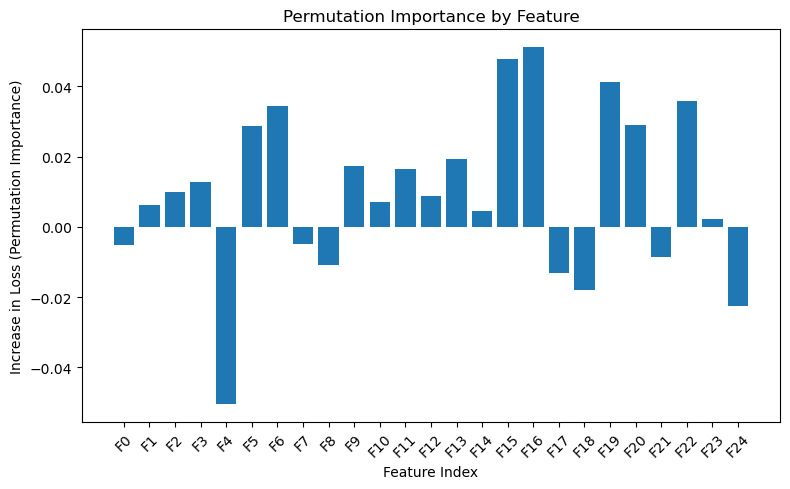

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


Saliency for each feature channel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


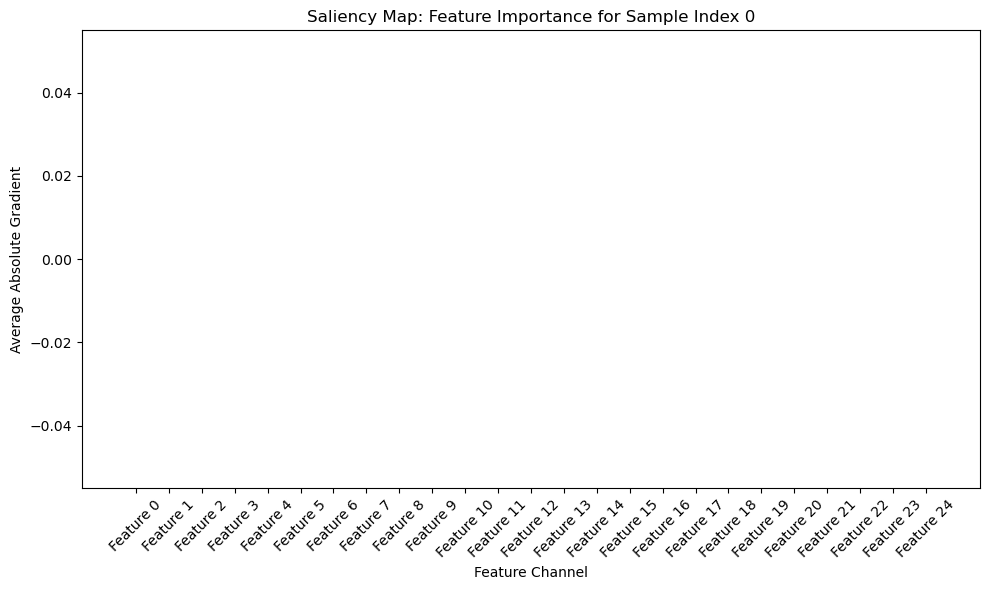

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Select one sample from your test set (for example, the first sample)
sample_index = 0
input_sample = tf.convert_to_tensor(input_test_scaled[sample_index:sample_index+1])  # shape: (1, 32, 32, 19)

# Use GradientTape to compute the gradient of the output with respect to the input
with tf.GradientTape() as tape:
    tape.watch(input_sample)
    # Forward pass: get the predicted probability (assuming model output is a sigmoid)
    prediction = model(input_sample)  # shape: (1, 1)
    # Optionally, if you wish to focus on a particular class, you can select that output.
    loss_value = prediction[0, 0]

# Compute the gradient of the prediction with respect to the input sample
grads = tape.gradient(loss_value, input_sample)  # shape: (1, 32, 32, 19)

# Compute the absolute gradients and average over the spatial dimensions to get per-channel saliency
saliency_per_channel = tf.reduce_mean(tf.abs(grads), axis=[1, 2])  # shape: (1, 19)
saliency_per_channel = saliency_per_channel.numpy().flatten()  # shape: (19,)

print("Saliency for each feature channel:", saliency_per_channel)

# Plot the saliency values for each of the 19 features
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(saliency_per_channel)), saliency_per_channel)
plt.xlabel("Feature Channel")
plt.ylabel("Average Absolute Gradient")
plt.title("Saliency Map: Feature Importance for Sample Index {}".format(sample_index))
plt.xticks(np.arange(len(saliency_per_channel)), [f"Feature {i}" for i in range(len(saliency_per_channel))], rotation=45)
plt.tight_layout()
plt.show()
